In [1]:
import numpy as np
USE_FP16 = True

target_dtype = np.float16 if USE_FP16 else np.float32

In [2]:
from test_for_idd8k import test_dataset, test_dataloader
# Debugging: Check if the dataset is non-empty
print(f"Number of samples in dataset: {len(test_dataset)}")

# Try to get a batch
try:
    input_batch, mask_batch = next(iter(test_dataloader))
    print(f"Input batch shape: {input_batch.shape}")
    print(f"Mask batch shape: {mask_batch.shape}")
except StopIteration:
    print("Dataset is empty or improperly initialized.")


Number of samples in dataset: 1055
Input batch shape: torch.Size([1, 3, 256, 256])
Mask batch shape: torch.Size([1, 1, 256, 256])
torch.float32
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
[[[0.65882355 0.8117647  0.972549  ]
  [0.6509804  0.8117647  0.972549  ]
  [0.6509804  0.80784315 0.96862745]
  ...
  [0.42352942 0.54509807 0.7137255 ]
  [0.42352942 0.54509807 0.7058824 ]
  [0.43137255 0.54901963 0.70980394]]

 [[0.6627451  0.8156863  0.9764706 ]
  [0.654902   0.8156863  0.972549  ]
  [0.64705884 0.8117647  0.96862745]
  ...
  [0.42352942 0.54901963 0.70980394]
  [0.42352942 0.54509807 0.70980394]
  [0.43137255 0.54901963 0.70980394]]

 [[0.65882355 0.8117647  0.98039216]
  [0.654902   0.8156863  0.972549  ]
  [0.64705884 0.8117647  0.96862745]
  ...
  [0.43137255 0.54509807 0.70980394]
  [0.43137255 0.54901963 0.70980394]
  [0.42745098 0.54901963 0.7137255 ]]

 ...

 [[0

Number of samples in dataset: 1055
Input batch shape: torch.Size([1, 3, 256, 256])
Mask batch shape: torch.Size([1, 1, 256, 256])


In [3]:
# Debugging: Check if the dataset is non-empty
print(f"Number of samples in dataset: {len(test_dataset)}")

# Try to get a batch
try:
    input_batch, mask_batch = next(iter(test_dataloader))
    print(f"Input batch shape: {input_batch.shape}")
    print(f"Mask batch shape: {mask_batch.shape}")
    
    preprocessed_batch = np.array(input_batch,np.float16)
    
except StopIteration:
    print("Dataset is empty or improperly initialized.")

Number of samples in dataset: 1055
Input batch shape: torch.Size([1, 3, 256, 256])
Mask batch shape: torch.Size([1, 1, 256, 256])


float64
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


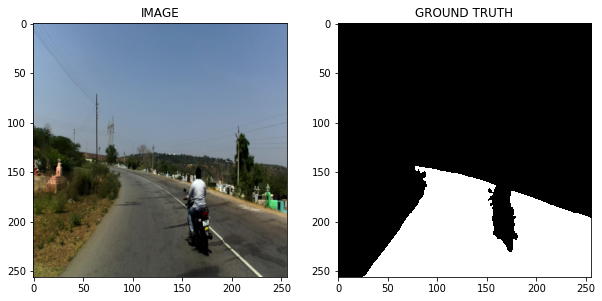

In [6]:
import matplotlib.pyplot as plt
def visualize_sample(img, mask):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    img = img.float() 
    img = img.cpu().numpy()  # Ensure it's on CPU and convert to numpy
    img = img.transpose((1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    img = img * [0.5, 0.5, 0.5] + [0.5, 0.5, 0.5]  # Undo normalization
    img = np.clip(img, 0, 1)  # Ensure all values are within [0, 1]
    print(img.dtype)
    mask = mask.cpu().numpy().squeeze()*255  # Ensure it's on CPU, convert to numpy, and remove extra dimensions
    print(mask)
    ax1.set_title('IMAGE')
    ax1.imshow(img)
        
    ax2.set_title('GROUND TRUTH')
    ax2.imshow(mask, cmap='gray')

    plt.show()

# Fetch a sample from the dataset
idx = 0
img, mask = test_dataset[idx]
visualize_sample(img, mask)


In [33]:
# !pwd

In [34]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_28_22:34:44_PST_2021
Cuda compilation tools, release 10.2, V10.2.300
Build cuda_10.2_r440.TC440_70.29663091_0


In [7]:
%%timeit
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open('/home/nvidia/Documents/tensorrt_iference_tx2/model__new_32bs_unet_scse.trt','rb')
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

86.5 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:

import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open('model__new_32bs_unet_scse.trt','rb')
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
engine = runtime.deserialize_cuda_engine(f.read())

context = engine.create_execution_context()
output = np.empty([1,1,256,256], dtype = target_dtype)


input_bytes = input_batch.nelement() * input_batch.element_size()
output_bytes = output.size * output.itemsize  # For NumPy array

d_input = cuda.mem_alloc(1*input_bytes)
d_output = cuda.mem_alloc(1*output_bytes)
bindings = [int(d_input),int(d_output)]
stream = cuda.Stream()

In [19]:
def predict(batch):
    cuda.memcpy_htod_async(d_input, batch, stream)
    context.execute_async_v2(bindings, stream.handle, None)
    cuda.memcpy_dtoh_async(output, d_output, stream)
    stream.synchronize()
    return output

In [20]:
input_batch.dtype
preprocessed_batch.dtype

dtype('float16')

In [21]:
%%timeit
print('warming up')
pred = predict(preprocessed_batch)
print('finished warming up')

warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming up
finished warming up
warming 

In [22]:
%%timeit
pred = predict(preprocessed_batch)

24.6 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
import cv2
import matplotlib.pyplot as plt

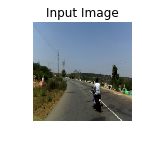

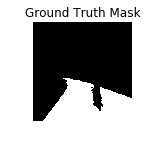

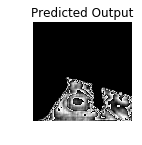

In [41]:
def imshow(img, title=None):
    """Function to show an image that has been tensor normalized"""
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor shape (C, H, W) to (H, W, C)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip values to ensure they lie between 0 and 1
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# Print the shape of the input batch and visualize the first image in the batch
#print('Input batch shape:', input_batch.shape)
plt.subplot(1,3,1)
imshow(input_batch[0], title='Input Image')
mask = mask_batch[0].squeeze()  # Get the first mask and remove any single dimensions

# Check if 'mask' needs to be converted from a tensor to a numpy array
if hasattr(mask, 'cpu'):
    mask = mask.cpu().numpy()  # Convert to numpy array if it's a tensor
plt.subplot(1,3,1)
#print('Ground truth:')
plt.imshow(mask, cmap='gray')  # Display the image in grayscale
plt.title('Ground Truth Mask')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

pred = predict(preprocessed_batch)
#print(pred.shape)
pred_uint8 = (pred[0].squeeze()*255).astype(np.uint8)
plt.subplot(1,3,3)

plt.imshow(pred_uint8, cmap='gray')  # Visualize the first image/prediction
plt.title('Predicted Output')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [62]:
!/usr/src/tensorrt/bin/trtexec --onnx=/home/dalex/Downloads/model.onnx --saveEngine=./model__new_32bs_unet_scse.trt --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16 --verbose

&&&& RUNNING TensorRT.trtexec [TensorRT v8201] # /usr/src/tensorrt/bin/trtexec --onnx=/home/dalex/Downloads/model.onnx --saveEngine=./model__new_32bs_unet_scse.trt --explicitBatch --inputIOFormats=fp16:chw --outputIOFormats=fp16:chw --fp16 --verbose
[06/03/2024-01:36:13] [W] --explicitBatch flag has been deprecated and has no effect!
[06/03/2024-01:36:13] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[06/03/2024-01:36:13] [I] === Model Options ===
[06/03/2024-01:36:13] [I] Format: ONNX
[06/03/2024-01:36:13] [I] Model: /home/dalex/Downloads/model.onnx
[06/03/2024-01:36:13] [I] Output:
[06/03/2024-01:36:13] [I] === Build Options ===
[06/03/2024-01:36:13] [I] Max batch: explicit batch
[06/03/2024-01:36:13] [I] Workspace: 16 MiB
[06/03/2024-01:36:13] [I] minTiming: 1
[06/03/2024-01:36:13] [I] avgTiming: 8
[06/03/2024-01:36:13] [I] Precision: FP32+FP16
[06/03/2024-01:36:13] [I] Calibration: 
[06/03/2024-01:

[06/03/2024-01:36:18] [V] [TRT] Registering tensor: input for ONNX tensor: input
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attention1.attention.cSE.1.weight
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attention1.attention.cSE.1.bias
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attention1.attention.cSE.3.weight
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attention1.attention.cSE.3.bias
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attention1.attention.sSE.0.weight
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attention1.attention.sSE.0.bias
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attention2.attention.cSE.1.weight
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attention2.attention.cSE.1.bias
[06/03/2024-01:36:18] [V] [TRT] Importing initializer: decoder.blocks.0.attenti

[06/03/2024-01:36:18] [V] [TRT] Registering layer: /encoder/features.3/Add for ONNX node: /encoder/features.3/Add
[06/03/2024-01:36:18] [V] [TRT] Registering tensor: /encoder/features.3/Add_output_0 for ONNX tensor: /encoder/features.3/Add_output_0
[06/03/2024-01:36:18] [V] [TRT] /encoder/features.3/Add [Add] outputs: [/encoder/features.3/Add_output_0 -> (-1, 24, 64, 64)[FLOAT]], 
[06/03/2024-01:36:18] [V] [TRT] Parsing node: /encoder/features.4/conv/conv.0/conv.0.0/Conv [Conv]
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /encoder/features.3/Add_output_0
[06/03/2024-01:36:18] [V] [TRT] Searching for input: onnx::Conv_832
[06/03/2024-01:36:18] [V] [TRT] Searching for input: onnx::Conv_833
[06/03/2024-01:36:18] [V] [TRT] /encoder/features.4/conv/conv.0/conv.0.0/Conv [Conv] inputs: [/encoder/features.3/Add_output_0 -> (-1, 24, 64, 64)[FLOAT]], [onnx::Conv_832 -> (144, 24, 1, 1)[FLOAT]], [onnx::Conv_833 -> (144)[FLOAT]], 
[06/03/2024-01:36:18] [V] [TRT] Convolution input dimensions

[06/03/2024-01:36:18] [V] [TRT] Using kernel: (3, 3), strides: (2, 2), prepadding: (1, 1), postpadding: (1, 1), dilations: (1, 1), numOutputs: 192
[06/03/2024-01:36:18] [V] [TRT] Convolution output dimensions: (-1, 192, 16, 16)
[06/03/2024-01:36:18] [V] [TRT] Registering tensor: /encoder/features.7/conv/conv.1/conv.1.0/Conv_output_0 for ONNX tensor: /encoder/features.7/conv/conv.1/conv.1.0/Conv_output_0
[06/03/2024-01:36:18] [V] [TRT] /encoder/features.7/conv/conv.1/conv.1.0/Conv [Conv] outputs: [/encoder/features.7/conv/conv.1/conv.1.0/Conv_output_0 -> (-1, 192, 16, 16)[FLOAT]], 
[06/03/2024-01:36:18] [V] [TRT] Parsing node: /encoder/features.7/conv/conv.1/conv.1.2/Constant [Constant]
[06/03/2024-01:36:18] [V] [TRT] /encoder/features.7/conv/conv.1/conv.1.2/Constant [Constant] inputs: 
[06/03/2024-01:36:18] [V] [TRT] /encoder/features.7/conv/conv.1/conv.1.2/Constant [Constant] outputs: [/encoder/features.7/conv/conv.1/conv.1.2/Constant_output_0 -> ()[FLOAT]], 
[06/03/2024-01:36:18] [V]

[06/03/2024-01:36:18] [V] [TRT] /encoder/features.15/conv/conv.1/conv.1.2/Constant_1 [Constant] inputs: 
[06/03/2024-01:36:18] [V] [TRT] /encoder/features.15/conv/conv.1/conv.1.2/Constant_1 [Constant] outputs: [/encoder/features.15/conv/conv.1/conv.1.2/Constant_1_output_0 -> ()[FLOAT]], 
[06/03/2024-01:36:18] [V] [TRT] Parsing node: /encoder/features.15/conv/conv.1/conv.1.2/Clip [Clip]
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /encoder/features.15/conv/conv.1/conv.1.0/Conv_output_0
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /encoder/features.15/conv/conv.1/conv.1.2/Constant_output_0
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /encoder/features.15/conv/conv.1/conv.1.2/Constant_1_output_0
[06/03/2024-01:36:18] [V] [TRT] /encoder/features.15/conv/conv.1/conv.1.2/Clip [Clip] inputs: [/encoder/features.15/conv/conv.1/conv.1.0/Conv_output_0 -> (-1, 960, 8, 8)[FLOAT]], [/encoder/features.15/conv/conv.1/conv.1.2/Constant_output_0 -> ()[FLOAT]], [/encoder/features.

[06/03/2024-01:36:18] [V] [TRT] Parsing node: /decoder/blocks.0/conv2/conv2.0/Conv [Conv]
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /decoder/blocks.0/conv1/conv1.2/Relu_output_0
[06/03/2024-01:36:18] [V] [TRT] Searching for input: onnx::Conv_964
[06/03/2024-01:36:18] [V] [TRT] Searching for input: onnx::Conv_965
[06/03/2024-01:36:18] [V] [TRT] /decoder/blocks.0/conv2/conv2.0/Conv [Conv] inputs: [/decoder/blocks.0/conv1/conv1.2/Relu_output_0 -> (-1, 256, 16, 16)[FLOAT]], [onnx::Conv_964 -> (256, 256, 3, 3)[FLOAT]], [onnx::Conv_965 -> (256)[FLOAT]], 
[06/03/2024-01:36:18] [V] [TRT] Convolution input dimensions: (-1, 256, 16, 16)
[06/03/2024-01:36:18] [V] [TRT] Registering layer: /decoder/blocks.0/conv2/conv2.0/Conv for ONNX node: /decoder/blocks.0/conv2/conv2.0/Conv
[06/03/2024-01:36:18] [V] [TRT] Using kernel: (3, 3), strides: (1, 1), prepadding: (1, 1), postpadding: (1, 1), dilations: (1, 1), numOutputs: 256
[06/03/2024-01:36:18] [V] [TRT] Convolution output dimensions: (-1,

[06/03/2024-01:36:18] [V] [TRT] Registering tensor: /decoder/blocks.1/attention2/attention/cSE/cSE.4/Sigmoid_output_0 for ONNX tensor: /decoder/blocks.1/attention2/attention/cSE/cSE.4/Sigmoid_output_0
[06/03/2024-01:36:18] [V] [TRT] /decoder/blocks.1/attention2/attention/cSE/cSE.4/Sigmoid [Sigmoid] outputs: [/decoder/blocks.1/attention2/attention/cSE/cSE.4/Sigmoid_output_0 -> (-1, 128, 1, 1)[FLOAT]], 
[06/03/2024-01:36:18] [V] [TRT] Parsing node: /decoder/blocks.1/attention2/attention/Mul [Mul]
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /decoder/blocks.1/conv2/conv2.2/Relu_output_0
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /decoder/blocks.1/attention2/attention/cSE/cSE.4/Sigmoid_output_0
[06/03/2024-01:36:18] [V] [TRT] /decoder/blocks.1/attention2/attention/Mul [Mul] inputs: [/decoder/blocks.1/conv2/conv2.2/Relu_output_0 -> (-1, 128, 32, 32)[FLOAT]], [/decoder/blocks.1/attention2/attention/cSE/cSE.4/Sigmoid_output_0 -> (-1, 128, 1, 1)[FLOAT]], 
[06/03/2024-01:36:18

[06/03/2024-01:36:18] [V] [TRT] Registering layer: /decoder/blocks.2/attention2/attention/cSE/cSE.4/Sigmoid for ONNX node: /decoder/blocks.2/attention2/attention/cSE/cSE.4/Sigmoid
[06/03/2024-01:36:18] [V] [TRT] Registering tensor: /decoder/blocks.2/attention2/attention/cSE/cSE.4/Sigmoid_output_0 for ONNX tensor: /decoder/blocks.2/attention2/attention/cSE/cSE.4/Sigmoid_output_0
[06/03/2024-01:36:18] [V] [TRT] /decoder/blocks.2/attention2/attention/cSE/cSE.4/Sigmoid [Sigmoid] outputs: [/decoder/blocks.2/attention2/attention/cSE/cSE.4/Sigmoid_output_0 -> (-1, 64, 1, 1)[FLOAT]], 
[06/03/2024-01:36:18] [V] [TRT] Parsing node: /decoder/blocks.2/attention2/attention/Mul [Mul]
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /decoder/blocks.2/conv2/conv2.2/Relu_output_0
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /decoder/blocks.2/attention2/attention/cSE/cSE.4/Sigmoid_output_0
[06/03/2024-01:36:18] [V] [TRT] /decoder/blocks.2/attention2/attention/Mul [Mul] inputs: [/decoder/bloc

[06/03/2024-01:36:18] [V] [TRT] Parsing node: /decoder/blocks.3/attention2/attention/Add [Add]
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /decoder/blocks.3/attention2/attention/Mul_output_0
[06/03/2024-01:36:18] [V] [TRT] Searching for input: /decoder/blocks.3/attention2/attention/Mul_1_output_0
[06/03/2024-01:36:18] [V] [TRT] /decoder/blocks.3/attention2/attention/Add [Add] inputs: [/decoder/blocks.3/attention2/attention/Mul_output_0 -> (-1, 32, 128, 128)[FLOAT]], [/decoder/blocks.3/attention2/attention/Mul_1_output_0 -> (-1, 32, 128, 128)[FLOAT]], 
[06/03/2024-01:36:18] [V] [TRT] Registering layer: /decoder/blocks.3/attention2/attention/Add for ONNX node: /decoder/blocks.3/attention2/attention/Add
[06/03/2024-01:36:18] [V] [TRT] Registering tensor: /decoder/blocks.3/attention2/attention/Add_output_0 for ONNX tensor: /decoder/blocks.3/attention2/attention/Add_output_0
[06/03/2024-01:36:18] [V] [TRT] /decoder/blocks.3/attention2/attention/Add [Add] outputs: [/decoder/blocks.3

[06/03/2024-01:36:18] [V] [TRT] Applying generic optimizations to the graph for inference.
[06/03/2024-01:36:18] [V] [TRT] Original: 217 layers
[06/03/2024-01:36:18] [V] [TRT] After dead-layer removal: 217 layers
[06/03/2024-01:36:18] [V] [TRT] After Myelin optimization: 217 layers
[06/03/2024-01:36:18] [V] [TRT] Applying ScaleNodes fusions.
[06/03/2024-01:36:18] [V] [TRT] After scale fusion: 217 layers
[06/03/2024-01:36:18] [V] [TRT] Running: ConvEltwiseSumFusion
[06/03/2024-01:36:18] [V] [TRT] ConvEltwiseSumFusion: Fusing /encoder/features.3/conv/conv.2/Conv with /encoder/features.3/Add
[06/03/2024-01:36:18] [V] [TRT] Running: ConvEltwiseSumFusion
[06/03/2024-01:36:18] [V] [TRT] ConvEltwiseSumFusion: Fusing /encoder/features.5/conv/conv.2/Conv with /encoder/features.5/Add
[06/03/2024-01:36:18] [V] [TRT] Running: ConvEltwiseSumFusion
[06/03/2024-01:36:18] [V] [TRT] ConvEltwiseSumFusion: Fusing /encoder/features.6/conv/conv.2/Conv with /encoder/features.6/Add
[06/03/2024-01:36:18] [V] 

[06/03/2024-01:36:18] [V] [TRT] Running: ActivationToPointwiseConversion
[06/03/2024-01:36:18] [V] [TRT] Swap the layer type of /encoder/features.5/conv/conv.0/conv.0.2/Clip from ACTIVATION to POINTWISE
[06/03/2024-01:36:18] [V] [TRT] Running: ActivationToPointwiseConversion
[06/03/2024-01:36:18] [V] [TRT] Swap the layer type of /encoder/features.5/conv/conv.1/conv.1.2/Clip from ACTIVATION to POINTWISE
[06/03/2024-01:36:18] [V] [TRT] Running: ActivationToPointwiseConversion
[06/03/2024-01:36:18] [V] [TRT] Swap the layer type of /encoder/features.6/conv/conv.0/conv.0.2/Clip from ACTIVATION to POINTWISE
[06/03/2024-01:36:18] [V] [TRT] Running: ActivationToPointwiseConversion
[06/03/2024-01:36:18] [V] [TRT] Swap the layer type of /encoder/features.6/conv/conv.1/conv.1.2/Clip from ACTIVATION to POINTWISE
[06/03/2024-01:36:18] [V] [TRT] Running: ActivationToPointwiseConversion
[06/03/2024-01:36:18] [V] [TRT] Swap the layer type of /encoder/features.7/conv/conv.0/conv.0.2/Clip from ACTIVATIO

[06/03/2024-01:36:18] [V] [TRT] Running: ConvPointWiseClipFusion
[06/03/2024-01:36:18] [V] [TRT] ConvPointWiseClipFusion: Fusing /encoder/features.8/conv/conv.1/conv.1.0/Conv with PWN(/encoder/features.8/conv/conv.1/conv.1.2/Clip)
[06/03/2024-01:36:18] [V] [TRT] Running: ConvPointWiseClipFusion
[06/03/2024-01:36:18] [V] [TRT] ConvPointWiseClipFusion: Fusing /encoder/features.9/conv/conv.0/conv.0.0/Conv with PWN(/encoder/features.9/conv/conv.0/conv.0.2/Clip)
[06/03/2024-01:36:18] [V] [TRT] Running: ConvPointWiseClipFusion
[06/03/2024-01:36:18] [V] [TRT] ConvPointWiseClipFusion: Fusing /encoder/features.9/conv/conv.1/conv.1.0/Conv with PWN(/encoder/features.9/conv/conv.1/conv.1.2/Clip)
[06/03/2024-01:36:18] [V] [TRT] Running: ConvPointWiseClipFusion
[06/03/2024-01:36:18] [V] [TRT] ConvPointWiseClipFusion: Fusing /encoder/features.10/conv/conv.0/conv.0.0/Conv with PWN(/encoder/features.10/conv/conv.0/conv.0.2/Clip)
[06/03/2024-01:36:18] [V] [TRT] Running: ConvPointWiseClipFusion
[06/03/20

[06/03/2024-01:36:18] [V] [TRT] Running: PointWiseFusion
[06/03/2024-01:36:18] [V] [TRT] PointWiseFusion: Fusing PWN(PWN(/decoder/blocks.3/attention1/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.3/attention1/attention/Mul_1) with PWN(PWN(PWN(/decoder/blocks.3/attention1/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.3/attention1/attention/Mul), /decoder/blocks.3/attention1/attention/Add)
[06/03/2024-01:36:18] [V] [TRT] Running: PointWiseFusion
[06/03/2024-01:36:18] [V] [TRT] PointWiseFusion: Fusing PWN(/decoder/blocks.3/attention2/attention/cSE/cSE.4/Sigmoid) with /decoder/blocks.3/attention2/attention/Mul
[06/03/2024-01:36:18] [V] [TRT] Running: PointWiseFusion
[06/03/2024-01:36:18] [V] [TRT] PointWiseFusion: Fusing PWN(PWN(/decoder/blocks.3/attention2/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.3/attention2/attention/Mul) with /decoder/blocks.3/attention2/attention/Add
[06/03/2024-01:36:18] [V] [TRT] Running: PointWiseFusion
[06/03/2024-01:36:18] [V] [TRT] PointWiseFusion: Fusing P

[06/03/2024-01:36:20] [V] [TRT] Using cublas as a tactic source
[06/03/2024-01:36:20] [I] [TRT] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +168, GPU +35, now: CPU 510, GPU 7677 (MiB)
[06/03/2024-01:36:20] [V] [TRT] Using cuDNN as a tactic source
[06/03/2024-01:36:27] [I] [TRT] [MemUsageChange] Init cuDNN: CPU +249, GPU +66, now: CPU 759, GPU 7743 (MiB)
[06/03/2024-01:36:28] [I] [TRT] Local timing cache in use. Profiling results in this builder pass will not be stored.
[06/03/2024-01:36:28] [V] [TRT] Constructing optimization profile number 0 [1/1].
[06/03/2024-01:36:28] [V] [TRT] Reserving memory for activation tensors. Host: 0 bytes Device: 1048576 bytes
[06/03/2024-01:36:28] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:28] [V] [TRT] *************** Autotuning Reformat: Half(196608,65536,256,1) -> Float(196608,65536,256,1) ***************
[06/03/2024-01:36:28] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(input -> <out>) (Reformat)
[06/03/2024

[06/03/2024-01:36:29] [V] [TRT] Tactic: 1002 Time: 0.498504
[06/03/2024-01:36:29] [V] [TRT] Tactic: 0 Time: 0.41784
[06/03/2024-01:36:29] [V] [TRT] Fastest Tactic: 0 Time: 0.41784
[06/03/2024-01:36:29] [V] [TRT] *************** Autotuning Reformat: Float(1310720,16384,128,1) -> Float(49152,16384:32,128,1) ***************
[06/03/2024-01:36:29] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.1/conv/conv.1/Conv_output_0) (Reformat)
[06/03/2024-01:36:29] [V] [TRT] Tactic: 1002 Time: 1.29684
[06/03/2024-01:36:29] [V] [TRT] Tactic: 0 Time: 2.48829
[06/03/2024-01:36:29] [V] [TRT] Fastest Tactic: 1002 Time: 1.29684
[06/03/2024-01:36:29] [V] [TRT] *************** Autotuning Reformat: Float(1310720,16384,128,1) -> Half(1310720,16384,128,1) ***************
[06/03/2024-01:36:29] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.1/conv/conv.1/Conv_output_0) (Reformat)
[06/03/2024-01:36:29] [V] [TRT] Tactic: 1002 Time: 0.34372

[06/03/2024-01:36:30] [V] [TRT] Tactic: 1002 Time: 0.595
[06/03/2024-01:36:30] [V] [TRT] Tactic: 0 Time: 0.575916
[06/03/2024-01:36:30] [V] [TRT] Fastest Tactic: 0 Time: 0.575916
[06/03/2024-01:36:30] [V] [TRT] *************** Autotuning Reformat: Float(1310720,1,10240,80) -> Half(1310720,16384,128,1) ***************
[06/03/2024-01:36:30] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.1/conv/conv.1/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:30] [V] [TRT] Tactic: 1002 Time: 0.276332
[06/03/2024-01:36:30] [V] [TRT] Tactic: 0 Time: 0.546684
[06/03/2024-01:36:30] [V] [TRT] Fastest Tactic: 1002 Time: 0.276332
[06/03/2024-01:36:30] [V] [TRT] *************** Autotuning Reformat: Float(1310720,1,10240,80) -> Half(655360,16384:2,128,1) ***************
[06/03/2024-01:36:30] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.1/conv/conv.1/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:30] [V] [TRT] Tactic: 1002 Time: 0.2912

[06/03/2024-01:36:31] [V] [TRT] Tactic: 0 Time: 3.34268
[06/03/2024-01:36:31] [V] [TRT] Fastest Tactic: 1002 Time: 0.5984
[06/03/2024-01:36:31] [V] [TRT] *************** Autotuning Reformat: Float(1572864,1,12288,96) -> Half(786432,16384:2,128,1) ***************
[06/03/2024-01:36:31] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.2/conv/conv.0/conv.0.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:31] [V] [TRT] Tactic: 1002 Time: 0.856208
[06/03/2024-01:36:31] [V] [TRT] Tactic: 0 Time: 3.60824
[06/03/2024-01:36:31] [V] [TRT] Fastest Tactic: 1002 Time: 0.856208
[06/03/2024-01:36:31] [V] [TRT] *************** Autotuning Reformat: Half(1572864,16384,128,1) -> Float(1572864,16384,128,1) ***************
[06/03/2024-01:36:31] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.2/conv/conv.0/conv.0.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:31] [V] [TRT] Tactic: 1002 Time: 0.812996
[06/03/2024-01:36:31] [V] [TRT] Tact

[06/03/2024-01:36:32] [V] [TRT] Tactic: 0 Time: 0.276908
[06/03/2024-01:36:32] [V] [TRT] Fastest Tactic: 1002 Time: 0.153284
[06/03/2024-01:36:32] [V] [TRT] *************** Autotuning Reformat: Half(196608,4096:2,64,1) -> Half(393216,4096,64,1) ***************
[06/03/2024-01:36:32] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.2/conv/conv.1/conv.1.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:32] [V] [TRT] Tactic: 1002 Time: 0.360156
[06/03/2024-01:36:32] [V] [TRT] Tactic: 0 Time: 0.112772
[06/03/2024-01:36:32] [V] [TRT] Fastest Tactic: 0 Time: 0.112772
[06/03/2024-01:36:32] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:32] [V] [TRT] *************** Autotuning Reformat: Float(98304,4096,64,1) -> Float(98304,1,1536,24) ***************
[06/03/2024-01:36:32] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.2/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:32] [V] [TRT] Tactic: 

[06/03/2024-01:36:32] [V] [TRT] Tactic: 1002 Time: 0.05664
[06/03/2024-01:36:32] [V] [TRT] Tactic: 0 Time: 0.05168
[06/03/2024-01:36:32] [V] [TRT] Fastest Tactic: 0 Time: 0.05168
[06/03/2024-01:36:32] [V] [TRT] *************** Autotuning Reformat: Half(98304,4096,64,1) -> Float(98304,1,1536,24) ***************
[06/03/2024-01:36:32] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.2/conv/conv.2/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:32] [V] [TRT] Tactic: 1002 Time: 0.063208
[06/03/2024-01:36:32] [V] [TRT] Tactic: 0 Time: 0.070596
[06/03/2024-01:36:32] [V] [TRT] Fastest Tactic: 1002 Time: 0.063208
[06/03/2024-01:36:32] [V] [TRT] *************** Autotuning Reformat: Half(98304,4096,64,1) -> Half(49152,4096:2,64,1) ***************
[06/03/2024-01:36:32] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.2/conv/conv.2/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:32] [V] [TRT] Tactic: 1002 Time: 0.052992
[06/03/2024

[06/03/2024-01:36:32] [V] [TRT] Tactic: 1002 Time: 0.097736
[06/03/2024-01:36:32] [V] [TRT] Tactic: 0 Time: 0.052392
[06/03/2024-01:36:32] [V] [TRT] Fastest Tactic: 0 Time: 0.052392
[06/03/2024-01:36:32] [V] [TRT] *************** Autotuning Reformat: Float(147456,1,4608,144) -> Float(147456,1024,32,1) ***************
[06/03/2024-01:36:32] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.4/conv/conv.1/conv.1.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:32] [V] [TRT] Tactic: 1002 Time: 0.124552
[06/03/2024-01:36:32] [V] [TRT] Tactic: 0 Time: 0.107336
[06/03/2024-01:36:32] [V] [TRT] Fastest Tactic: 0 Time: 0.107336
[06/03/2024-01:36:32] [V] [TRT] *************** Autotuning Reformat: Float(147456,1,4608,144) -> Half(147456,1024,32,1) ***************
[06/03/2024-01:36:32] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.4/conv/conv.1/conv.1.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:32] [V] [TRT] Tactic: 1002 Ti

[06/03/2024-01:36:33] [V] [TRT] Tactic: 0 Time: 0.013332
[06/03/2024-01:36:33] [V] [TRT] Fastest Tactic: 0 Time: 0.013332
[06/03/2024-01:36:33] [V] [TRT] *************** Autotuning Reformat: Half(16384,1024:2,32,1) -> Float(32768,1024,32,1) ***************
[06/03/2024-01:36:33] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.4/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:33] [V] [TRT] Tactic: 1002 Time: 0.022924
[06/03/2024-01:36:33] [V] [TRT] Tactic: 0 Time: 0.0117
[06/03/2024-01:36:33] [V] [TRT] Fastest Tactic: 0 Time: 0.0117
[06/03/2024-01:36:33] [V] [TRT] *************** Autotuning Reformat: Half(16384,1024:2,32,1) -> Float(32768,1,1024,32) ***************
[06/03/2024-01:36:33] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.4/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:33] [V] [TRT] Tactic: 1002 Time: 0.016964
[06/03/2024-01:36:33] [V] [TRT] Tactic: 0 Time: 0.026128
[06/03/2024-01:36

[06/03/2024-01:36:33] [V] [TRT] Tactic: 0 Time: 0.069424
[06/03/2024-01:36:33] [V] [TRT] Fastest Tactic: 0 Time: 0.069424
[06/03/2024-01:36:33] [V] [TRT] *************** Autotuning Reformat: Float(196608,1,6144,192) -> Float(196608,1024,32,1) ***************
[06/03/2024-01:36:33] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.5/conv/conv.0/conv.0.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:33] [V] [TRT] Tactic: 1002 Time: 0.132124
[06/03/2024-01:36:34] [V] [TRT] Tactic: 0 Time: 0.156332
[06/03/2024-01:36:34] [V] [TRT] Fastest Tactic: 1002 Time: 0.132124
[06/03/2024-01:36:34] [V] [TRT] *************** Autotuning Reformat: Float(196608,1,6144,192) -> Half(196608,1024,32,1) ***************
[06/03/2024-01:36:34] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.5/conv/conv.0/conv.0.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:34] [V] [TRT] Tactic: 1002 Time: 0.080052
[06/03/2024-01:36:34] [V] [TRT] Tactic: 0 Ti

[06/03/2024-01:36:34] [V] [TRT] Tactic: 1002 Time: 0.550216
[06/03/2024-01:36:34] [V] [TRT] Tactic: 0 Time: 0.02678
[06/03/2024-01:36:34] [V] [TRT] Fastest Tactic: 0 Time: 0.02678
[06/03/2024-01:36:34] [V] [TRT] *************** Autotuning Reformat: Float(49152,256,16,1) -> Half(24576,256:2,16,1) ***************
[06/03/2024-01:36:34] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.7/conv/conv.1/conv.1.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:34] [V] [TRT] Tactic: 1002 Time: 0.035472
[06/03/2024-01:36:34] [V] [TRT] Tactic: 0 Time: 0.01872
[06/03/2024-01:36:34] [V] [TRT] Fastest Tactic: 0 Time: 0.01872
[06/03/2024-01:36:34] [V] [TRT] *************** Autotuning Reformat: Float(49152,1,3072,192) -> Float(49152,256,16,1) ***************
[06/03/2024-01:36:34] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.7/conv/conv.1/conv.1.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:34] [V] [TRT] Tactic: 1002 Time: 0.0312

[06/03/2024-01:36:34] [V] [TRT] Tactic: 0 Time: 0.01302
[06/03/2024-01:36:34] [V] [TRT] Fastest Tactic: 1002 Time: 0.010028
[06/03/2024-01:36:34] [V] [TRT] *************** Autotuning Reformat: Half(16384,256,16,1) -> Half(8192,256:2,16,1) ***************
[06/03/2024-01:36:34] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.7/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:34] [V] [TRT] Tactic: 1002 Time: 0.013192
[06/03/2024-01:36:34] [V] [TRT] Tactic: 0 Time: 0.008156
[06/03/2024-01:36:34] [V] [TRT] Fastest Tactic: 0 Time: 0.008156
[06/03/2024-01:36:34] [V] [TRT] *************** Autotuning Reformat: Half(8192,256:2,16,1) -> Float(16384,256,16,1) ***************
[06/03/2024-01:36:34] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.7/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:34] [V] [TRT] Tactic: 1002 Time: 0.015
[06/03/2024-01:36:34] [V] [TRT] Tactic: 0 Time: 0.00744
[06/03/2024-01:36:34] 

[06/03/2024-01:36:35] [V] [TRT] Tactic: 1002 Time: 1.09811
[06/03/2024-01:36:35] [V] [TRT] Tactic: 0 Time: 0.05694
[06/03/2024-01:36:35] [V] [TRT] Fastest Tactic: 0 Time: 0.05694
[06/03/2024-01:36:35] [V] [TRT] *************** Autotuning Reformat: Float(98304,256,16,1) -> Half(49152,256:2,16,1) ***************
[06/03/2024-01:36:35] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.8/conv/conv.0/conv.0.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:35] [V] [TRT] Tactic: 1002 Time: 0.070192
[06/03/2024-01:36:35] [V] [TRT] Tactic: 0 Time: 0.036324
[06/03/2024-01:36:35] [V] [TRT] Fastest Tactic: 0 Time: 0.036324
[06/03/2024-01:36:35] [V] [TRT] *************** Autotuning Reformat: Float(98304,1,6144,384) -> Float(98304,256,16,1) ***************
[06/03/2024-01:36:35] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.8/conv/conv.0/conv.0.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:35] [V] [TRT] Tactic: 1002 Time: 0.074

[06/03/2024-01:36:35] [V] [TRT] Tactic: 1002 Time: 0.27884
[06/03/2024-01:36:35] [V] [TRT] Tactic: 0 Time: 0.014616
[06/03/2024-01:36:35] [V] [TRT] Fastest Tactic: 0 Time: 0.014616
[06/03/2024-01:36:35] [V] [TRT] *************** Autotuning Reformat: Float(24576,256,16,1) -> Half(12288,256:2,16,1) ***************
[06/03/2024-01:36:35] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.11/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:35] [V] [TRT] Tactic: 1002 Time: 0.021456
[06/03/2024-01:36:35] [V] [TRT] Tactic: 0 Time: 0.011352
[06/03/2024-01:36:35] [V] [TRT] Fastest Tactic: 0 Time: 0.011352
[06/03/2024-01:36:35] [V] [TRT] *************** Autotuning Reformat: Float(24576,1,1536,96) -> Float(24576,256,16,1) ***************
[06/03/2024-01:36:35] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.11/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:35] [V] [TRT] Tactic: 1002 Time: 0.026496
[06/03/2024-0

[06/03/2024-01:36:36] [V] [TRT] Tactic: 1002 Time: 0.01336
[06/03/2024-01:36:36] [V] [TRT] Tactic: 0 Time: 0.017788
[06/03/2024-01:36:36] [V] [TRT] Fastest Tactic: 1002 Time: 0.01336
[06/03/2024-01:36:36] [V] [TRT] *************** Autotuning Reformat: Half(24576,256,16,1) -> Half(12288,256:2,16,1) ***************
[06/03/2024-01:36:36] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.11/conv/conv.2/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:36] [V] [TRT] Tactic: 1002 Time: 0.015316
[06/03/2024-01:36:36] [V] [TRT] Tactic: 0 Time: 0.011132
[06/03/2024-01:36:36] [V] [TRT] Fastest Tactic: 0 Time: 0.011132
[06/03/2024-01:36:36] [V] [TRT] *************** Autotuning Reformat: Half(12288,256:2,16,1) -> Float(24576,256,16,1) ***************
[06/03/2024-01:36:36] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.11/conv/conv.2/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:36] [V] [TRT] Tactic: 1002 Time: 0.018984
[06/03/202

[06/03/2024-01:36:36] [V] [TRT] Tactic: 0 Time: 0.022176
[06/03/2024-01:36:36] [V] [TRT] Fastest Tactic: 0 Time: 0.022176
[06/03/2024-01:36:36] [V] [TRT] *************** Autotuning Reformat: Float(36864,64,8,1) -> Half(18432,64:2,8,1) ***************
[06/03/2024-01:36:36] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.14/conv/conv.1/conv.1.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:36] [V] [TRT] Tactic: 1002 Time: 0.0284
[06/03/2024-01:36:36] [V] [TRT] Tactic: 0 Time: 0.015192
[06/03/2024-01:36:36] [V] [TRT] Fastest Tactic: 0 Time: 0.015192
[06/03/2024-01:36:36] [V] [TRT] *************** Autotuning Reformat: Float(36864,1,4608,576) -> Float(36864,64,8,1) ***************
[06/03/2024-01:36:36] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.14/conv/conv.1/conv.1.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:36] [V] [TRT] Tactic: 1002 Time: 0.029836
[06/03/2024-01:36:36] [V] [TRT] Tactic: 0 Time: 0.022844
[0

[06/03/2024-01:36:37] [V] [TRT] Tactic: 1002 Time: 0.008144
[06/03/2024-01:36:37] [V] [TRT] Tactic: 0 Time: 0.008768
[06/03/2024-01:36:37] [V] [TRT] Fastest Tactic: 1002 Time: 0.008144
[06/03/2024-01:36:37] [V] [TRT] *************** Autotuning Reformat: Half(10240,64,8,1) -> Half(5120,64:2,8,1) ***************
[06/03/2024-01:36:37] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.14/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:37] [V] [TRT] Tactic: 1002 Time: 0.0118
[06/03/2024-01:36:37] [V] [TRT] Tactic: 0 Time: 0.006372
[06/03/2024-01:36:37] [V] [TRT] Fastest Tactic: 0 Time: 0.006372
[06/03/2024-01:36:37] [V] [TRT] *************** Autotuning Reformat: Half(5120,64:2,8,1) -> Float(10240,64,8,1) ***************
[06/03/2024-01:36:37] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /encoder/features.14/conv/conv.2/Conv_output_0) (Reformat)
[06/03/2024-01:36:37] [V] [TRT] Tactic: 1002 Time: 0.011452
[06/03/2024-01:36:37] 

[06/03/2024-01:36:37] [V] [TRT] Tactic: 0 Time: 0.033088
[06/03/2024-01:36:37] [V] [TRT] Fastest Tactic: 0 Time: 0.033088
[06/03/2024-01:36:37] [V] [TRT] *************** Autotuning Reformat: Float(61440,64,8,1) -> Half(30720,64:2,8,1) ***************
[06/03/2024-01:36:37] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.15/conv/conv.0/conv.0.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:37] [V] [TRT] Tactic: 1002 Time: 0.042348
[06/03/2024-01:36:37] [V] [TRT] Tactic: 0 Time: 0.023308
[06/03/2024-01:36:37] [V] [TRT] Fastest Tactic: 0 Time: 0.023308
[06/03/2024-01:36:37] [V] [TRT] *************** Autotuning Reformat: Float(61440,1,7680,960) -> Float(61440,64,8,1) ***************
[06/03/2024-01:36:37] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.15/conv/conv.0/conv.0.2/Clip_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:37] [V] [TRT] Tactic: 1002 Time: 0.044176
[06/03/2024-01:36:37] [V] [TRT] Tactic: 0 Time: 0.037192


[06/03/2024-01:36:37] [V] [TRT] Tactic: 1002 Time: 0.01338
[06/03/2024-01:36:37] [V] [TRT] Tactic: 0 Time: 0.015596
[06/03/2024-01:36:37] [V] [TRT] Fastest Tactic: 1002 Time: 0.01338
[06/03/2024-01:36:37] [V] [TRT] *************** Autotuning Reformat: Float(20480,64,8,1) -> Half(20480,64,8,1) ***************
[06/03/2024-01:36:37] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.17/conv/conv.2/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:37] [V] [TRT] Tactic: 1002 Time: 0.231504
[06/03/2024-01:36:37] [V] [TRT] Tactic: 0 Time: 0.012408
[06/03/2024-01:36:37] [V] [TRT] Fastest Tactic: 0 Time: 0.012408
[06/03/2024-01:36:37] [V] [TRT] *************** Autotuning Reformat: Float(20480,64,8,1) -> Half(10240,64:2,8,1) ***************
[06/03/2024-01:36:37] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/encoder/features.17/conv/conv.2/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:37] [V] [TRT] Tactic: 1002 Time: 0.018996
[06/03/2024-01:36:3

[06/03/2024-01:36:38] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/Resize_output_0 copy (Reformat)
[06/03/2024-01:36:38] [V] [TRT] Tactic: 1002 Time: 0.208488
[06/03/2024-01:36:38] [V] [TRT] Tactic: 0 Time: 0.086432
[06/03/2024-01:36:38] [V] [TRT] Fastest Tactic: 0 Time: 0.086432
[06/03/2024-01:36:38] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 0
[06/03/2024-01:36:38] [V] [TRT] *************** Autotuning Reformat: Float(327680,256,16,1) -> Float(352256,1,22016,1376) ***************
[06/03/2024-01:36:38] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/Resize_output_0 copy (Reformat)
[06/03/2024-01:36:38] [V] [TRT] Tactic: 1002 Time: 0.160272
[06/03/2024-01:36:38] [V] [TRT] Tactic: 0 Time: 0.294436
[06/03/2024-01:36:38] [V] [TRT] Fastest Tactic: 1002 Time: 0.160272
[06/03/2024-01:36:38] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:38] [V] [TRT] *************** Autotuning Reformat: Float(327680,256,16,1) ->

[06/03/2024-01:36:39] [V] [TRT] Tactic: 0 Time: 0.033304
[06/03/2024-01:36:39] [V] [TRT] Fastest Tactic: 1002 Time: 0.01886
[06/03/2024-01:36:39] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:39] [V] [TRT] *************** Autotuning Reformat: Float(24576,1,1536,96) -> Half(352256,256,16,1) ***************
[06/03/2024-01:36:39] [V] [TRT] --------------- Timing Runner: /encoder/features.13/Add_output_0 copy (Reformat)
[06/03/2024-01:36:39] [V] [TRT] Tactic: 1002 Time: 0.013584
[06/03/2024-01:36:39] [V] [TRT] Tactic: 0 Time: 0.01696
[06/03/2024-01:36:39] [V] [TRT] Fastest Tactic: 1002 Time: 0.013584
[06/03/2024-01:36:39] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:39] [V] [TRT] *************** Autotuning Reformat: Float(24576,1,1536,96) -> Half(176128,256:2,16,1) ***************
[06/03/2024-01:36:39] [V] [TRT] --------------- Timing Runner: /encoder/features.13/Add_output_0 copy (Reformat)
[06/03/2024-01:36:39

[06/03/2024-01:36:39] [V] [TRT] Tactic: 1002 Time: 0.196712
[06/03/2024-01:36:39] [V] [TRT] Tactic: 0 Time: 0.25872
[06/03/2024-01:36:39] [V] [TRT] Fastest Tactic: 1002 Time: 0.196712
[06/03/2024-01:36:39] [V] [TRT] *************** Autotuning Reformat: Float(11008,256:32,16,1) -> Float(352256,256,16,1) ***************
[06/03/2024-01:36:39] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:39] [V] [TRT] Tactic: 1002 Time: 0.214828
[06/03/2024-01:36:39] [V] [TRT] Tactic: 0 Time: 0.229228
[06/03/2024-01:36:39] [V] [TRT] Fastest Tactic: 1002 Time: 0.214828
[06/03/2024-01:36:39] [V] [TRT] *************** Autotuning Reformat: Float(11008,256:32,16,1) -> Half(352256,256,16,1) ***************
[06/03/2024-01:36:39] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:39] [V] [TRT] Tactic: 1002 Time: 0.144628
[06/03/2024-01:36:39] [V] 

[06/03/2024-01:36:40] [V] [TRT] Tactic: 1002 Time: 0.020152
[06/03/2024-01:36:40] [V] [TRT] Tactic: 0 Time: 0.002884
[06/03/2024-01:36:40] [V] [TRT] Fastest Tactic: 0 Time: 0.002884
[06/03/2024-01:36:40] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:40] [V] [TRT] *************** Autotuning Reformat: Float(86,1,1,1) -> Float(86,1,86,86) ***************
[06/03/2024-01:36:40] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/attention1/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:40] [V] [TRT] Tactic: 1002 Time: 0.009784
[06/03/2024-01:36:40] [V] [TRT] Tactic: 0 Time: 0.003032
[06/03/2024-01:36:40] [V] [TRT] Fastest Tactic: 0 Time: 0.003032
[06/03/2024-01:36:40] [V] [TRT] *************** Autotuning Reformat: Float(86,1,1,1) -> Half(86,1,1,1) ***************
[06/03/2024-01:36:40] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/attention1/attention/cSE/cSE.2/Relu_output_0 -> <out

[06/03/2024-01:36:40] [V] [TRT] Fastest Tactic: 1002 Time: 0.135808
[06/03/2024-01:36:40] [V] [TRT] *************** Autotuning Reformat: Half(352256,256,16,1) -> Half(176128,256:2,16,1) ***************
[06/03/2024-01:36:40] [V] [TRT] *************** Autotuning Reformat: Half(176128,256:2,16,1) -> Float(352256,256,16,1) ***************
[06/03/2024-01:36:40] [V] [TRT] *************** Autotuning Reformat: Half(176128,256:2,16,1) -> Float(352256,1,22016,1376) ***************
[06/03/2024-01:36:40] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:40] [V] [TRT] Tactic: 1002 Time: 0.140256
[06/03/2024-01:36:40] [V] [TRT] Tactic: 0 Time: 0.281284
[06/03/2024-01:36:40] [V] [TRT] Fastest Tactic: 1002 Time: 0.140256
[06/03/2024-01:36:40] [V] [TRT] *************** Autotuning Reformat: Half(176128,256:2,16,1) -> Half(352256,256,16,1) ***************
[06/03/2024-01:36:40] [V] [TRT] =============== Computing reformatti

[06/03/2024-01:36:41] [V] [TRT] Tactic: 1002 Time: 0.008092
[06/03/2024-01:36:41] [V] [TRT] Tactic: 0 Time: 0.003668
[06/03/2024-01:36:41] [V] [TRT] Fastest Tactic: 0 Time: 0.003668
[06/03/2024-01:36:41] [V] [TRT] *************** Autotuning Reformat: Half(256,256:2,16,1) -> Float(256,256:32,16,1) ***************
[06/03/2024-01:36:41] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:41] [V] [TRT] Tactic: 1002 Time: 0.007172
[06/03/2024-01:36:41] [V] [TRT] Tactic: 0 Time: 0.011272
[06/03/2024-01:36:41] [V] [TRT] Fastest Tactic: 1002 Time: 0.007172
[06/03/2024-01:36:41] [V] [TRT] *************** Autotuning Reformat: Half(256,256:2,16,1) -> Half(256,256,16,1) ***************
[06/03/2024-01:36:41] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:41] [V] [TRT] Tactic: 1

[06/03/2024-01:36:41] [V] [TRT] Tactic: 1002 Time: 0.021892
[06/03/2024-01:36:41] [V] [TRT] Tactic: 0 Time: 0.004652
[06/03/2024-01:36:41] [V] [TRT] Fastest Tactic: 0 Time: 0.004652
[06/03/2024-01:36:41] [V] [TRT] *************** Autotuning Reformat: Half(1376,1,1,1) -> Half(688,1:2,1,1) ***************
[06/03/2024-01:36:41] [V] [TRT] *************** Autotuning Reformat: Half(688,1:2,1,1) -> Float(1376,1,1,1) ***************
[06/03/2024-01:36:41] [V] [TRT] *************** Autotuning Reformat: Half(688,1:2,1,1) -> Float(1376,1,1376,1376) ***************
[06/03/2024-01:36:41] [V] [TRT] *************** Autotuning Reformat: Half(688,1:2,1,1) -> Float(43,1:32,1,1) ***************
[06/03/2024-01:36:41] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:41] [V] [TRT] Tactic: 1002 Time: 0.020136
[06/03/2024-01:36:41] [V] [TRT] Tactic: 0 Time: 0.004652
[06/03/2024-01:36:41] [V] [TRT] F

[06/03/2024-01:36:41] [V] [TRT] Tactic: 0 Time: 0.048756
[06/03/2024-01:36:41] [V] [TRT] Fastest Tactic: 1002 Time: 0.0288
[06/03/2024-01:36:41] [V] [TRT] *************** Autotuning Reformat: Half(32768,256:2,16,1) -> Half(65536,256,16,1) ***************
[06/03/2024-01:36:41] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/conv1/conv1.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:41] [V] [TRT] Tactic: 1002 Time: 0.054144
[06/03/2024-01:36:41] [V] [TRT] Tactic: 0 Time: 0.020648
[06/03/2024-01:36:41] [V] [TRT] Fastest Tactic: 0 Time: 0.020648
[06/03/2024-01:36:41] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:41] [V] [TRT] *************** Autotuning Reformat: Float(65536,256,16,1) -> Float(65536,1,4096,256) ***************
[06/03/2024-01:36:41] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.0/conv2/conv2.2/Relu_output_0) (Reformat)
[06/03/2024-01:36:41] [V] [TRT] Tactic: 1002 Time: 0.03

[06/03/2024-01:36:42] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/conv2/conv2.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:42] [V] [TRT] Tactic: 1002 Time: 0.044248
[06/03/2024-01:36:42] [V] [TRT] Tactic: 0 Time: 0.045716
[06/03/2024-01:36:42] [V] [TRT] Fastest Tactic: 1002 Time: 0.044248
[06/03/2024-01:36:42] [V] [TRT] *************** Autotuning Reformat: Float(2048,256:32,16,1) -> Half(65536,256,16,1) ***************
[06/03/2024-01:36:42] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/conv2/conv2.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:42] [V] [TRT] Tactic: 1002 Time: 0.03076
[06/03/2024-01:36:42] [V] [TRT] Tactic: 0 Time: 0.045852
[06/03/2024-01:36:42] [V] [TRT] Fastest Tactic: 1002 Time: 0.03076
[06/03/2024-01:36:42] [V] [TRT] *************** Autotuning Reformat: Float(2048,256:32,16,1) -> Half(32768,256:2,16,1) ***************
[06/03/2024-01:36:42] [V] [TRT] --------------- Timing Runner: Opt

[06/03/2024-01:36:42] [V] [TRT] Tactic: 0 Time: 0.004592
[06/03/2024-01:36:42] [V] [TRT] Fastest Tactic: 0 Time: 0.004592
[06/03/2024-01:36:42] [V] [TRT] *************** Autotuning Reformat: Float(16,1,1,1) -> Half(8,1:2,1,1) ***************
[06/03/2024-01:36:42] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:42] [V] [TRT] Tactic: 1002 Time: 0.006352
[06/03/2024-01:36:42] [V] [TRT] Tactic: 0 Time: 0.0029
[06/03/2024-01:36:42] [V] [TRT] Fastest Tactic: 0 Time: 0.0029
[06/03/2024-01:36:42] [V] [TRT] *************** Autotuning Reformat: Float(16,1,16,16) -> Float(16,1,1,1) ***************
[06/03/2024-01:36:42] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:42] [V] [TRT] Tactic: 1002 Time: 0.009848
[06/03/2024-01:36:42] [V] [TRT] Tactic: 0 Time: 0.003
[06/03/2024-

[06/03/2024-01:36:42] [V] [TRT] Tactic: 1002 Time: 0.03348
[06/03/2024-01:36:42] [V] [TRT] Tactic: 0 Time: 0.068512
[06/03/2024-01:36:42] [V] [TRT] Fastest Tactic: 1002 Time: 0.03348
[06/03/2024-01:36:42] [V] [TRT] *************** Autotuning Reformat: Float(65536,256,16,1) -> Half(65536,256,16,1) ***************
[06/03/2024-01:36:42] [V] [TRT] *************** Autotuning Reformat: Float(65536,256,16,1) -> Half(32768,256:2,16,1) ***************
[06/03/2024-01:36:42] [V] [TRT] *************** Autotuning Reformat: Float(65536,1,4096,256) -> Float(65536,256,16,1) ***************
[06/03/2024-01:36:42] [V] [TRT] *************** Autotuning Reformat: Float(65536,1,4096,256) -> Float(2048,256:32,16,1) ***************
[06/03/2024-01:36:42] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.0/conv2/conv2.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:42] [V] [TRT] Tactic: 1002 Time: 0.027596
[06/03/2024-01:36:42] [V] [TRT] Tactic: 0 Time: 0.089976
[06/03/2024-01:36

[06/03/2024-01:36:43] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/Resize_output_0 copy (Reformat)
[06/03/2024-01:36:43] [V] [TRT] Tactic: 1002 Time: 0.1218
[06/03/2024-01:36:43] [V] [TRT] Tactic: 0 Time: 0.193928
[06/03/2024-01:36:43] [V] [TRT] Fastest Tactic: 1002 Time: 0.1218
[06/03/2024-01:36:43] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:43] [V] [TRT] *************** Autotuning Reformat: Float(262144,1024,32,1) -> Float(9216,1024:32,32,1) ***************
[06/03/2024-01:36:43] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/Resize_output_0 copy (Reformat)
[06/03/2024-01:36:43] [V] [TRT] Tactic: 1002 Time: 0.122412
[06/03/2024-01:36:43] [V] [TRT] Tactic: 0 Time: 0.388436
[06/03/2024-01:36:43] [V] [TRT] Fastest Tactic: 1002 Time: 0.122412
[06/03/2024-01:36:43] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:43] [V] [TRT] *************** Autotuning Reformat: Float(262144,1024,32,1) 

[06/03/2024-01:36:43] [V] [TRT] Tactic: 0 Time: 0.021596
[06/03/2024-01:36:43] [V] [TRT] Fastest Tactic: 1002 Time: 0.017244
[06/03/2024-01:36:43] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:43] [V] [TRT] *************** Autotuning Reformat: Float(32768,1,1024,32) -> Half(147456,1024:2,32,1) ***************
[06/03/2024-01:36:43] [V] [TRT] --------------- Timing Runner: /encoder/features.6/Add_output_0 copy (Reformat)
[06/03/2024-01:36:43] [V] [TRT] Tactic: 1002 Time: 0.024268
[06/03/2024-01:36:43] [V] [TRT] Tactic: 0 Time: 0.024736
[06/03/2024-01:36:43] [V] [TRT] Fastest Tactic: 1002 Time: 0.024268
[06/03/2024-01:36:43] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:43] [V] [TRT] *************** Autotuning Reformat: Half(32768,1024,32,1) -> Float(294912,1024,32,1) ***************
[06/03/2024-01:36:43] [V] [TRT] --------------- Timing Runner: /encoder/features.6/Add_output_0 copy (Reformat)
[06/03/2024-01:36:

[06/03/2024-01:36:43] [V] [TRT] Fastest Tactic: 1002 Time: 0.163712
[06/03/2024-01:36:43] [V] [TRT] *************** Autotuning Reformat: Float(9216,1024:32,32,1) -> Float(294912,1024,32,1) ***************
[06/03/2024-01:36:43] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:43] [V] [TRT] Tactic: 1002 Time: 0.206516
[06/03/2024-01:36:43] [V] [TRT] Tactic: 0 Time: 0.21992
[06/03/2024-01:36:43] [V] [TRT] Fastest Tactic: 1002 Time: 0.206516
[06/03/2024-01:36:43] [V] [TRT] *************** Autotuning Reformat: Float(9216,1024:32,32,1) -> Half(294912,1024,32,1) ***************
[06/03/2024-01:36:43] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:43] [V] [TRT] Tactic: 1002 Time: 0.123556
[06/03/2024-01:36:43] [V] [TRT] Tactic: 0 Time: 0.21294
[06/03/2024-01:36:43] [V] [TRT] Fastest Tactic: 1002 Time: 0.123556
[06/03/2024-01:36

[06/03/2024-01:36:44] [V] [TRT] Tactic: 0 Time: 0.002924
[06/03/2024-01:36:44] [V] [TRT] Fastest Tactic: 0 Time: 0.002924
[06/03/2024-01:36:44] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:44] [V] [TRT] *************** Autotuning Reformat: Float(18,1,1,1) -> Float(18,1,18,18) ***************
[06/03/2024-01:36:44] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention1/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:44] [V] [TRT] Tactic: 1002 Time: 0.009904
[06/03/2024-01:36:44] [V] [TRT] Tactic: 0 Time: 0.002996
[06/03/2024-01:36:44] [V] [TRT] Fastest Tactic: 0 Time: 0.002996
[06/03/2024-01:36:44] [V] [TRT] *************** Autotuning Reformat: Float(18,1,1,1) -> Half(18,1,1,1) ***************
[06/03/2024-01:36:44] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention1/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:44] [V] [TRT] Tactic: 1002 T

[06/03/2024-01:36:44] [V] [TRT] Tactic: 1002 Time: 0.1171
[06/03/2024-01:36:44] [V] [TRT] Tactic: 0 Time: 0.208668
[06/03/2024-01:36:44] [V] [TRT] Fastest Tactic: 1002 Time: 0.1171
[06/03/2024-01:36:44] [V] [TRT] *************** Autotuning Reformat: Half(147456,1024:2,32,1) -> Half(294912,1024,32,1) ***************
[06/03/2024-01:36:44] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:44] [V] [TRT] *************** Autotuning Reformat: Float(1024,1024,32,1) -> Float(1024,1,32,1) ***************
[06/03/2024-01:36:44] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:44] [V] [TRT] Tactic: 1002 Time: 0.006344
[06/03/2024-01:36:44] [V] [TRT] Tactic: 0 Time: 0.003896
[06/03/2024-01:36:44] [V] [TRT] Fastest Tactic: 0 Time: 0.003896
[06/03/2024-01:36:44] [V] [TRT] *************** Autotuning Reformat: Float(1024,1024,32,1) -> Float(1024,1024:32,32,1) **********

[06/03/2024-01:36:45] [V] [TRT] Fastest Tactic: 0 Time: 0.004836
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Half(1024,1024:2,32,1) -> Float(1024,1024:32,32,1) ***************
[06/03/2024-01:36:45] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:45] [V] [TRT] Tactic: 1002 Time: 0.019512
[06/03/2024-01:36:45] [V] [TRT] Tactic: 0 Time: 0.041856
[06/03/2024-01:36:45] [V] [TRT] Fastest Tactic: 1002 Time: 0.019512
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Half(1024,1024:2,32,1) -> Half(1024,1024,32,1) ***************
[06/03/2024-01:36:45] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:45] [V] [TRT] Tactic: 1002 Time: 0.051644
[06/03/2024-01:36:45] [V] [TRT] Tactic: 0 Time: 0.003196
[06/03/2024-01:36:45] [V] [TRT] F

[06/03/2024-01:36:45] [V] [TRT] Tactic: 1002 Time: 0.009032
[06/03/2024-01:36:45] [V] [TRT] Tactic: 0 Time: 0.005152
[06/03/2024-01:36:45] [V] [TRT] Fastest Tactic: 0 Time: 0.005152
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Half(144,1:2,1,1) -> Half(288,1,1,1) ***************
[06/03/2024-01:36:45] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Float(294912,1024,32,1) -> Float(294912,1,9216,288) ***************
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Float(294912,1024,32,1) -> Half(294912,1024,32,1) ***************
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Float(294912,1024,32,1) -> Half(147456,1024:2,32,1) ***************
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Float(294912,1,9216,288) -> Float(294912,1024,32,1) ***************
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Floa

[06/03/2024-01:36:45] [V] [TRT] Tactic: 0 Time: 0.093164
[06/03/2024-01:36:45] [V] [TRT] Fastest Tactic: 1002 Time: 0.091712
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Float(131072,1024,32,1) -> Half(65536,1024:2,32,1) ***************
[06/03/2024-01:36:45] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.1/conv2/conv2.2/Relu_output_0) (Reformat)
[06/03/2024-01:36:45] [V] [TRT] Tactic: 1002 Time: 0.114732
[06/03/2024-01:36:45] [V] [TRT] Tactic: 0 Time: 0.060676
[06/03/2024-01:36:45] [V] [TRT] Fastest Tactic: 0 Time: 0.060676
[06/03/2024-01:36:45] [V] [TRT] *************** Autotuning Reformat: Float(131072,1,4096,128) -> Float(131072,1024,32,1) ***************
[06/03/2024-01:36:45] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.1/conv2/conv2.2/Relu_output_0) (Reformat)
[06/03/2024-01:36:45] [V] [TRT] Tactic: 1002 Time: 0.11716
[06/03/2024-01:36:45] [V] [TRT] Tactic: 0 Time: 0.11498
[06/03/20

[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.005404
[06/03/2024-01:36:46] [V] [TRT] Fastest Tactic: 0 Time: 0.005404
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Float(128,1,1,1) -> Half(64,1:2,1,1) ***************
[06/03/2024-01:36:46] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention2/attention/cSE/cSE.0/GlobalAveragePool_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:46] [V] [TRT] Tactic: 1002 Time: 0.008644
[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.003328
[06/03/2024-01:36:46] [V] [TRT] Fastest Tactic: 0 Time: 0.003328
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Float(128,1,128,128) -> Float(128,1,1,1) ***************
[06/03/2024-01:36:46] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention2/attention/cSE/cSE.0/GlobalAveragePool_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:46] [V] [TRT] Tactic: 1002 Time: 0.013284
[06/03/2024-01:36:46] [V] [TRT

[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.003412
[06/03/2024-01:36:46] [V] [TRT] Fastest Tactic: 0 Time: 0.003412
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Half(4,1:2,1,1) -> Float(8,1,1,1) ***************
[06/03/2024-01:36:46] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:46] [V] [TRT] Tactic: 1002 Time: 0.00872
[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.003304
[06/03/2024-01:36:46] [V] [TRT] Fastest Tactic: 0 Time: 0.003304
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Half(4,1:2,1,1) -> Float(8,1,8,8) ***************
[06/03/2024-01:36:46] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:46] [V] [TRT] Tactic: 1002 Time: 0.009368
[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.005332
[06/03/202

[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.23432
[06/03/2024-01:36:46] [V] [TRT] Fastest Tactic: 1002 Time: 0.070168
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Half(65536,1024:2,32,1) -> Half(131072,1024,32,1) ***************
[06/03/2024-01:36:46] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Float(128,1,1,1) -> Float(128,1,128,128) ***************
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Float(128,1,1,1) -> Float(4,1:32,1,1) ***************
[06/03/2024-01:36:46] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.1/attention2/attention/cSE/cSE.3/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:46] [V] [TRT] Tactic: 1002 Time: 0.013288
[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.005144
[06/03/2024-01:36:46] [V] [TRT] Fastest Tactic: 0 Time: 0.005144
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat

[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.353856
[06/03/2024-01:36:46] [V] [TRT] Fastest Tactic: 0 Time: 0.353856
[06/03/2024-01:36:46] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 0
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Float(524288,4096,64,1) -> Half(311296,4096:2,64,1) ***************
[06/03/2024-01:36:46] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/Resize_output_0 copy (Reformat)
[06/03/2024-01:36:46] [V] [TRT] Tactic: 1002 Time: 0.396224
[06/03/2024-01:36:46] [V] [TRT] Tactic: 0 Time: 0.210096
[06/03/2024-01:36:46] [V] [TRT] Fastest Tactic: 0 Time: 0.210096
[06/03/2024-01:36:46] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 0
[06/03/2024-01:36:46] [V] [TRT] *************** Autotuning Reformat: Half(524288,4096,64,1) -> Float(622592,4096,64,1) ***************
[06/03/2024-01:36:46] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/Resize_output_0 copy (Reformat)
[06/03/2024-01:36:46] [V] 

[06/03/2024-01:36:47] [V] [TRT] Tactic: 1002 Time: 0.07
[06/03/2024-01:36:47] [V] [TRT] Tactic: 0 Time: 0.063432
[06/03/2024-01:36:47] [V] [TRT] Fastest Tactic: 0 Time: 0.063432
[06/03/2024-01:36:47] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 0
[06/03/2024-01:36:47] [V] [TRT] *************** Autotuning Reformat: Half(98304,4096,64,1) -> Float(622592,1,9728,152) ***************
[06/03/2024-01:36:47] [V] [TRT] --------------- Timing Runner: /encoder/features.3/Add_output_0 copy (Reformat)
[06/03/2024-01:36:47] [V] [TRT] Tactic: 1002 Time: 0.0689
[06/03/2024-01:36:47] [V] [TRT] Tactic: 0 Time: 0.07512
[06/03/2024-01:36:47] [V] [TRT] Fastest Tactic: 1002 Time: 0.0689
[06/03/2024-01:36:47] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:47] [V] [TRT] *************** Autotuning Reformat: Half(98304,4096,64,1) -> Float(20480,4096:32,64,1) ***************
[06/03/2024-01:36:47] [V] [TRT] --------------- Timing Runner: /encoder/features.3/A

[06/03/2024-01:36:47] [V] [TRT] Tactic: 0 Time: 0.729568
[06/03/2024-01:36:47] [V] [TRT] Fastest Tactic: 1002 Time: 0.327684
[06/03/2024-01:36:47] [V] [TRT] *************** Autotuning Reformat: Half(622592,4096,64,1) -> Float(622592,4096,64,1) ***************
[06/03/2024-01:36:47] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:47] [V] [TRT] Tactic: 1002 Time: 0.324008
[06/03/2024-01:36:47] [V] [TRT] Tactic: 0 Time: 0.318792
[06/03/2024-01:36:47] [V] [TRT] Fastest Tactic: 0 Time: 0.318792
[06/03/2024-01:36:47] [V] [TRT] *************** Autotuning Reformat: Half(622592,4096,64,1) -> Half(311296,4096:2,64,1) ***************
[06/03/2024-01:36:47] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:47] [V] [TRT] Tactic: 1002 Time: 0.271748
[06/03/2024-01:36:47] [V] [TRT] Tactic: 0 Time: 0.204828
[06/03/2024-01:36:47] [V] [TRT]

[06/03/2024-01:36:48] [V] [TRT] Tactic: 1002 Time: 0.00636
[06/03/2024-01:36:48] [V] [TRT] Tactic: 0 Time: 0.00458
[06/03/2024-01:36:48] [V] [TRT] Fastest Tactic: 0 Time: 0.00458
[06/03/2024-01:36:48] [V] [TRT] *************** Autotuning Reformat: Float(9,1,1,1) -> Half(5,1:2,1,1) ***************
[06/03/2024-01:36:48] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/attention1/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:48] [V] [TRT] Tactic: 1002 Time: 0.006408
[06/03/2024-01:36:48] [V] [TRT] Tactic: 0 Time: 0.002912
[06/03/2024-01:36:48] [V] [TRT] Fastest Tactic: 0 Time: 0.002912
[06/03/2024-01:36:48] [V] [TRT] *************** Autotuning Reformat: Float(9,1,9,9) -> Float(9,1,1,1) ***************
[06/03/2024-01:36:48] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/attention1/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:48] [V] [TRT] Tactic: 1002 Time: 0.009848
[06/03/202

[06/03/2024-01:36:48] [V] [TRT] Tactic: 0 Time: 0.004804
[06/03/2024-01:36:48] [V] [TRT] Fastest Tactic: 0 Time: 0.004804
[06/03/2024-01:36:48] [V] [TRT] *************** Autotuning Reformat: Float(4096,4096,64,1) -> Float(4096,4096:32,64,1) ***************
[06/03/2024-01:36:48] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:48] [V] [TRT] Tactic: 1002 Time: 0.124108
[06/03/2024-01:36:48] [V] [TRT] Tactic: 0 Time: 0.289596
[06/03/2024-01:36:48] [V] [TRT] Fastest Tactic: 1002 Time: 0.124108
[06/03/2024-01:36:48] [V] [TRT] *************** Autotuning Reformat: Float(4096,4096,64,1) -> Half(4096,4096,64,1) ***************
[06/03/2024-01:36:48] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:48] [V] [TRT] Tactic: 1002 Time: 0.006528
[06/03/2024-01:36:48] [V] [TRT] Tac

[06/03/2024-01:36:49] [V] [TRT] Tactic: 0 Time: 0.290476
[06/03/2024-01:36:49] [V] [TRT] Fastest Tactic: 1002 Time: 0.053312
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Half(4096,4096:2,64,1) -> Half(4096,4096,64,1) ***************
[06/03/2024-01:36:49] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:49] [V] [TRT] Tactic: 1002 Time: 0.156844
[06/03/2024-01:36:49] [V] [TRT] Tactic: 0 Time: 0.004644
[06/03/2024-01:36:49] [V] [TRT] Fastest Tactic: 0 Time: 0.004644
[06/03/2024-01:36:49] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Float(622592,4096,64,1) -> Float(622592,1,9728,152) ***************
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Float(622592,4096,64,1) -> Float(20480,4096:32,64,1) ***************
[06/03/2024-01:36:49] [V] [TRT] -----------

[06/03/2024-01:36:49] [V] [TRT] Tactic: 0 Time: 0.004516
[06/03/2024-01:36:49] [V] [TRT] Fastest Tactic: 0 Time: 0.004516
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Half(152,1,1,1) -> Half(76,1:2,1,1) ***************
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Half(76,1:2,1,1) -> Float(152,1,1,1) ***************
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Half(76,1:2,1,1) -> Float(152,1,152,152) ***************
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Half(76,1:2,1,1) -> Float(5,1:32,1,1) ***************
[06/03/2024-01:36:49] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/attention1/attention/cSE/cSE.3/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:49] [V] [TRT] Tactic: 1002 Time: 0.006524
[06/03/2024-01:36:49] [V] [TRT] Tactic: 0 Time: 0.004672
[06/03/2024-01:36:49] [V] [TRT] Fastest Tactic: 0 Time: 0.004672
[06/03/2024-01:36:49] [V] [TRT] ******

[06/03/2024-01:36:49] [V] [TRT] Tactic: 1002 Time: 0.2393
[06/03/2024-01:36:49] [V] [TRT] Tactic: 0 Time: 0.076204
[06/03/2024-01:36:49] [V] [TRT] Fastest Tactic: 0 Time: 0.076204
[06/03/2024-01:36:49] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Float(262144,4096,64,1) -> Float(262144,1,4096,64) ***************
[06/03/2024-01:36:49] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.2/conv2/conv2.2/Relu_output_0) (Reformat)
[06/03/2024-01:36:49] [V] [TRT] Tactic: 1002 Time: 0.123864
[06/03/2024-01:36:49] [V] [TRT] Tactic: 0 Time: 0.223796
[06/03/2024-01:36:49] [V] [TRT] Fastest Tactic: 1002 Time: 0.123864
[06/03/2024-01:36:49] [V] [TRT] *************** Autotuning Reformat: Float(262144,4096,64,1) -> Float(8192,4096:32,64,1) ***************
[06/03/2024-01:36:49] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.2/conv2/conv2.2/Relu_output_0) 

[06/03/2024-01:36:50] [V] [TRT] Tactic: 0 Time: 0.252356
[06/03/2024-01:36:50] [V] [TRT] Fastest Tactic: 1002 Time: 0.111248
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(8192,4096:32,64,1) -> Half(131072,4096:2,64,1) ***************
[06/03/2024-01:36:50] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/conv2/conv2.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:50] [V] [TRT] Tactic: 1002 Time: 0.154452
[06/03/2024-01:36:50] [V] [TRT] Tactic: 0 Time: 0.302424
[06/03/2024-01:36:50] [V] [TRT] Fastest Tactic: 1002 Time: 0.154452
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Half(262144,4096,64,1) -> Float(262144,4096,64,1) ***************
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Half(262144,4096,64,1) -> Half(131072,4096:2,64,1) ***************
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Half(131072,4096:2,64,1) -> Float(262144,4096,64,1) ***********

[06/03/2024-01:36:50] [V] [TRT] Tactic: 1002 Time: 0.011672
[06/03/2024-01:36:50] [V] [TRT] Tactic: 0 Time: 0.002956
[06/03/2024-01:36:50] [V] [TRT] Fastest Tactic: 0 Time: 0.002956
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(4,1,4,4) -> Half(4,1,1,1) ***************
[06/03/2024-01:36:50] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:50] [V] [TRT] Tactic: 1002 Time: 0.006416
[06/03/2024-01:36:50] [V] [TRT] Tactic: 0 Time: 0.003028
[06/03/2024-01:36:50] [V] [TRT] Fastest Tactic: 0 Time: 0.003028
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(4,1,4,4) -> Half(2,1:2,1,1) ***************
[06/03/2024-01:36:50] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.2/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:50] [V] [TRT] Tactic: 1002 Time: 0.006412
[06/03/2

[06/03/2024-01:36:50] [V] [TRT] Tactic: 1002 Time: 0.106136
[06/03/2024-01:36:50] [V] [TRT] Tactic: 0 Time: 1.47286
[06/03/2024-01:36:50] [V] [TRT] Fastest Tactic: 1002 Time: 0.106136
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(262144,1,4096,64) -> Half(262144,4096,64,1) ***************
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(262144,1,4096,64) -> Half(131072,4096:2,64,1) ***************
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(8192,4096:32,64,1) -> Float(262144,4096,64,1) ***************
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(8192,4096:32,64,1) -> Float(262144,1,4096,64) ***************
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(8192,4096:32,64,1) -> Half(262144,4096,64,1) ***************
[06/03/2024-01:36:50] [V] [TRT] *************** Autotuning Reformat: Float(8192,4096:32,64,1) -> Half(131072,4096:2,64,1) ************

[06/03/2024-01:36:51] [V] [TRT] Tactic: 1002 Time: 0.63018
[06/03/2024-01:36:51] [V] [TRT] Tactic: 0 Time: 0.258648
[06/03/2024-01:36:51] [V] [TRT] Fastest Tactic: 0 Time: 0.258648
[06/03/2024-01:36:51] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 0
[06/03/2024-01:36:51] [V] [TRT] *************** Autotuning Reformat: Float(1048576,16384,128,1) -> Float(1310720,1,10240,80) ***************
[06/03/2024-01:36:51] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/Resize_output_0 copy (Reformat)
[06/03/2024-01:36:51] [V] [TRT] Tactic: 1002 Time: 0.477976
[06/03/2024-01:36:51] [V] [TRT] Tactic: 0 Time: 1.09148
[06/03/2024-01:36:51] [V] [TRT] Fastest Tactic: 1002 Time: 0.477976
[06/03/2024-01:36:51] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Reformat Tactic: 1002
[06/03/2024-01:36:51] [V] [TRT] *************** Autotuning Reformat: Float(1048576,16384,128,1) -> Float(49152,16384:32,128,1) ***************
[06/03/2024-01:36:51] [V] [TRT] --------------- Timing Runner: 

[06/03/2024-01:36:52] [V] [TRT] Tactic: 1002 Time: 0.71582
[06/03/2024-01:36:52] [V] [TRT] Tactic: 0 Time: 2.80444
[06/03/2024-01:36:52] [V] [TRT] Fastest Tactic: 1002 Time: 0.71582
[06/03/2024-01:36:52] [V] [TRT] *************** Autotuning Reformat: Half(1310720,16384,128,1) -> Float(1310720,16384,128,1) ***************
[06/03/2024-01:36:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:52] [V] [TRT] Tactic: 1002 Time: 0.672912
[06/03/2024-01:36:52] [V] [TRT] Tactic: 0 Time: 0.663704
[06/03/2024-01:36:52] [V] [TRT] Fastest Tactic: 0 Time: 0.663704
[06/03/2024-01:36:52] [V] [TRT] *************** Autotuning Reformat: Half(1310720,16384,128,1) -> Half(655360,16384:2,128,1) ***************
[06/03/2024-01:36:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/Concat_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:52] [V] [TRT] Tactic: 1002 Time: 0.526608
[06/03/2024-01:36:52

[06/03/2024-01:36:52] [V] [TRT] Tactic: 0 Time: 0.004636
[06/03/2024-01:36:52] [V] [TRT] Fastest Tactic: 0 Time: 0.004636
[06/03/2024-01:36:52] [V] [TRT] *************** Autotuning Reformat: Float(5,1,1,1) -> Half(3,1:2,1,1) ***************
[06/03/2024-01:36:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention1/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:52] [V] [TRT] Tactic: 1002 Time: 0.00642
[06/03/2024-01:36:52] [V] [TRT] Tactic: 0 Time: 0.00292
[06/03/2024-01:36:52] [V] [TRT] Fastest Tactic: 0 Time: 0.00292
[06/03/2024-01:36:52] [V] [TRT] *************** Autotuning Reformat: Float(5,1,5,5) -> Float(5,1,1,1) ***************
[06/03/2024-01:36:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention1/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:52] [V] [TRT] Tactic: 1002 Time: 0.009864
[06/03/2024-01:36:53] [V] [TRT] Tactic: 0 Time: 0.002928
[06/03/2024-0

[06/03/2024-01:36:53] [V] [TRT] Tactic: 1002 Time: 0.488192
[06/03/2024-01:36:53] [V] [TRT] Tactic: 0 Time: 2.35089
[06/03/2024-01:36:53] [V] [TRT] Fastest Tactic: 1002 Time: 0.488192
[06/03/2024-01:36:53] [V] [TRT] *************** Autotuning Reformat: Float(16384,16384,128,1) -> Half(16384,16384,128,1) ***************
[06/03/2024-01:36:53] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:53] [V] [TRT] Tactic: 1002 Time: 0.011984
[06/03/2024-01:36:53] [V] [TRT] Tactic: 0 Time: 0.010564
[06/03/2024-01:36:53] [V] [TRT] Fastest Tactic: 0 Time: 0.010564
[06/03/2024-01:36:53] [V] [TRT] *************** Autotuning Reformat: Float(16384,16384,128,1) -> Half(16384,16384:2,128,1) ***************
[06/03/2024-01:36:53] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:53] [V] 

[06/03/2024-01:36:54] [V] [TRT] Tactic: 0 Time: 2.33412
[06/03/2024-01:36:54] [V] [TRT] Fastest Tactic: 1002 Time: 0.195288
[06/03/2024-01:36:54] [V] [TRT] *************** Autotuning Reformat: Half(16384,16384:2,128,1) -> Half(16384,16384,128,1) ***************
[06/03/2024-01:36:54] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention1/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:54] [V] [TRT] Tactic: 1002 Time: 0.604808
[06/03/2024-01:36:54] [V] [TRT] Tactic: 0 Time: 0.007592
[06/03/2024-01:36:54] [V] [TRT] Fastest Tactic: 0 Time: 0.007592
[06/03/2024-01:36:54] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:36:54] [V] [TRT] *************** Autotuning Reformat: Float(1310720,16384,128,1) -> Float(1310720,1,10240,80) ***************
[06/03/2024-01:36:54] [V] [TRT] *************** Autotuning Reformat: Float(1310720,16384,128,1) -> Float(49152,16384:32,128,1) ***************
[06/03/2024-01:36:54] [V] [TR

[06/03/2024-01:36:55] [V] [TRT] Tactic: 1002 Time: 0.0091
[06/03/2024-01:36:55] [V] [TRT] Tactic: 0 Time: 0.004756
[06/03/2024-01:36:55] [V] [TRT] Fastest Tactic: 0 Time: 0.004756
[06/03/2024-01:36:55] [V] [TRT] *************** Autotuning Reformat: Half(80,1,1,1) -> Half(40,1:2,1,1) ***************
[06/03/2024-01:36:55] [V] [TRT] *************** Autotuning Reformat: Half(40,1:2,1,1) -> Float(80,1,1,1) ***************
[06/03/2024-01:36:55] [V] [TRT] *************** Autotuning Reformat: Half(40,1:2,1,1) -> Float(80,1,80,80) ***************
[06/03/2024-01:36:55] [V] [TRT] *************** Autotuning Reformat: Half(40,1:2,1,1) -> Float(3,1:32,1,1) ***************
[06/03/2024-01:36:55] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:55] [V] [TRT] Tactic: 1002 Time: 0.006388
[06/03/2024-01:36:55] [V] [TRT] Tactic: 0 Time: 0.004592
[06/03/2024-01:36:55] [V] [TRT] Fastest Tactic: 0 

[06/03/2024-01:36:55] [V] [TRT] Tactic: 1002 Time: 0.20296
[06/03/2024-01:36:55] [V] [TRT] Tactic: 0 Time: 1.26552
[06/03/2024-01:36:55] [V] [TRT] Fastest Tactic: 1002 Time: 0.20296
[06/03/2024-01:36:55] [V] [TRT] *************** Autotuning Reformat: Float(524288,1,4096,32) -> Half(262144,16384:2,128,1) ***************
[06/03/2024-01:36:55] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.3/conv2/conv2.2/Relu_output_0) (Reformat)
[06/03/2024-01:36:55] [V] [TRT] Tactic: 1002 Time: 0.419688
[06/03/2024-01:36:55] [V] [TRT] Tactic: 0 Time: 1.13133
[06/03/2024-01:36:55] [V] [TRT] Fastest Tactic: 1002 Time: 0.419688
[06/03/2024-01:36:55] [V] [TRT] *************** Autotuning Reformat: Half(524288,16384,128,1) -> Float(524288,16384,128,1) ***************
[06/03/2024-01:36:55] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.3/conv2/conv2.2/Relu_output_0) (Reformat)
[06/03/2024-01:36:55] [V] [TRT] Tactic: 1002 Time: 0.27592
[

[06/03/2024-01:36:55] [V] [TRT] Tactic: 0 Time: 0.002864
[06/03/2024-01:36:55] [V] [TRT] Fastest Tactic: 0 Time: 0.002864
[06/03/2024-01:36:55] [V] [TRT] *************** Autotuning Reformat: Float(32,1,32,32) -> Float(32,1,1,1) ***************
[06/03/2024-01:36:55] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention2/attention/cSE/cSE.0/GlobalAveragePool_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:56] [V] [TRT] Tactic: 1002 Time: 0.00986
[06/03/2024-01:36:56] [V] [TRT] Tactic: 0 Time: 0.002992
[06/03/2024-01:36:56] [V] [TRT] Fastest Tactic: 0 Time: 0.002992
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Float(32,1,32,32) -> Half(32,1,1,1) ***************
[06/03/2024-01:36:56] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention2/attention/cSE/cSE.0/GlobalAveragePool_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:56] [V] [TRT] Tactic: 1002 Time: 0.0065
[06/03/2024-01:36:56] [V] [TRT] Tactic

[06/03/2024-01:36:56] [V] [TRT] Tactic: 0 Time: 0.00286
[06/03/2024-01:36:56] [V] [TRT] Fastest Tactic: 0 Time: 0.00286
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Half(1,1:2,1,1) -> Float(2,1,1,1) ***************
[06/03/2024-01:36:56] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:56] [V] [TRT] Tactic: 1002 Time: 0.006356
[06/03/2024-01:36:56] [V] [TRT] Tactic: 0 Time: 0.00288
[06/03/2024-01:36:56] [V] [TRT] Fastest Tactic: 0 Time: 0.00288
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Half(1,1:2,1,1) -> Float(2,1,2,2) ***************
[06/03/2024-01:36:56] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:56] [V] [TRT] Tactic: 1002 Time: 0.006172
[06/03/2024-01:36:56] [V] [TRT] Tactic: 0 Time: 0.003068
[06/03/2024-0

[06/03/2024-01:36:56] [V] [TRT] Tactic: 1002 Time: 0.48638
[06/03/2024-01:36:56] [V] [TRT] Tactic: 0 Time: 3.55864
[06/03/2024-01:36:56] [V] [TRT] Fastest Tactic: 1002 Time: 0.48638
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Float(524288,1,4096,32) -> Half(524288,16384,128,1) ***************
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Float(524288,1,4096,32) -> Half(262144,16384:2,128,1) ***************
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Float(16384,16384:32,128,1) -> Float(524288,16384,128,1) ***************
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Float(16384,16384:32,128,1) -> Float(524288,1,4096,32) ***************
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Float(16384,16384:32,128,1) -> Half(524288,16384,128,1) ***************
[06/03/2024-01:36:56] [V] [TRT] *************** Autotuning Reformat: Float(16384,16384:32,128,1) -> Half(262144,16384:2

[06/03/2024-01:36:57] [V] [TRT] Tactic: 1002 Time: 2.0901
[06/03/2024-01:36:57] [V] [TRT] Tactic: 0 Time: 2.02347
[06/03/2024-01:36:57] [V] [TRT] Fastest Tactic: 0 Time: 2.02347
[06/03/2024-01:36:57] [V] [TRT] *************** Autotuning Reformat: Float(2097152,65536,256,1) -> Half(2097152,65536,256,1) ***************
[06/03/2024-01:36:57] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.4/Resize_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:57] [V] [TRT] Tactic: 1002 Time: 1.18705
[06/03/2024-01:36:57] [V] [TRT] Tactic: 0 Time: 1.20644
[06/03/2024-01:36:57] [V] [TRT] Fastest Tactic: 1002 Time: 1.18705
[06/03/2024-01:36:57] [V] [TRT] *************** Autotuning Reformat: Float(2097152,65536,256,1) -> Half(1048576,65536:2,256,1) ***************
[06/03/2024-01:36:57] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.4/Resize_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:57] [V] [TRT] Tactic: 1002 Time: 1.59533
[06/03/2024-01:36:57] [

[06/03/2024-01:36:58] [V] [TRT] Tactic: 0 Time: 0.529412
[06/03/2024-01:36:58] [V] [TRT] Fastest Tactic: 0 Time: 0.529412
[06/03/2024-01:36:58] [V] [TRT] *************** Autotuning Reformat: Half(1048576,65536,256,1) -> Float(1048576,1,4096,16) ***************
[06/03/2024-01:36:58] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.4/conv1/conv1.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:58] [V] [TRT] Tactic: 1002 Time: 0.929648
[06/03/2024-01:36:58] [V] [TRT] Tactic: 0 Time: 0.63306
[06/03/2024-01:36:58] [V] [TRT] Fastest Tactic: 0 Time: 0.63306
[06/03/2024-01:36:58] [V] [TRT] *************** Autotuning Reformat: Half(1048576,65536,256,1) -> Half(524288,65536:2,256,1) ***************
[06/03/2024-01:36:58] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.4/conv1/conv1.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:36:58] [V] [TRT] Tactic: 1002 Time: 0.425252
[06/03/2024-01:36:58] [V] [TRT] Tactic: 0 Time: 0.342316
[06

[06/03/2024-01:36:59] [V] [TRT] Tactic: 1002 Time: 0.89184
[06/03/2024-01:36:59] [V] [TRT] Tactic: 0 Time: 0.315456
[06/03/2024-01:36:59] [V] [TRT] Fastest Tactic: 0 Time: 0.315456
[06/03/2024-01:36:59] [V] [TRT] *************** Autotuning Reformat: Half(524288,65536:2,256,1) -> Float(1048576,1,4096,16) ***************
[06/03/2024-01:36:59] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.4/conv2/conv2.2/Relu_output_0) (Reformat)
[06/03/2024-01:36:59] [V] [TRT] Tactic: 1002 Time: 0.93844
[06/03/2024-01:36:59] [V] [TRT] Tactic: 0 Time: 0.72996
[06/03/2024-01:36:59] [V] [TRT] Fastest Tactic: 0 Time: 0.72996
[06/03/2024-01:36:59] [V] [TRT] *************** Autotuning Reformat: Half(524288,65536:2,256,1) -> Float(65536,65536:32,256,1) ***************
[06/03/2024-01:36:59] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> /decoder/blocks.4/conv2/conv2.2/Relu_output_0) (Reformat)
[06/03/2024-01:36:59] [V] [TRT] Tactic: 1002 Time: 0.7762
[06

[06/03/2024-01:37:00] [V] [TRT] Tactic: 0 Time: 0.00286
[06/03/2024-01:37:00] [V] [TRT] Fastest Tactic: 0 Time: 0.00286
[06/03/2024-01:37:00] [V] [TRT] *************** Autotuning Reformat: Half(1,1:2,1,1) -> Float(1,1,1,1) ***************
[06/03/2024-01:37:00] [V] [TRT] *************** Autotuning Reformat: Half(1,1:2,1,1) -> Half(1,1,1,1) ***************
[06/03/2024-01:37:00] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.4/attention2/attention/cSE/cSE.2/Relu_output_0 -> <out>) (Reformat)
[06/03/2024-01:37:00] [V] [TRT] Tactic: 1002 Time: 0.008192
[06/03/2024-01:37:00] [V] [TRT] Tactic: 0 Time: 0.002888
[06/03/2024-01:37:00] [V] [TRT] Fastest Tactic: 0 Time: 0.002888
[06/03/2024-01:37:00] [V] [TRT] =============== Computing reformatting costs
[06/03/2024-01:37:00] [V] [TRT] *************** Autotuning Reformat: Float(1048576,65536,256,1) -> Float(1048576,1,4096,16) ***************
[06/03/2024-01:37:00] [V] [TRT] *************** Autotuning Reformat: Float(104

[06/03/2024-01:37:01] [V] [TRT] Tactic: 0 Time: 0.173208
[06/03/2024-01:37:01] [V] [TRT] Fastest Tactic: 1002 Time: 0.149216
[06/03/2024-01:37:01] [V] [TRT] *************** Autotuning Reformat: Half(65536,65536,256,1) -> Float(65536,65536,256,1) ***************
[06/03/2024-01:37:01] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.4/attention2/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:37:01] [V] [TRT] Tactic: 1002 Time: 0.03896
[06/03/2024-01:37:01] [V] [TRT] Tactic: 0 Time: 0.029924
[06/03/2024-01:37:01] [V] [TRT] Fastest Tactic: 0 Time: 0.029924
[06/03/2024-01:37:01] [V] [TRT] *************** Autotuning Reformat: Half(65536,65536,256,1) -> Float(65536,1,256,1) ***************
[06/03/2024-01:37:01] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.4/attention2/attention/sSE/sSE.0/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:37:01] [V] [TRT] Tactic: 1002 Time: 0.043792
[06/03/2024-01:37:01] [V] [TRT] 

[06/03/2024-01:37:02] [V] [TRT] Tactic: 0 Time: 0.0047
[06/03/2024-01:37:02] [V] [TRT] Fastest Tactic: 0 Time: 0.0047
[06/03/2024-01:37:02] [V] [TRT] *************** Autotuning Reformat: Float(16,1,1,1) -> Half(16,1,1,1) ***************
[06/03/2024-01:37:02] [V] [TRT] *************** Autotuning Reformat: Float(16,1,1,1) -> Half(8,1:2,1,1) ***************
[06/03/2024-01:37:02] [V] [TRT] *************** Autotuning Reformat: Float(16,1,16,16) -> Float(16,1,1,1) ***************
[06/03/2024-01:37:02] [V] [TRT] *************** Autotuning Reformat: Float(16,1,16,16) -> Float(1,1:32,1,1) ***************
[06/03/2024-01:37:02] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(/decoder/blocks.4/attention2/attention/cSE/cSE.3/Conv_output_0 -> <out>) (Reformat)
[06/03/2024-01:37:02] [V] [TRT] Tactic: 1002 Time: 0.009916
[06/03/2024-01:37:02] [V] [TRT] Tactic: 0 Time: 0.0045
[06/03/2024-01:37:02] [V] [TRT] Fastest Tactic: 0 Time: 0.0045
[06/03/2024-01:37:02] [V] [TRT] *************** Autot

[06/03/2024-01:37:03] [V] [TRT] Tactic: 0 Time: 0.020732
[06/03/2024-01:37:03] [V] [TRT] Fastest Tactic: 0 Time: 0.020732
[06/03/2024-01:37:03] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:37:03] [V] [TRT] *************** Autotuning format combination: Float(196608,65536,256,1) -> Float(524288,16384,128,1) ***************
[06/03/2024-01:37:03] [V] [TRT] --------------- Timing Runner: /encoder/features.0/features.0.0/Conv + PWN(/encoder/features.0/features.0.2/Clip) (CudaDepthwiseConvolution)
[06/03/2024-01:37:03] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[06/03/2024-01:37:03] [V] [TRT] --------------- Timing Runner: /encoder/features.0/features.0.0/Conv + PWN(/encoder/features.0/features.0.2/Clip) (FusedConvActConvolution)
[06/03/2024-01:37:03] [V] [TRT] FusedConvActConvolution has no valid tactics for this config, skipping
[06/03/2024-01:37:03] [V] [TRT] --------------- Timing Runner: /encoder/features.0/features.0.0/Conv + PWN(

[06/03/2024-01:37:10] [V] [TRT] Tactic: 7205456024582378848 Time: 0.217832
[06/03/2024-01:37:10] [V] [TRT] /encoder/features.0/features.0.0/Conv + PWN(/encoder/features.0/features.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_large_nn_v1 Tactic: -6490690591794140522
[06/03/2024-01:37:10] [V] [TRT] Tactic: -6490690591794140522 Time: 0.22174
[06/03/2024-01:37:10] [V] [TRT] /encoder/features.0/features.0.0/Conv + PWN(/encoder/features.0/features.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_large_nn_v1 Tactic: -4686027666808657977
[06/03/2024-01:37:10] [V] [TRT] Tactic: -4686027666808657977 Time: 0.421216
[06/03/2024-01:37:10] [V] [TRT] /encoder/features.0/features.0.0/Conv + PWN(/encoder/features.0/features.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:37:10] [V] [TRT] Tactic: -4212163711445252890 Time: 0.4097
[06/03/2024-01:37:10] [V] [TRT] /encoder/features.0/feat

[06/03/2024-01:37:18] [V] [TRT] Tactic: -4787320710726427159 Time: 4.16239
[06/03/2024-01:37:18] [V] [TRT] /encoder/features.1/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.1/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:37:19] [V] [TRT] Tactic: -3456450830548107839 Time: 4.47379
[06/03/2024-01:37:19] [V] [TRT] /encoder/features.1/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.1/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v0 Tactic: -2318106587342035239
[06/03/2024-01:37:19] [V] [TRT] Tactic: -2318106587342035239 Time: 12.9116
[06/03/2024-01:37:19] [V] [TRT] /encoder/features.1/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.1/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_mobile_relu_tile148t_nt_v0 Tactic: -1343271414618805657
[06/03/2024-01:37:19] [V] [TRT] Tactic: -1343271414618805657 Time: 8.57376

[06/03/2024-01:37:28] [V] [TRT] Tactic: 7340031 Time: 0.633896
[06/03/2024-01:37:28] [V] [TRT] Tactic: 7405567 Time: 0.688364
[06/03/2024-01:37:28] [V] [TRT] Tactic: 7536639 Time: 0.52014
[06/03/2024-01:37:28] [V] [TRT] Tactic: 7602175 Time: 0.497556
[06/03/2024-01:37:28] [V] [TRT] Tactic: 7733247 Time: 0.631492
[06/03/2024-01:37:28] [V] [TRT] Tactic: 7798783 Time: 0.532944
[06/03/2024-01:37:28] [V] [TRT] Tactic: 8191999 Time: 0.593784
[06/03/2024-01:37:28] [V] [TRT] Tactic: 8257535 Time: 0.51058
[06/03/2024-01:37:28] [V] [TRT] Tactic: 8323071 Time: 0.556888
[06/03/2024-01:37:28] [V] [TRT] Tactic: 8650751 Time: 0.518468
[06/03/2024-01:37:28] [V] [TRT] Tactic: 8716287 Time: 0.698444
[06/03/2024-01:37:28] [V] [TRT] Tactic: 9109503 Time: 0.698484
[06/03/2024-01:37:28] [V] [TRT] Tactic: 9568255 Time: 0.50824
[06/03/2024-01:37:28] [V] [TRT] Tactic: 9895935 Time: 0.513272
[06/03/2024-01:37:28] [V] [TRT] Tactic: 10223615 Time: 0.4216
[06/03/2024-01:37:28] [V] [TRT] Tactic: 10354687 Time: 0.51

[06/03/2024-01:37:29] [V] [TRT] Tactic: -7394439838318485025 Time: 0.375156
[06/03/2024-01:37:29] [V] [TRT] Fastest Tactic: -7394439838318485025 Time: 0.375156
[06/03/2024-01:37:29] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -7394439838318485025
[06/03/2024-01:37:29] [V] [TRT] *************** Autotuning format combination: Half(524288,16384,128,1) -> Half(1310720,16384,128,1) ***************
[06/03/2024-01:37:29] [V] [TRT] --------------- Timing Runner: /encoder/features.1/conv/conv.1/Conv (CudnnConvolution)
[06/03/2024-01:37:29] [V] [TRT] Tactic: 0 Time: 0.378164
[06/03/2024-01:37:29] [V] [TRT] Tactic: 1 Time: 0.346672
[06/03/2024-01:37:29] [V] [TRT] Tactic: 2 Time: 0.914716
[06/03/2024-01:37:29] [V] [TRT] Tactic: 4 skipped. Scratch requested: 72419328, available: 16777216
[06/03/2024-01:37:29] [V] [TRT] Tactic: 5 Time: 0.906888
[06/03/2024-01:37:29] [V] [TRT] Fastest Tactic: 1 Time: 0.346672
[06/03/2024-01:37:29] [V] [TRT] Setting workspace to 72419328enable

[06/03/2024-01:37:32] [V] [TRT] Tactic: -4212163711445252890 Time: 0.348296
[06/03/2024-01:37:32] [V] [TRT] /encoder/features.1/conv/conv.1/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:37:32] [V] [TRT] Tactic: -3898373634979201110 Time: 0.35902
[06/03/2024-01:37:32] [V] [TRT] /encoder/features.1/conv/conv.1/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: -2409163523992614473
[06/03/2024-01:37:32] [V] [TRT] Tactic: -2409163523992614473 Time: 0.183352
[06/03/2024-01:37:32] [V] [TRT] /encoder/features.1/conv/conv.1/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:37:32] [V] [TRT] Tactic: -1716393687483585322 Time: 0.344188
[06/03/2024-01:37:32] [V] [TRT] Fastest Tactic: 3066127711859985668 Time: 0.127064
[06/03/2024-01:37:32] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 3066127711859

[06/03/2024-01:37:33] [V] [TRT] Tactic: 3886731678879822788 Time: 0.629816
[06/03/2024-01:37:33] [V] [TRT] /encoder/features.2/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.2/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_sliced1x4_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 6629944304117643200
[06/03/2024-01:37:33] [V] [TRT] Tactic: 6629944304117643200 Time: 1.63355
[06/03/2024-01:37:33] [V] [TRT] /encoder/features.2/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.2/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_sliced1x4_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: -9153228964338181824
[06/03/2024-01:37:33] [V] [TRT] Tactic: -9153228964338181824 Time: 1.68853
[06/03/2024-01:37:33] [V] [TRT] /encoder/features.2/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.2/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x64_sliced1x2_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: -7394439838318485025
[06/03/2024-01:37:33] [V] [TRT] Tactic: -7394439838318

[06/03/2024-01:37:40] [V] [TRT] Tactic: 1062367460111450758 Time: 3.84028
[06/03/2024-01:37:41] [V] [TRT] /encoder/features.2/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.2/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_large_nn_v0 Tactic: 1754984623894446479
[06/03/2024-01:37:41] [V] [TRT] Tactic: 1754984623894446479 Time: 3.7042
[06/03/2024-01:37:41] [V] [TRT] /encoder/features.2/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.2/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x128_relu_large_nn_v0 Tactic: 3611739942397549984
[06/03/2024-01:37:41] [V] [TRT] Tactic: 3611739942397549984 Time: 12.6452
[06/03/2024-01:37:41] [V] [TRT] /encoder/features.2/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.2/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x64_relu_large_nn_v1 Tactic: 4337000649858996379
[06/03/2024-01:37:41] [V] [TRT] Tactic: 4337000649858996379 Time: 6.91128
[06/03/2024-01:37:41] [V] [TRT] /encoder/features.2/conv/co

[06/03/2024-01:37:51] [V] [TRT] Tactic: 1376255 Time: 0.2834
[06/03/2024-01:37:51] [V] [TRT] Tactic: 1441791 Time: 0.419092
[06/03/2024-01:37:51] [V] [TRT] Tactic: 1507327 Time: 0.601292
[06/03/2024-01:37:51] [V] [TRT] Tactic: 1638399 Time: 0.288664
[06/03/2024-01:37:51] [V] [TRT] Tactic: 1835007 Time: 0.264252
[06/03/2024-01:37:51] [V] [TRT] Tactic: 1900543 Time: 0.55716
[06/03/2024-01:37:51] [V] [TRT] Tactic: 2097151 Time: 0.291948
[06/03/2024-01:37:51] [V] [TRT] Tactic: 2162687 Time: 0.29786
[06/03/2024-01:37:51] [V] [TRT] Tactic: 2293759 Time: 0.26694
[06/03/2024-01:37:51] [V] [TRT] Tactic: 2359295 Time: 0.309564
[06/03/2024-01:37:51] [V] [TRT] Tactic: 2686975 Time: 0.265196
[06/03/2024-01:37:51] [V] [TRT] Tactic: 3080191 Time: 0.55724
[06/03/2024-01:37:51] [V] [TRT] Tactic: 3342335 Time: 0.55788
[06/03/2024-01:37:51] [V] [TRT] Tactic: 3407871 Time: 0.276064
[06/03/2024-01:37:51] [V] [TRT] Tactic: 3538943 Time: 0.277
[06/03/2024-01:37:51] [V] [TRT] Tactic: 3670015 Time: 0.367984
[0

[06/03/2024-01:37:53] [V] [TRT] Tactic: -410470605513481746 Time: 0.282432
[06/03/2024-01:37:53] [V] [TRT] /encoder/features.2/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v0 Tactic: -377491875521947884
[06/03/2024-01:37:53] [V] [TRT] Tactic: -377491875521947884 Time: 0.283376
[06/03/2024-01:37:53] [V] [TRT] /encoder/features.2/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v1 Tactic: -37215280111360163
[06/03/2024-01:37:53] [V] [TRT] Tactic: -37215280111360163 Time: 0.151224
[06/03/2024-01:37:53] [V] [TRT] Fastest Tactic: -6576203419454146580 Time: 0.104956
[06/03/2024-01:37:53] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -6576203419454146580
[06/03/2024-01:37:53] [V] [TRT] *************** Autotuning format combination: Float(393216,1,6144,96) -> Float(98304,1,1536,24) ***************
[06/03/2024-01:37:53] [V] [TRT] --------------- Timing Runner: /encoder/features.2/conv/conv.2/Conv (CudnnConvolution)
[06/

[06/03/2024-01:37:55] [V] [TRT] Tactic: 8650751 Time: 0.153904
[06/03/2024-01:37:55] [V] [TRT] Tactic: 8716287 Time: 0.21976
[06/03/2024-01:37:55] [V] [TRT] Tactic: 9568255 Time: 0.158736
[06/03/2024-01:37:55] [V] [TRT] Tactic: 9895935 Time: 0.152764
[06/03/2024-01:37:55] [V] [TRT] Tactic: 10223615 Time: 0.266504
[06/03/2024-01:37:55] [V] [TRT] Tactic: 10354687 Time: 0.181756
[06/03/2024-01:37:55] [V] [TRT] Tactic: 10551295 Time: 0.128852
[06/03/2024-01:37:55] [V] [TRT] Tactic: 10747903 Time: 0.198764
[06/03/2024-01:37:56] [V] [TRT] Tactic: 10944511 Time: 0.140804
[06/03/2024-01:37:56] [V] [TRT] Fastest Tactic: 10551295 Time: 0.128852
[06/03/2024-01:37:56] [V] [TRT] --------------- Timing Runner: /encoder/features.2/conv/conv.2/Conv (CudnnConvolution)
[06/03/2024-01:37:56] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[06/03/2024-01:37:56] [V] [TRT] --------------- Timing Runner: /encoder/features.2/conv/conv.2/Conv (CublasConvolution)
[06/03/2024-01:37:56] 

[06/03/2024-01:37:56] [V] [TRT] Tactic: -8262349710178828730 Time: 0.285856
[06/03/2024-01:37:56] [V] [TRT] /encoder/features.3/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.3/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v1 Tactic: -6576203419454146580
[06/03/2024-01:37:56] [V] [TRT] Tactic: -6576203419454146580 Time: 0.22522
[06/03/2024-01:37:56] [V] [TRT] /encoder/features.3/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.3/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:37:56] [V] [TRT] Tactic: -4787320710726427159 Time: 0.241868
[06/03/2024-01:37:56] [V] [TRT] /encoder/features.3/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.3/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:37:56] [V] [TRT] Tactic: -3456450830548107839 Time: 0.2359
[06/03/2024-01:37:56] [V] [TRT] /encoder/featur

[06/03/2024-01:37:56] [V] [TRT] Tactic: 7205456024582378848 Time: 0.147432
[06/03/2024-01:37:56] [V] [TRT] /encoder/features.3/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.3/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 8163473458334948789
[06/03/2024-01:37:56] [V] [TRT] Tactic: 8163473458334948789 Time: 0.144252
[06/03/2024-01:37:56] [V] [TRT] /encoder/features.3/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.3/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:37:56] [V] [TRT] Tactic: -4212163711445252890 Time: 0.19158
[06/03/2024-01:37:56] [V] [TRT] /encoder/features.3/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.3/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:37:56] [V] [TRT] Tactic: -3898373634979201110 Time: 0.191652
[06/

[06/03/2024-01:38:07] [V] [TRT] Tactic: -4787320710726427159 Time: 5.73101
[06/03/2024-01:38:07] [V] [TRT] /encoder/features.3/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.3/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:38:08] [V] [TRT] Tactic: -3456450830548107839 Time: 5.7225
[06/03/2024-01:38:08] [V] [TRT] /encoder/features.3/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.3/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v0 Tactic: -2318106587342035239
[06/03/2024-01:38:08] [V] [TRT] Tactic: -2318106587342035239 Time: 15.8471
[06/03/2024-01:38:08] [V] [TRT] /encoder/features.3/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.3/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_mobile_relu_tile148t_nt_v0 Tactic: -1343271414618805657
[06/03/2024-01:38:08] [V] [TRT] Tactic: -1343271414618805657 Time: 9.89298


[06/03/2024-01:38:17] [V] [TRT] Tactic: -4787320710726427159 Time: 0.188524
[06/03/2024-01:38:17] [V] [TRT] /encoder/features.3/conv/conv.2/Conv + /encoder/features.3/Add Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:38:17] [V] [TRT] Tactic: -3456450830548107839 Time: 0.146044
[06/03/2024-01:38:17] [V] [TRT] /encoder/features.3/conv/conv.2/Conv + /encoder/features.3/Add Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/2024-01:38:17] [V] [TRT] Tactic: -1218658103698133241 Time: 0.243848
[06/03/2024-01:38:17] [V] [TRT] /encoder/features.3/conv/conv.2/Conv + /encoder/features.3/Add Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v0 Tactic: -836875257600482091
[06/03/2024-01:38:17] [V] [TRT] Tactic: -836875257600482091 Time: 0.241572
[06/03/2024-01:38:17] [V] [TRT] /encoder/features.3/conv/conv.2/Conv + /encoder/features.3/Add Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tacti

[06/03/2024-01:38:17] [V] [TRT] Tactic: -1716393687483585322 Time: 0.207956
[06/03/2024-01:38:17] [V] [TRT] Fastest Tactic: 3066127711859985668 Time: 0.083568
[06/03/2024-01:38:17] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 3066127711859985668
[06/03/2024-01:38:17] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:38:17] [V] [TRT] *************** Autotuning format combination: Float(98304,4096,64,1) -> Float(589824,4096,64,1) ***************
[06/03/2024-01:38:17] [V] [TRT] *************** Autotuning format combination: Float(98304,1,1536,24) -> Float(589824,1,9216,144) ***************
[06/03/2024-01:38:17] [V] [TRT] *************** Autotuning format combination: Half(98304,4096,64,1) -> Half(589824,4096,64,1) ***************
[06/03/2024-01:38:17] [V] [TRT] *************** Autotuning format combination: Half(49152,4096:2,64,1) -> Half(589824,4096,64,1) ***************
[06/03/2024-01:38:17] [V] [TRT] *************** Autotuning format combination: Hal

[06/03/2024-01:38:23] [V] [TRT] Tactic: 1 Time: 0.224476
[06/03/2024-01:38:23] [V] [TRT] Tactic: 2 Time: 0.26204
[06/03/2024-01:38:27] [V] [TRT] Tactic: 5 Time: 231.902
[06/03/2024-01:38:27] [V] [TRT] Fastest Tactic: 1 Time: 0.224476
[06/03/2024-01:38:27] [V] [TRT] --------------- Timing Runner: /encoder/features.4/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.4/conv/conv.1/conv.1.2/Clip) (CaskConvolution)
[06/03/2024-01:38:27] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:38:27] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 1
[06/03/2024-01:38:27] [V] [TRT] *************** Autotuning format combination: Half(294912,4096:2,64,1) -> Half(73728,1024:2,32,1) ***************
[06/03/2024-01:38:27] [V] [TRT] --------------- Timing Runner: /encoder/features.4/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.4/conv/conv.1/conv.1.2/Clip) (CaskConvolution)
[06/03/2024-01:38:27] [V] [TRT] CaskConvolution has no valid tactics f

[06/03/2024-01:38:29] [V] [TRT] /encoder/features.4/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v0 Tactic: 7144526460361122478
[06/03/2024-01:38:29] [V] [TRT] Tactic: 7144526460361122478 Time: 0.050372
[06/03/2024-01:38:29] [V] [TRT] /encoder/features.4/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v0 Tactic: -8262349710178828730
[06/03/2024-01:38:29] [V] [TRT] Tactic: -8262349710178828730 Time: 0.100468
[06/03/2024-01:38:29] [V] [TRT] /encoder/features.4/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v1 Tactic: -6576203419454146580
[06/03/2024-01:38:29] [V] [TRT] Tactic: -6576203419454146580 Time: 0.041656
[06/03/2024-01:38:29] [V] [TRT] /encoder/features.4/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:38:29] [V] [TRT] Tactic: -4787320710726427159 Time: 0.049816
[06/03/2024-01:38:29] [V] [TRT] /encoder/features.4/conv/conv.2/Conv Set Tac

[06/03/2024-01:38:30] [V] [TRT] Tactic: 6225919 Time: 0.054228
[06/03/2024-01:38:30] [V] [TRT] Tactic: 6422527 Time: 0.0949
[06/03/2024-01:38:30] [V] [TRT] Tactic: 6815743 Time: 0.070112
[06/03/2024-01:38:30] [V] [TRT] Tactic: 6946815 Time: 0.060048
[06/03/2024-01:38:30] [V] [TRT] Tactic: 7077887 Time: 0.0482
[06/03/2024-01:38:30] [V] [TRT] Tactic: 7143423 Time: 0.063076
[06/03/2024-01:38:30] [V] [TRT] Tactic: 7208959 Time: 0.049952
[06/03/2024-01:38:30] [V] [TRT] Tactic: 7405567 Time: 0.067624
[06/03/2024-01:38:30] [V] [TRT] Tactic: 7536639 Time: 0.065872
[06/03/2024-01:38:30] [V] [TRT] Tactic: 7602175 Time: 0.045664
[06/03/2024-01:38:30] [V] [TRT] Tactic: 7733247 Time: 0.05702
[06/03/2024-01:38:30] [V] [TRT] Tactic: 7798783 Time: 0.062048
[06/03/2024-01:38:30] [V] [TRT] Tactic: 8191999 Time: 0.057152
[06/03/2024-01:38:30] [V] [TRT] Tactic: 8323071 Time: 0.049524
[06/03/2024-01:38:30] [V] [TRT] Tactic: 8650751 Time: 0.04836
[06/03/2024-01:38:30] [V] [TRT] Tactic: 8716287 Time: 0.06758

[06/03/2024-01:38:32] [V] [TRT] Tactic: 7077887 Time: 0.281832
[06/03/2024-01:38:32] [V] [TRT] Tactic: 7143423 Time: 0.331212
[06/03/2024-01:38:32] [V] [TRT] Tactic: 7208959 Time: 0.310852
[06/03/2024-01:38:32] [V] [TRT] Tactic: 7340031 Time: 0.309092
[06/03/2024-01:38:32] [V] [TRT] Tactic: 7405567 Time: 0.304264
[06/03/2024-01:38:32] [V] [TRT] Tactic: 7536639 Time: 0.295824
[06/03/2024-01:38:32] [V] [TRT] Tactic: 7602175 Time: 0.292692
[06/03/2024-01:38:32] [V] [TRT] Tactic: 7733247 Time: 0.314396
[06/03/2024-01:38:32] [V] [TRT] Tactic: 7798783 Time: 0.332564
[06/03/2024-01:38:32] [V] [TRT] Tactic: 8191999 Time: 0.328152
[06/03/2024-01:38:32] [V] [TRT] Tactic: 8257535 Time: 0.314152
[06/03/2024-01:38:33] [V] [TRT] Tactic: 8323071 Time: 0.32068
[06/03/2024-01:38:33] [V] [TRT] Tactic: 8650751 Time: 0.311252
[06/03/2024-01:38:33] [V] [TRT] Tactic: 8716287 Time: 0.3403
[06/03/2024-01:38:33] [V] [TRT] Tactic: 9109503 Time: 0.349068
[06/03/2024-01:38:33] [V] [TRT] Tactic: 9568255 Time: 0.31

[06/03/2024-01:38:33] [V] [TRT] Tactic: -7394439838318485025 Time: 0.081668
[06/03/2024-01:38:33] [V] [TRT] Fastest Tactic: -7394439838318485025 Time: 0.081668
[06/03/2024-01:38:33] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -7394439838318485025
[06/03/2024-01:38:33] [V] [TRT] *************** Autotuning format combination: Half(32768,1024,32,1) -> Half(196608,1024,32,1) ***************
[06/03/2024-01:38:33] [V] [TRT] --------------- Timing Runner: /encoder/features.5/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.5/conv/conv.0/conv.0.2/Clip) (CudnnConvolution)
[06/03/2024-01:38:33] [V] [TRT] Tactic: 0 Time: 0.241428
[06/03/2024-01:38:33] [V] [TRT] Tactic: 1 Time: 0.24154
[06/03/2024-01:38:33] [V] [TRT] Tactic: 2 Time: 0.275848
[06/03/2024-01:38:33] [V] [TRT] Tactic: 4 skipped. Scratch requested: 53780480, available: 16777216
[06/03/2024-01:38:33] [V] [TRT] Tactic: 5 Time: 0.479564
[06/03/2024-01:38:33] [V] [TRT] Fastest Tactic: 0 Time: 0.241428
[06/03/2024-

[06/03/2024-01:38:35] [V] [TRT] Tactic: 7205456024582378848 Time: 0.043084
[06/03/2024-01:38:35] [V] [TRT] /encoder/features.5/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.5/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 8163473458334948789
[06/03/2024-01:38:35] [V] [TRT] Tactic: 8163473458334948789 Time: 0.039864
[06/03/2024-01:38:35] [V] [TRT] /encoder/features.5/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.5/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:38:35] [V] [TRT] Tactic: -4212163711445252890 Time: 0.05008
[06/03/2024-01:38:35] [V] [TRT] /encoder/features.5/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.5/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:38:35] [V] [TRT] Tactic: -3898373634979201110 Time: 0.050248
[06/

[06/03/2024-01:38:41] [V] [TRT] Tactic: -4787320710726427159 Time: 4.354
[06/03/2024-01:38:41] [V] [TRT] /encoder/features.5/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.5/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:38:41] [V] [TRT] Tactic: -3456450830548107839 Time: 3.66568
[06/03/2024-01:38:41] [V] [TRT] /encoder/features.5/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.5/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v0 Tactic: -2318106587342035239
[06/03/2024-01:38:41] [V] [TRT] Tactic: -2318106587342035239 Time: 5.26788
[06/03/2024-01:38:41] [V] [TRT] /encoder/features.5/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.5/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_mobile_relu_tile148t_nt_v0 Tactic: -1343271414618805657
[06/03/2024-01:38:41] [V] [TRT] Tactic: -1343271414618805657 Time: 3.46958
[

[06/03/2024-01:38:46] [V] [TRT] Tactic: -4787320710726427159 Time: 0.066832
[06/03/2024-01:38:46] [V] [TRT] /encoder/features.5/conv/conv.2/Conv + /encoder/features.5/Add Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:38:46] [V] [TRT] Tactic: -3456450830548107839 Time: 0.056724
[06/03/2024-01:38:46] [V] [TRT] /encoder/features.5/conv/conv.2/Conv + /encoder/features.5/Add Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/2024-01:38:46] [V] [TRT] Tactic: -1218658103698133241 Time: 0.078568
[06/03/2024-01:38:46] [V] [TRT] /encoder/features.5/conv/conv.2/Conv + /encoder/features.5/Add Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v0 Tactic: -836875257600482091
[06/03/2024-01:38:46] [V] [TRT] Tactic: -836875257600482091 Time: 0.079116
[06/03/2024-01:38:46] [V] [TRT] /encoder/features.5/conv/conv.2/Conv + /encoder/features.5/Add Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tacti

[06/03/2024-01:38:46] [V] [TRT] Tactic: -2409163523992614473 Time: 0.042652
[06/03/2024-01:38:46] [V] [TRT] /encoder/features.5/conv/conv.2/Conv + /encoder/features.5/Add Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:38:46] [V] [TRT] Tactic: -1716393687483585322 Time: 0.06718
[06/03/2024-01:38:46] [V] [TRT] Fastest Tactic: 5319956359050645452 Time: 0.03064
[06/03/2024-01:38:46] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 5319956359050645452
[06/03/2024-01:38:46] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:38:46] [V] [TRT] *************** Autotuning format combination: Float(32768,1024,32,1) -> Float(196608,1024,32,1) ***************
[06/03/2024-01:38:46] [V] [TRT] *************** Autotuning format combination: Float(32768,1,1024,32) -> Float(196608,1,6144,192) ***************
[06/03/2024-01:38:46] [V] [TRT] *************** Autotuning format combination: Half(32768,1024,32,

[06/03/2024-01:38:51] [V] [TRT] Tactic: -6092040395344634144 Time: 4.56578
[06/03/2024-01:38:51] [V] [TRT] /encoder/features.7/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.7/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:38:51] [V] [TRT] Tactic: -4787320710726427159 Time: 4.28372
[06/03/2024-01:38:51] [V] [TRT] /encoder/features.7/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.7/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:38:51] [V] [TRT] Tactic: -3456450830548107839 Time: 4.03853
[06/03/2024-01:38:51] [V] [TRT] /encoder/features.7/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.7/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/2024-01:38:52] [V] [TRT] Tactic: -1218658103698133241 Time: 4.50018
[06/03/2024-01:38:52] [V] [TRT] /encoder/features.

[06/03/2024-01:38:55] [V] [TRT] Tactic: 8650751 Time: 0.058984
[06/03/2024-01:38:55] [V] [TRT] Tactic: 8716287 Time: 0.053328
[06/03/2024-01:38:56] [V] [TRT] Tactic: 9109503 Time: 0.062112
[06/03/2024-01:38:56] [V] [TRT] Tactic: 9568255 Time: 0.059156
[06/03/2024-01:38:56] [V] [TRT] Tactic: 9895935 Time: 0.064312
[06/03/2024-01:38:56] [V] [TRT] Tactic: 10223615 Time: 0.055824
[06/03/2024-01:38:56] [V] [TRT] Tactic: 10354687 Time: 0.048452
[06/03/2024-01:38:56] [V] [TRT] Tactic: 10551295 Time: 0.056248
[06/03/2024-01:38:56] [V] [TRT] Tactic: 10747903 Time: 0.043956
[06/03/2024-01:38:56] [V] [TRT] Tactic: 10944511 Time: 0.061376
[06/03/2024-01:38:56] [V] [TRT] Fastest Tactic: 6291455 Time: 0.040772
[06/03/2024-01:38:56] [V] [TRT] --------------- Timing Runner: /encoder/features.7/conv/conv.2/Conv (CudnnConvolution)
[06/03/2024-01:38:56] [V] [TRT] Tactic: 0 Time: 0.056748
[06/03/2024-01:38:56] [V] [TRT] Tactic: 1 Time: 0.132296
[06/03/2024-01:38:56] [V] [TRT] Tactic: 2 Time: 0.166812
[06/

[06/03/2024-01:38:56] [V] [TRT] Tactic: 5 Time: 0.485828
[06/03/2024-01:38:56] [V] [TRT] Fastest Tactic: 1 Time: 0.068396
[06/03/2024-01:38:56] [V] [TRT] Setting workspace to 28803072enables more tactics for profiling
[06/03/2024-01:38:56] [V] [TRT] --------------- Timing Runner: /encoder/features.7/conv/conv.2/Conv (CublasConvolution)
[06/03/2024-01:38:56] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[06/03/2024-01:38:56] [V] [TRT] --------------- Timing Runner: /encoder/features.7/conv/conv.2/Conv (CaskConvolution)
[06/03/2024-01:38:56] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:38:56] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 1
[06/03/2024-01:38:56] [V] [TRT] *************** Autotuning format combination: Half(24576,256:2,16,1) -> Half(16384,256,16,1) ***************
[06/03/2024-01:38:56] [V] [TRT] --------------- Timing Runner: /encoder/features.7/conv/conv.2/Conv (CaskConvolution

[06/03/2024-01:38:58] [V] [TRT] Tactic: -3898373634979201110 Time: 0.024184
[06/03/2024-01:38:58] [V] [TRT] /encoder/features.7/conv/conv.2/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: -2409163523992614473
[06/03/2024-01:38:58] [V] [TRT] Tactic: -2409163523992614473 Time: 0.019812
[06/03/2024-01:38:58] [V] [TRT] /encoder/features.7/conv/conv.2/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:38:58] [V] [TRT] Tactic: -1716393687483585322 Time: 0.023304
[06/03/2024-01:38:58] [V] [TRT] Fastest Tactic: 8163473458334948789 Time: 0.019444
[06/03/2024-01:38:58] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 8163473458334948789
[06/03/2024-01:38:58] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:38:58] [V] [TRT] *************** Autotuning format combination: Float(16384,256,16,1) -> Float(98304,256,16,1) ***************
[06/03/2024-01:38:58] [V] [

[06/03/2024-01:39:00] [V] [TRT] Tactic: 5137655947464784826 Time: 0.055728
[06/03/2024-01:39:00] [V] [TRT] /encoder/features.8/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.8/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v0 Tactic: 5288347012147084929
[06/03/2024-01:39:00] [V] [TRT] Tactic: 5288347012147084929 Time: 0.057808
[06/03/2024-01:39:00] [V] [TRT] /encoder/features.8/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.8/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v1 Tactic: 5326823351883942011
[06/03/2024-01:39:00] [V] [TRT] Tactic: 5326823351883942011 Time: 0.056308
[06/03/2024-01:39:00] [V] [TRT] /encoder/features.8/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.8/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v0 Tactic: 5500448035057547314
[06/03/2024-01:39:00] [V] [TRT] Tactic: 5500448035057547314 Time: 0.060132
[06/03/2024-01:39:00] [V] [TRT] /encoder/featur

[06/03/2024-01:39:00] [V] [TRT] Tactic: 589823 Time: 0.089348
[06/03/2024-01:39:00] [V] [TRT] Tactic: 655359 Time: 0.07988
[06/03/2024-01:39:00] [V] [TRT] Tactic: 786431 Time: 0.147048
[06/03/2024-01:39:01] [V] [TRT] Tactic: 851967 Time: 0.095416
[06/03/2024-01:39:01] [V] [TRT] Tactic: 1179647 Time: 0.083188
[06/03/2024-01:39:01] [V] [TRT] Tactic: 1310719 Time: 0.135288
[06/03/2024-01:39:01] [V] [TRT] Tactic: 1376255 Time: 0.073168
[06/03/2024-01:39:01] [V] [TRT] Tactic: 1441791 Time: 0.10966
[06/03/2024-01:39:01] [V] [TRT] Tactic: 1507327 Time: 0.08808
[06/03/2024-01:39:01] [V] [TRT] Tactic: 1638399 Time: 0.11744
[06/03/2024-01:39:01] [V] [TRT] Tactic: 1835007 Time: 0.115304
[06/03/2024-01:39:01] [V] [TRT] Tactic: 1900543 Time: 0.08894
[06/03/2024-01:39:01] [V] [TRT] Tactic: 2097151 Time: 0.158328
[06/03/2024-01:39:01] [V] [TRT] Tactic: 2162687 Time: 0.08292
[06/03/2024-01:39:01] [V] [TRT] Tactic: 2293759 Time: 0.0678
[06/03/2024-01:39:01] [V] [TRT] Tactic: 2359295 Time: 0.087332
[06/

[06/03/2024-01:39:03] [V] [TRT] Tactic: 0 Time: 0.184616
[06/03/2024-01:39:03] [V] [TRT] Tactic: 1 Time: 0.32302
[06/03/2024-01:39:03] [V] [TRT] Tactic: 2 Time: 0.185504
[06/03/2024-01:39:03] [V] [TRT] Tactic: 4 Time: 44.0088
[06/03/2024-01:39:05] [V] [TRT] Tactic: 5 Time: 82.7388
[06/03/2024-01:39:05] [V] [TRT] Tactic: 6 Time: 14.651
[06/03/2024-01:39:05] [V] [TRT] Fastest Tactic: 0 Time: 0.184616
[06/03/2024-01:39:05] [V] [TRT] --------------- Timing Runner: /encoder/features.8/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.8/conv/conv.1/conv.1.2/Clip) (CaskConvolution)
[06/03/2024-01:39:05] [V] [TRT] /encoder/features.8/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.8/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v1 Tactic: 1062367460111450758
[06/03/2024-01:39:05] [V] [TRT] Tactic: 1062367460111450758 Time: 9.25704
[06/03/2024-01:39:05] [V] [TRT] /encoder/features.8/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.8/conv/conv.1/conv.1.2/Cli

[06/03/2024-01:39:11] [V] [TRT] Tactic: 1 Time: 0.103036
[06/03/2024-01:39:12] [V] [TRT] Tactic: 2 Time: 13.0291
[06/03/2024-01:39:12] [V] [TRT] Tactic: 4 Time: 38.2357
[06/03/2024-01:39:13] [V] [TRT] Tactic: 5 Time: 74.5179
[06/03/2024-01:39:14] [V] [TRT] Tactic: 6 Time: 53.4991
[06/03/2024-01:39:14] [V] [TRT] Fastest Tactic: 0 Time: 0.102724
[06/03/2024-01:39:14] [V] [TRT] --------------- Timing Runner: /encoder/features.8/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.8/conv/conv.1/conv.1.2/Clip) (CaskConvolution)
[06/03/2024-01:39:14] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:39:14] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 0
[06/03/2024-01:39:14] [V] [TRT] *************** Autotuning format combination: Half(49152,256:2,16,1) -> Half(49152,256:2,16,1) ***************
[06/03/2024-01:39:14] [V] [TRT] --------------- Timing Runner: /encoder/features.8/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.8/conv/c

[06/03/2024-01:39:15] [V] [TRT] Tactic: -9153228964338181824 Time: 0.060588
[06/03/2024-01:39:15] [V] [TRT] /encoder/features.8/conv/conv.2/Conv + /encoder/features.8/Add Set Tactic Name: maxwell_scudnn_128x64_sliced1x2_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: -7394439838318485025
[06/03/2024-01:39:15] [V] [TRT] Tactic: -7394439838318485025 Time: 0.067528
[06/03/2024-01:39:15] [V] [TRT] Fastest Tactic: -9153228964338181824 Time: 0.060588
[06/03/2024-01:39:15] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -9153228964338181824
[06/03/2024-01:39:15] [V] [TRT] *************** Autotuning format combination: Half(98304,256,16,1), Half(16384,256,16,1) -> Half(16384,256,16,1) ***************
[06/03/2024-01:39:15] [V] [TRT] --------------- Timing Runner: /encoder/features.8/conv/conv.2/Conv + /encoder/features.8/Add (CudnnConvolution)
[06/03/2024-01:39:15] [V] [TRT] Tactic: 0 Time: 0.154392
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1 Time: 0.1522
[06/03/2024-01:39:15] [V] [TR

[06/03/2024-01:39:15] [V] [TRT] --------------- Timing Runner: /encoder/features.11/conv/conv.2/Conv (FusedConvActConvolution)
[06/03/2024-01:39:15] [V] [TRT] Tactic: 589823 Time: 0.163264
[06/03/2024-01:39:15] [V] [TRT] Tactic: 655359 Time: 0.109988
[06/03/2024-01:39:15] [V] [TRT] Tactic: 786431 Time: 0.182124
[06/03/2024-01:39:15] [V] [TRT] Tactic: 851967 Time: 0.160568
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1179647 Time: 0.13406
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1310719 Time: 0.244368
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1376255 Time: 0.18524
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1441791 Time: 0.171412
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1507327 Time: 0.169676
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1638399 Time: 0.178448
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1835007 Time: 0.145208
[06/03/2024-01:39:15] [V] [TRT] Tactic: 1900543 Time: 0.186936
[06/03/2024-01:39:16] [V] [TRT] Tactic: 2097151 Time: 0.157332
[06/03/2024-01:39:16] [V] [TRT] Tactic: 2162687 Time: 0.2012

[06/03/2024-01:39:17] [V] [TRT] /encoder/features.11/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v0 Tactic: -836875257600482091
[06/03/2024-01:39:17] [V] [TRT] Tactic: -836875257600482091 Time: 0.127404
[06/03/2024-01:39:17] [V] [TRT] /encoder/features.11/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tactic: -410470605513481746
[06/03/2024-01:39:17] [V] [TRT] Tactic: -410470605513481746 Time: 0.079684
[06/03/2024-01:39:17] [V] [TRT] /encoder/features.11/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v0 Tactic: -377491875521947884
[06/03/2024-01:39:17] [V] [TRT] Tactic: -377491875521947884 Time: 0.084752
[06/03/2024-01:39:17] [V] [TRT] /encoder/features.11/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v1 Tactic: -37215280111360163
[06/03/2024-01:39:17] [V] [TRT] Tactic: -37215280111360163 Time: 0.076408
[06/03/2024-01:39:17] [V] [TRT] Fastest Tactic: 5137655947464784826 Time: 0.07

[06/03/2024-01:39:18] [V] [TRT] Tactic: 7208959 Time: 0.0625
[06/03/2024-01:39:18] [V] [TRT] Tactic: 7340031 Time: 0.078992
[06/03/2024-01:39:18] [V] [TRT] Tactic: 7405567 Time: 0.084792
[06/03/2024-01:39:18] [V] [TRT] Tactic: 7536639 Time: 0.09906
[06/03/2024-01:39:19] [V] [TRT] Tactic: 7602175 Time: 0.061328
[06/03/2024-01:39:19] [V] [TRT] Tactic: 7733247 Time: 0.070112
[06/03/2024-01:39:19] [V] [TRT] Tactic: 7798783 Time: 0.094484
[06/03/2024-01:39:19] [V] [TRT] Tactic: 8191999 Time: 0.081992
[06/03/2024-01:39:19] [V] [TRT] Tactic: 8257535 Time: 0.077412
[06/03/2024-01:39:19] [V] [TRT] Tactic: 8323071 Time: 0.079508
[06/03/2024-01:39:19] [V] [TRT] Tactic: 8650751 Time: 0.062232
[06/03/2024-01:39:19] [V] [TRT] Tactic: 8716287 Time: 0.083
[06/03/2024-01:39:19] [V] [TRT] Tactic: 9109503 Time: 0.091116
[06/03/2024-01:39:19] [V] [TRT] Tactic: 9568255 Time: 0.077848
[06/03/2024-01:39:19] [V] [TRT] Tactic: 9895935 Time: 0.084968
[06/03/2024-01:39:19] [V] [TRT] Tactic: 10223615 Time: 0.1011

[06/03/2024-01:39:21] [V] [TRT] Tactic: 7143423 Time: 0.43918
[06/03/2024-01:39:21] [V] [TRT] Tactic: 7208959 Time: 0.309872
[06/03/2024-01:39:21] [V] [TRT] Tactic: 7340031 Time: 0.354488
[06/03/2024-01:39:21] [V] [TRT] Tactic: 7405567 Time: 0.348372
[06/03/2024-01:39:21] [V] [TRT] Tactic: 7536639 Time: 0.378664
[06/03/2024-01:39:21] [V] [TRT] Tactic: 7602175 Time: 0.315236
[06/03/2024-01:39:21] [V] [TRT] Tactic: 7733247 Time: 0.362296
[06/03/2024-01:39:21] [V] [TRT] Tactic: 7798783 Time: 0.415652
[06/03/2024-01:39:21] [V] [TRT] Tactic: 8191999 Time: 0.389104
[06/03/2024-01:39:21] [V] [TRT] Tactic: 8257535 Time: 0.385632
[06/03/2024-01:39:21] [V] [TRT] Tactic: 8323071 Time: 0.374464
[06/03/2024-01:39:21] [V] [TRT] Tactic: 8650751 Time: 0.354208
[06/03/2024-01:39:21] [V] [TRT] Tactic: 8716287 Time: 0.42602
[06/03/2024-01:39:21] [V] [TRT] Tactic: 9109503 Time: 0.434176
[06/03/2024-01:39:21] [V] [TRT] Tactic: 9568255 Time: 0.35112
[06/03/2024-01:39:21] [V] [TRT] Tactic: 9895935 Time: 0.36

[06/03/2024-01:39:22] [V] [TRT] Tactic: 3886731678879822788 Time: 0.098084
[06/03/2024-01:39:22] [V] [TRT] /encoder/features.12/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.12/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_sliced1x4_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 6629944304117643200
[06/03/2024-01:39:22] [V] [TRT] Tactic: 6629944304117643200 Time: 0.19342
[06/03/2024-01:39:22] [V] [TRT] /encoder/features.12/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.12/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_sliced1x4_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: -9153228964338181824
[06/03/2024-01:39:22] [V] [TRT] Tactic: -9153228964338181824 Time: 0.19516
[06/03/2024-01:39:22] [V] [TRT] /encoder/features.12/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.12/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x64_sliced1x2_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: -7394439838318485025
[06/03/2024-01:39:22] [V] [TRT] Tactic: -7394439

[06/03/2024-01:39:24] [V] [TRT] Tactic: 7205456024582378848 Time: 0.051552
[06/03/2024-01:39:24] [V] [TRT] /encoder/features.12/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.12/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 8163473458334948789
[06/03/2024-01:39:24] [V] [TRT] Tactic: 8163473458334948789 Time: 0.049648
[06/03/2024-01:39:24] [V] [TRT] /encoder/features.12/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.12/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:39:24] [V] [TRT] Tactic: -4212163711445252890 Time: 0.049972
[06/03/2024-01:39:24] [V] [TRT] /encoder/features.12/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.12/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:39:24] [V] [TRT] Tactic: -3898373634979201110 Time: 0.0516

[06/03/2024-01:39:33] [V] [TRT] Tactic: -4787320710726427159 Time: 13.1244
[06/03/2024-01:39:34] [V] [TRT] /encoder/features.12/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.12/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:39:34] [V] [TRT] Tactic: -3456450830548107839 Time: 10.9909
[06/03/2024-01:39:34] [V] [TRT] /encoder/features.12/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.12/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v0 Tactic: -2318106587342035239
[06/03/2024-01:39:34] [V] [TRT] Tactic: -2318106587342035239 Time: 9.85307
[06/03/2024-01:39:34] [V] [TRT] /encoder/features.12/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.12/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_mobile_relu_tile148t_nt_v0 Tactic: -1343271414618805657
[06/03/2024-01:39:34] [V] [TRT] Tactic: -1343271414618805657 Time: 9

[06/03/2024-01:39:40] [V] [TRT] Tactic: -6576203419454146580 Time: 0.112668
[06/03/2024-01:39:40] [V] [TRT] /encoder/features.12/conv/conv.2/Conv + /encoder/features.12/Add Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:39:40] [V] [TRT] Tactic: -4787320710726427159 Time: 0.156036
[06/03/2024-01:39:40] [V] [TRT] /encoder/features.12/conv/conv.2/Conv + /encoder/features.12/Add Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:39:40] [V] [TRT] Tactic: -3456450830548107839 Time: 0.121044
[06/03/2024-01:39:40] [V] [TRT] /encoder/features.12/conv/conv.2/Conv + /encoder/features.12/Add Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/2024-01:39:40] [V] [TRT] Tactic: -1218658103698133241 Time: 0.191004
[06/03/2024-01:39:40] [V] [TRT] /encoder/features.12/conv/conv.2/Conv + /encoder/features.12/Add Set Tactic Name: maxwell_scudnn_128x64_relu_small_n

[06/03/2024-01:39:40] [V] [TRT] Tactic: -4212163711445252890 Time: 0.048684
[06/03/2024-01:39:40] [V] [TRT] /encoder/features.12/conv/conv.2/Conv + /encoder/features.12/Add Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:39:40] [V] [TRT] Tactic: -3898373634979201110 Time: 0.052824
[06/03/2024-01:39:40] [V] [TRT] /encoder/features.12/conv/conv.2/Conv + /encoder/features.12/Add Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: -2409163523992614473
[06/03/2024-01:39:40] [V] [TRT] Tactic: -2409163523992614473 Time: 0.060832
[06/03/2024-01:39:40] [V] [TRT] /encoder/features.12/conv/conv.2/Conv + /encoder/features.12/Add Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:39:40] [V] [TRT] Tactic: -1716393687483585322 Time: 0.048888
[06/03/2024-01:39:40] [V] [TRT] Fastest Tactic: -4212163711445252890 Time: 0.048684
[06/03/2024-01:39:

[06/03/2024-01:39:47] [V] [TRT] Tactic: -8262349710178828730 Time: 14.3475
[06/03/2024-01:39:47] [V] [TRT] /encoder/features.14/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.14/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x64_relu_large_nn_v0 Tactic: -8133971918129952780
[06/03/2024-01:39:47] [V] [TRT] Tactic: -8133971918129952780 Time: 12.829
[06/03/2024-01:39:48] [V] [TRT] /encoder/features.14/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.14/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_large_nn_v1 Tactic: -6092040395344634144
[06/03/2024-01:39:48] [V] [TRT] Tactic: -6092040395344634144 Time: 12.5958
[06/03/2024-01:39:48] [V] [TRT] /encoder/features.14/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.14/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:39:48] [V] [TRT] Tactic: -4787320710726427159 Time: 12.9526
[06/03/2024-01:39:48] [V] [TRT] /encoder/featu

[06/03/2024-01:39:53] [V] [TRT] Tactic: 7208959 Time: 0.119952
[06/03/2024-01:39:53] [V] [TRT] Tactic: 7340031 Time: 0.09384
[06/03/2024-01:39:53] [V] [TRT] Tactic: 7405567 Time: 0.157412
[06/03/2024-01:39:53] [V] [TRT] Tactic: 7536639 Time: 0.130528
[06/03/2024-01:39:53] [V] [TRT] Tactic: 7602175 Time: 0.0932
[06/03/2024-01:39:53] [V] [TRT] Tactic: 7733247 Time: 0.118972
[06/03/2024-01:39:54] [V] [TRT] Tactic: 7798783 Time: 0.09778
[06/03/2024-01:39:54] [V] [TRT] Tactic: 8191999 Time: 0.093088
[06/03/2024-01:39:54] [V] [TRT] Tactic: 8257535 Time: 0.105824
[06/03/2024-01:39:54] [V] [TRT] Tactic: 8323071 Time: 0.142676
[06/03/2024-01:39:54] [V] [TRT] Tactic: 8650751 Time: 0.096152
[06/03/2024-01:39:54] [V] [TRT] Tactic: 8716287 Time: 0.1127
[06/03/2024-01:39:54] [V] [TRT] Tactic: 9109503 Time: 0.118864
[06/03/2024-01:39:54] [V] [TRT] Tactic: 9568255 Time: 0.105364
[06/03/2024-01:39:54] [V] [TRT] Tactic: 9895935 Time: 0.10522
[06/03/2024-01:39:54] [V] [TRT] Tactic: 10223615 Time: 0.20359

[06/03/2024-01:39:54] [V] [TRT] Tactic: 2 Time: 0.208616
[06/03/2024-01:39:54] [V] [TRT] Tactic: 4 skipped. Scratch requested: 214032384, available: 16777216
[06/03/2024-01:39:54] [V] [TRT] Tactic: 5 Time: 2.23749
[06/03/2024-01:39:54] [V] [TRT] Fastest Tactic: 1 Time: 0.091124
[06/03/2024-01:39:54] [V] [TRT] Setting workspace to 214032384enables more tactics for profiling
[06/03/2024-01:39:54] [V] [TRT] --------------- Timing Runner: /encoder/features.14/conv/conv.2/Conv (CublasConvolution)
[06/03/2024-01:39:54] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[06/03/2024-01:39:54] [V] [TRT] --------------- Timing Runner: /encoder/features.14/conv/conv.2/Conv (CaskConvolution)
[06/03/2024-01:39:54] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:39:54] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 1
[06/03/2024-01:39:54] [V] [TRT] *************** Autotuning format combination: Half(18432,64:2,8,1

[06/03/2024-01:39:56] [V] [TRT] Tactic: -1716393687483585322 Time: 0.047188
[06/03/2024-01:39:56] [V] [TRT] Fastest Tactic: -1716393687483585322 Time: 0.047188
[06/03/2024-01:39:56] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: FusedConvActConvolution Tactic: 7077887
[06/03/2024-01:39:56] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:39:56] [V] [TRT] *************** Autotuning format combination: Float(10240,64,8,1) -> Float(61440,64,8,1) ***************
[06/03/2024-01:39:56] [V] [TRT] --------------- Timing Runner: /encoder/features.15/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.15/conv/conv.0/conv.0.2/Clip) (CudaDepthwiseConvolution)
[06/03/2024-01:39:56] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[06/03/2024-01:39:56] [V] [TRT] --------------- Timing Runner: /encoder/features.15/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.15/conv/conv.0/conv.0.2/Clip) (FusedConvActConvolution)
[06/03/2024-01:39:56] [V] [TRT] Tactic: 5

[06/03/2024-01:39:58] [V] [TRT] Tactic: 6645123197870846056 Time: 0.11732
[06/03/2024-01:39:58] [V] [TRT] /encoder/features.15/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.15/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v0 Tactic: 7144526460361122478
[06/03/2024-01:39:58] [V] [TRT] Tactic: 7144526460361122478 Time: 0.139356
[06/03/2024-01:39:58] [V] [TRT] /encoder/features.15/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.15/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v0 Tactic: -8262349710178828730
[06/03/2024-01:39:58] [V] [TRT] Tactic: -8262349710178828730 Time: 0.111832
[06/03/2024-01:39:58] [V] [TRT] /encoder/features.15/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.15/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v1 Tactic: -6576203419454146580
[06/03/2024-01:39:58] [V] [TRT] Tactic: -6576203419454146580 Time: 0.130268
[06/03/2024-01:39:58] [V] [TRT] /encoder/

[06/03/2024-01:39:59] [V] [TRT] Tactic: 1441791 Time: 0.093508
[06/03/2024-01:39:59] [V] [TRT] Tactic: 1507327 Time: 0.079332
[06/03/2024-01:39:59] [V] [TRT] Tactic: 1638399 Time: 0.107104
[06/03/2024-01:39:59] [V] [TRT] Tactic: 1835007 Time: 0.101408
[06/03/2024-01:39:59] [V] [TRT] Tactic: 1900543 Time: 0.09592
[06/03/2024-01:39:59] [V] [TRT] Tactic: 2162687 Time: 0.080436
[06/03/2024-01:39:59] [V] [TRT] Tactic: 2293759 Time: 0.064824
[06/03/2024-01:39:59] [V] [TRT] Tactic: 2359295 Time: 0.077256
[06/03/2024-01:39:59] [V] [TRT] Tactic: 2686975 Time: 0.122488
[06/03/2024-01:39:59] [V] [TRT] Tactic: 3080191 Time: 0.103024
[06/03/2024-01:39:59] [V] [TRT] Tactic: 3342335 Time: 0.099368
[06/03/2024-01:39:59] [V] [TRT] Tactic: 3407871 Time: 0.062252
[06/03/2024-01:39:59] [V] [TRT] Tactic: 3538943 Time: 0.060476
[06/03/2024-01:39:59] [V] [TRT] Tactic: 3670015 Time: 0.080428
[06/03/2024-01:39:59] [V] [TRT] Tactic: 3932159 Time: 0.072168
[06/03/2024-01:39:59] [V] [TRT] Tactic: 3997695 Time: 0.

[06/03/2024-01:40:00] [V] [TRT] Tactic: 0 Time: 0.110172
[06/03/2024-01:40:00] [V] [TRT] Tactic: 1 Time: 0.111784
[06/03/2024-01:40:00] [V] [TRT] Tactic: 2 Time: 0.110108
[06/03/2024-01:40:02] [V] [TRT] Tactic: 4 Time: 92.2831
[06/03/2024-01:40:05] [V] [TRT] Tactic: 5 Time: 186.073
[06/03/2024-01:40:05] [V] [TRT] Tactic: 6 Time: 35.6796
[06/03/2024-01:40:05] [V] [TRT] Fastest Tactic: 2 Time: 0.110108
[06/03/2024-01:40:05] [V] [TRT] --------------- Timing Runner: /encoder/features.15/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.15/conv/conv.1/conv.1.2/Clip) (CaskConvolution)
[06/03/2024-01:40:06] [V] [TRT] /encoder/features.15/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.15/conv/conv.1/conv.1.2/Clip) Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v1 Tactic: 1062367460111450758
[06/03/2024-01:40:06] [V] [TRT] Tactic: 1062367460111450758 Time: 22.7376
[06/03/2024-01:40:06] [V] [TRT] /encoder/features.15/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.15/conv/conv.1/conv

[06/03/2024-01:40:19] [V] [TRT] Tactic: 1 Time: 0.084612
[06/03/2024-01:40:19] [V] [TRT] Tactic: 2 Time: 0.11298
[06/03/2024-01:40:21] [V] [TRT] Tactic: 4 Time: 94.0102
[06/03/2024-01:40:24] [V] [TRT] Tactic: 5 Time: 187.621
[06/03/2024-01:40:26] [V] [TRT] Tactic: 6 Time: 126.146
[06/03/2024-01:40:26] [V] [TRT] Fastest Tactic: 1 Time: 0.084612
[06/03/2024-01:40:26] [V] [TRT] --------------- Timing Runner: /encoder/features.15/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.15/conv/conv.1/conv.1.2/Clip) (CaskConvolution)
[06/03/2024-01:40:26] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:40:26] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 1
[06/03/2024-01:40:26] [V] [TRT] *************** Autotuning format combination: Half(30720,64:2,8,1) -> Half(30720,64:2,8,1) ***************
[06/03/2024-01:40:26] [V] [TRT] --------------- Timing Runner: /encoder/features.15/conv/conv.1/conv.1.0/Conv + PWN(/encoder/features.15/conv/c

[06/03/2024-01:40:26] [V] [TRT] Tactic: -9153228964338181824 Time: 0.153884
[06/03/2024-01:40:26] [V] [TRT] /encoder/features.15/conv/conv.2/Conv + /encoder/features.15/Add Set Tactic Name: maxwell_scudnn_128x64_sliced1x2_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: -7394439838318485025
[06/03/2024-01:40:26] [V] [TRT] Tactic: -7394439838318485025 Time: 0.137236
[06/03/2024-01:40:26] [V] [TRT] Fastest Tactic: -7394439838318485025 Time: 0.137236
[06/03/2024-01:40:26] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -7394439838318485025
[06/03/2024-01:40:26] [V] [TRT] *************** Autotuning format combination: Half(61440,64,8,1), Half(10240,64,8,1) -> Half(10240,64,8,1) ***************
[06/03/2024-01:40:26] [V] [TRT] --------------- Timing Runner: /encoder/features.15/conv/conv.2/Conv + /encoder/features.15/Add (CudnnConvolution)
[06/03/2024-01:40:26] [V] [TRT] Tactic: 0 Time: 0.18476
[06/03/2024-01:40:26] [V] [TRT] Tactic: 1 Time: 0.156892
[06/03/2024-01:40:26] [V] [TRT

[06/03/2024-01:40:26] [V] [TRT] *************** Autotuning format combination: Half(5120,64:2,8,1) -> Half(61440,64,8,1) ***************
[06/03/2024-01:40:26] [V] [TRT] *************** Autotuning format combination: Half(5120,64:2,8,1) -> Half(30720,64:2,8,1) ***************
[06/03/2024-01:40:26] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:40:26] [V] [TRT] *************** Autotuning format combination: Float(61440,64,8,1) -> Float(61440,64,8,1) ***************
[06/03/2024-01:40:26] [V] [TRT] *************** Autotuning format combination: Float(61440,1,7680,960) -> Float(61440,1,7680,960) ***************
[06/03/2024-01:40:26] [V] [TRT] *************** Autotuning format combination: Half(61440,64,8,1) -> Half(61440,64,8,1) ***************
[06/03/2024-01:40:26] [V] [TRT] *************** Autotuning format combination: Half(30720,64:2,8,1) -> Half(30720,64:2,8,1) ***************
[06/03/2024-01:40:26] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:40:26] [V] 

[06/03/2024-01:40:29] [V] [TRT] Tactic: 6645123197870846056 Time: 0.224516
[06/03/2024-01:40:29] [V] [TRT] /encoder/features.17/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v0 Tactic: 7144526460361122478
[06/03/2024-01:40:29] [V] [TRT] Tactic: 7144526460361122478 Time: 0.248408
[06/03/2024-01:40:29] [V] [TRT] /encoder/features.17/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v0 Tactic: -8262349710178828730
[06/03/2024-01:40:29] [V] [TRT] Tactic: -8262349710178828730 Time: 0.266708
[06/03/2024-01:40:29] [V] [TRT] /encoder/features.17/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v1 Tactic: -6576203419454146580
[06/03/2024-01:40:29] [V] [TRT] Tactic: -6576203419454146580 Time: 0.226428
[06/03/2024-01:40:29] [V] [TRT] /encoder/features.17/conv/conv.2/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:40:29] [V] [TRT] Tactic: -4787320710726427159 Time: 0.2513

[06/03/2024-01:40:31] [V] [TRT] Tactic: 4587519 Time: 0.1492
[06/03/2024-01:40:31] [V] [TRT] Tactic: 4653055 Time: 0.135948
[06/03/2024-01:40:31] [V] [TRT] Tactic: 4915199 Time: 0.201128
[06/03/2024-01:40:31] [V] [TRT] Tactic: 4980735 Time: 0.196804
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5177343 Time: 0.114912
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5242879 Time: 0.182864
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5373951 Time: 0.121412
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5439487 Time: 0.21796
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5570559 Time: 0.20426
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5636095 Time: 0.282536
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5701631 Time: 0.182776
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5767167 Time: 0.306992
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5832703 Time: 0.102516
[06/03/2024-01:40:31] [V] [TRT] Tactic: 5898239 Time: 0.174456
[06/03/2024-01:40:31] [V] [TRT] Tactic: 6029311 Time: 0.19982
[06/03/2024-01:40:31] [V] [TRT] Tactic: 6225919 Time: 0.1551

[06/03/2024-01:40:32] [V] [TRT] Tactic: 4501471010995462441 Time: 0.287088
[06/03/2024-01:40:32] [V] [TRT] /encoder/features.18/features.18.0/Conv + PWN(/encoder/features.18/features.18.2/Clip) Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v1 Tactic: 5137655947464784826
[06/03/2024-01:40:32] [V] [TRT] Tactic: 5137655947464784826 Time: 0.281072
[06/03/2024-01:40:32] [V] [TRT] /encoder/features.18/features.18.0/Conv + PWN(/encoder/features.18/features.18.2/Clip) Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v0 Tactic: 5288347012147084929
[06/03/2024-01:40:32] [V] [TRT] Tactic: 5288347012147084929 Time: 0.290916
[06/03/2024-01:40:32] [V] [TRT] /encoder/features.18/features.18.0/Conv + PWN(/encoder/features.18/features.18.2/Clip) Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v1 Tactic: 5326823351883942011
[06/03/2024-01:40:32] [V] [TRT] Tactic: 5326823351883942011 Time: 0.284764
[06/03/2024-01:40:32] [V] [TRT] /encoder/features.18/features.18.0/Conv + PWN(/encoder

[06/03/2024-01:40:33] [V] [TRT] Tactic: 3066127711859985668 Time: 0.171068
[06/03/2024-01:40:33] [V] [TRT] /encoder/features.18/features.18.0/Conv + PWN(/encoder/features.18/features.18.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 3564772625446233998
[06/03/2024-01:40:33] [V] [TRT] Tactic: 3564772625446233998 Time: 0.198036
[06/03/2024-01:40:33] [V] [TRT] /encoder/features.18/features.18.0/Conv + PWN(/encoder/features.18/features.18.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 5319956359050645452
[06/03/2024-01:40:33] [V] [TRT] Tactic: 5319956359050645452 Time: 0.180212
[06/03/2024-01:40:33] [V] [TRT] /encoder/features.18/features.18.0/Conv + PWN(/encoder/features.18/features.18.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 7205456024582378848
[06/03/2024-01:40:33] [V] [TRT] Tactic: 7205456024582378848 Time: 0.148848
[06/03/2024-01:40:33] [V] [TRT] /encoder/featur

[06/03/2024-01:40:34] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.0/attention1/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v0 Tactic: 5288347012147084929
[06/03/2024-01:40:34] [V] [TRT] Tactic: 5288347012147084929 Time: 0.20984
[06/03/2024-01:40:34] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.0/attention1/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v1 Tactic: 5326823351883942011
[06/03/2024-01:40:34] [V] [TRT] Tactic: 5326823351883942011 Time: 0.202504
[06/03/2024-01:40:34] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.0/attention1/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v0 Tactic: 5500448035057547314
[06/03/2024-01:40:34] [V] [TRT] Tactic: 5500448035057547314 Time: 0.195908
[06/03/2024-01:40:34] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.1/Conv + /d

[06/03/2024-01:40:36] [V] [TRT] Tactic: 2162687 Time: 0.127952
[06/03/2024-01:40:36] [V] [TRT] Tactic: 2293759 Time: 0.11314
[06/03/2024-01:40:36] [V] [TRT] Tactic: 2359295 Time: 0.07502
[06/03/2024-01:40:36] [V] [TRT] Tactic: 2686975 Time: 0.226328
[06/03/2024-01:40:36] [V] [TRT] Tactic: 3407871 Time: 0.058752
[06/03/2024-01:40:36] [V] [TRT] Tactic: 3538943 Time: 0.032568
[06/03/2024-01:40:36] [V] [TRT] Tactic: 3997695 Time: 0.03594
[06/03/2024-01:40:36] [V] [TRT] Tactic: 4194303 Time: 0.053572
[06/03/2024-01:40:36] [V] [TRT] Tactic: 4325375 Time: 0.037976
[06/03/2024-01:40:36] [V] [TRT] Tactic: 4521983 Time: 0.133556
[06/03/2024-01:40:36] [V] [TRT] Tactic: 4587519 Time: 0.02968
[06/03/2024-01:40:36] [V] [TRT] Tactic: 4653055 Time: 0.027364
[06/03/2024-01:40:36] [V] [TRT] Tactic: 4915199 Time: 0.033552
[06/03/2024-01:40:36] [V] [TRT] Tactic: 4980735 Time: 0.065364
[06/03/2024-01:40:36] [V] [TRT] Tactic: 5177343 Time: 0.0189
[06/03/2024-01:40:36] [V] [TRT] Tactic: 5242879 Time: 0.06192

[06/03/2024-01:40:38] [V] [TRT] Tactic: 0 Time: 0.029616
[06/03/2024-01:40:38] [V] [TRT] Tactic: 1 Time: 0.027444
[06/03/2024-01:40:38] [V] [TRT] Fastest Tactic: 1 Time: 0.027444
[06/03/2024-01:40:38] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:40:38] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v1 Tactic: 1062367460111450758
[06/03/2024-01:40:38] [V] [TRT] Tactic: 1062367460111450758 Time: 0.122056
[06/03/2024-01:40:38] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v0 Tactic: 1698681053543049347
[06/03/2024-01:40:38] [V] [TRT] Tactic: 1698681053543049347 Time: 0.107632
[06/03/2024-01:40:38] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v1 Tactic: 4501471010995462441
[06/03/2024-01:40:38

[06/03/2024-01:40:39] [V] [TRT] Tactic: 3066127711859985668 Time: 0.071216
[06/03/2024-01:40:39] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 3564772625446233998
[06/03/2024-01:40:39] [V] [TRT] Tactic: 3564772625446233998 Time: 0.072356
[06/03/2024-01:40:39] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 5319956359050645452
[06/03/2024-01:40:39] [V] [TRT] Tactic: 5319956359050645452 Time: 0.07102
[06/03/2024-01:40:39] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 7205456024582378848
[06/03/2024-01:40:39] [V] [TRT] Tactic: 7205456024582378848 Time: 0.060256
[06/03/2024-01:40:39] [V] [TRT] /decoder/blocks.0/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_int

[06/03/2024-01:40:40] [V] [TRT] Tactic: -8262349710178828730 Time: 0.23212
[06/03/2024-01:40:40] [V] [TRT] /decoder/blocks.0/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v1 Tactic: -6576203419454146580
[06/03/2024-01:40:40] [V] [TRT] Tactic: -6576203419454146580 Time: 0.213336
[06/03/2024-01:40:40] [V] [TRT] /decoder/blocks.0/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:40:40] [V] [TRT] Tactic: -4787320710726427159 Time: 0.30618
[06/03/2024-01:40:40] [V] [TRT] /decoder/blocks.0/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:40:40] [V] [TRT] Tactic: -3456450830548107839 Time: 0.221424
[06/03/2024-01:40:40] [V] [TRT] /decoder/blocks.0/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/20

[06/03/2024-01:40:41] [V] [TRT] Tactic: -3898373634979201110 Time: 0.118032
[06/03/2024-01:40:41] [V] [TRT] /decoder/blocks.0/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: -2409163523992614473
[06/03/2024-01:40:41] [V] [TRT] Tactic: -2409163523992614473 Time: 0.103504
[06/03/2024-01:40:41] [V] [TRT] /decoder/blocks.0/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:40:41] [V] [TRT] Tactic: -1716393687483585322 Time: 0.108828
[06/03/2024-01:40:41] [V] [TRT] Fastest Tactic: 8163473458334948789 Time: 0.101452
[06/03/2024-01:40:41] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: FusedConvActConvolution Tactic: 10354687
[06/03/2024-01:40:41] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:40:41] [V] [TRT] *************** Autotuning format combination: Float(256,256,16,1), Float(352256,256,16,1), Float(1376,1,1

[06/03/2024-01:41:11] [V] [TRT] Tactic: 128 Time: 1.06167
[06/03/2024-01:41:11] [V] [TRT] Tactic: 256 Time: 1.04406
[06/03/2024-01:41:11] [V] [TRT] Tactic: 512 Time: 0.976552
[06/03/2024-01:41:11] [V] [TRT] Tactic: -32 Time: 1.0378
[06/03/2024-01:41:11] [V] [TRT] Tactic: -64 Time: 0.991264
[06/03/2024-01:41:11] [V] [TRT] Tactic: -128 Time: 1.06206
[06/03/2024-01:41:11] [V] [TRT] Fastest Tactic: 512 Time: 0.976552
[06/03/2024-01:41:11] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 28
[06/03/2024-01:41:11] [V] [TRT] *************** Autotuning format combination: Half(256,256:2,16,1), Half(176128,256:2,16,1), Half(688,1:2,1,1) -> Half(176128,256:2,16,1) ***************
[06/03/2024-01:41:11] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.0/attention1/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.0/attention1/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.0/attention1/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.0/attention1/attention/Mul), /decoder/

[06/03/2024-01:41:44] [V] [TRT] Tactic: 3827454225649558724 Time: 2.70708
[06/03/2024-01:41:44] [V] [TRT] /decoder/blocks.0/conv1/conv1.0/Conv + /decoder/blocks.0/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_large_nn_v1 Tactic: 4337000649858996379
[06/03/2024-01:41:44] [V] [TRT] Tactic: 4337000649858996379 Time: 3.76078
[06/03/2024-01:41:44] [V] [TRT] /decoder/blocks.0/conv1/conv1.0/Conv + /decoder/blocks.0/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v1 Tactic: 4501471010995462441
[06/03/2024-01:41:45] [V] [TRT] Tactic: 4501471010995462441 Time: 3.48866
[06/03/2024-01:41:45] [V] [TRT] /decoder/blocks.0/conv1/conv1.0/Conv + /decoder/blocks.0/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v1 Tactic: 5137655947464784826
[06/03/2024-01:41:45] [V] [TRT] Tactic: 5137655947464784826 Time: 3.30296
[06/03/2024-01:41:45] [V] [TRT] /decoder/blocks.0/conv1/conv1.0/Conv + /decoder/blocks.0/conv1/conv1.2/Relu Set Tactic Name: m

[06/03/2024-01:41:47] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/conv1/conv1.0/Conv + /decoder/blocks.0/conv1/conv1.2/Relu (FusedConvActConvolution)
[06/03/2024-01:41:47] [V] [TRT] Tactic: 524287 Time: 2.60883
[06/03/2024-01:41:47] [V] [TRT] Tactic: 720895 Time: 2.59788
[06/03/2024-01:41:47] [V] [TRT] Tactic: 983039 Time: 2.4952
[06/03/2024-01:41:48] [V] [TRT] Tactic: 1048575 Time: 2.59132
[06/03/2024-01:41:48] [V] [TRT] Tactic: 1703935 Time: 2.50805
[06/03/2024-01:41:49] [V] [TRT] Tactic: 1769471 Time: 28.8762
[06/03/2024-01:41:49] [V] [TRT] Tactic: 1966079 Time: 2.54429
[06/03/2024-01:41:49] [V] [TRT] Tactic: 2031615 Time: 2.74252
[06/03/2024-01:41:50] [V] [TRT] Tactic: 2228223 Time: 2.29257
[06/03/2024-01:41:50] [V] [TRT] Tactic: 2424831 Time: 3.5106
[06/03/2024-01:41:50] [V] [TRT] Tactic: 2621439 Time: 2.81682
[06/03/2024-01:41:50] [V] [TRT] Tactic: 2752511 Time: 2.90672
[06/03/2024-01:41:50] [V] [TRT] Tactic: 2818047 Time: 4.61429
[06/03/2024-01:41:51] [V] [TRT] Ta

[06/03/2024-01:41:58] [V] [TRT] Tactic: 5963775 Time: 0.922588
[06/03/2024-01:41:58] [V] [TRT] Tactic: 6160383 Time: 1.01342
[06/03/2024-01:41:58] [V] [TRT] Tactic: 6488063 Time: 1.29854
[06/03/2024-01:41:58] [V] [TRT] Tactic: 6881279 Time: 1.03201
[06/03/2024-01:41:58] [V] [TRT] Tactic: 7274495 Time: 1.52384
[06/03/2024-01:41:59] [V] [TRT] Tactic: 7864319 Time: 1.23522
[06/03/2024-01:41:59] [V] [TRT] Tactic: 7995391 Time: 0.74024
[06/03/2024-01:41:59] [V] [TRT] Tactic: 8585215 Time: 1.21257
[06/03/2024-01:41:59] [V] [TRT] Tactic: 8847359 Time: 1.33662
[06/03/2024-01:41:59] [V] [TRT] Tactic: 8978431 Time: 0.923968
[06/03/2024-01:41:59] [V] [TRT] Tactic: 9043967 Time: 1.26252
[06/03/2024-01:41:59] [V] [TRT] Tactic: 9175039 Time: 0.906144
[06/03/2024-01:41:59] [V] [TRT] Tactic: 9502719 Time: 1.17776
[06/03/2024-01:41:59] [V] [TRT] Tactic: 9830399 Time: 0.972816
[06/03/2024-01:41:59] [V] [TRT] Tactic: 9961471 Time: 0.990352
[06/03/2024-01:41:59] [V] [TRT] Tactic: 10027007 Time: 1.21456
[0

[06/03/2024-01:42:00] [V] [TRT] Tactic: -836875257600482091 Time: 0.688528
[06/03/2024-01:42:00] [V] [TRT] /decoder/blocks.0/conv2/conv2.0/Conv + /decoder/blocks.0/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tactic: -410470605513481746
[06/03/2024-01:42:00] [V] [TRT] Tactic: -410470605513481746 Time: 0.602384
[06/03/2024-01:42:00] [V] [TRT] Fastest Tactic: -1343271414618805657 Time: 0.361432
[06/03/2024-01:42:00] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -1343271414618805657
[06/03/2024-01:42:00] [V] [TRT] *************** Autotuning format combination: Float(65536,1,4096,256) -> Float(65536,1,4096,256) ***************
[06/03/2024-01:42:00] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/conv2/conv2.0/Conv + /decoder/blocks.0/conv2/conv2.2/Relu (CudnnConvolution)
[06/03/2024-01:42:00] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:00] [V] [TRT] --------------- Timing Runner

[06/03/2024-01:42:03] [V] [TRT] Tactic: -3898373634979201110 Time: 0.317796
[06/03/2024-01:42:03] [V] [TRT] /decoder/blocks.0/conv2/conv2.0/Conv + /decoder/blocks.0/conv2/conv2.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: -2409163523992614473
[06/03/2024-01:42:03] [V] [TRT] Tactic: -2409163523992614473 Time: 0.31822
[06/03/2024-01:42:03] [V] [TRT] Fastest Tactic: 4772821744921268633 Time: 0.21656
[06/03/2024-01:42:03] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 4772821744921268633
[06/03/2024-01:42:03] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:42:03] [V] [TRT] *************** Autotuning format combination: Float(65536,256,16,1) -> Float(256,1,1,1) ***************
[06/03/2024-01:42:03] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/attention2/attention/cSE/cSE.0/GlobalAveragePool (TiledPooling)
[06/03/2024-01:42:03] [V] [TRT] TiledPooling has no valid tactics for this config, skipping
[06/03

[06/03/2024-01:42:03] [V] [TRT] /decoder/blocks.0/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.0/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tactic: -410470605513481746
[06/03/2024-01:42:03] [V] [TRT] Tactic: -410470605513481746 Time: 0.044796
[06/03/2024-01:42:03] [V] [TRT] /decoder/blocks.0/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.0/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v0 Tactic: -377491875521947884
[06/03/2024-01:42:03] [V] [TRT] Tactic: -377491875521947884 Time: 0.04454
[06/03/2024-01:42:03] [V] [TRT] /decoder/blocks.0/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.0/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v1 Tactic: -37215280111360163
[06/03/2024-01:42:03] [V] [TRT] Tactic: -37215280111360163 Time: 0.03238
[06/03/2024-01:42:03] [V] [TRT] Fastest Tactic: 1698681053543049347 Time: 0.0288
[06/03/2024-

[06/03/2024-01:42:04] [V] [TRT] Tactic: 5701631 Time: 0.023684
[06/03/2024-01:42:04] [V] [TRT] Tactic: 5767167 Time: 0.0133
[06/03/2024-01:42:04] [V] [TRT] Tactic: 5832703 Time: 0.015024
[06/03/2024-01:42:04] [V] [TRT] Tactic: 5898239 Time: 0.009828
[06/03/2024-01:42:04] [V] [TRT] Tactic: 6029311 Time: 0.0239
[06/03/2024-01:42:04] [V] [TRT] Tactic: 6225919 Time: 0.009896
[06/03/2024-01:42:04] [V] [TRT] Tactic: 6291455 Time: 0.006944
[06/03/2024-01:42:04] [V] [TRT] Tactic: 6422527 Time: 0.015076
[06/03/2024-01:42:04] [V] [TRT] Tactic: 6750207 Time: 0.009884
[06/03/2024-01:42:04] [V] [TRT] Tactic: 6815743 Time: 0.014904
[06/03/2024-01:42:04] [V] [TRT] Tactic: 6946815 Time: 0.013496
[06/03/2024-01:42:04] [V] [TRT] Tactic: 7012351 Time: 0.009104
[06/03/2024-01:42:04] [V] [TRT] Tactic: 7077887 Time: 0.0099
[06/03/2024-01:42:04] [V] [TRT] Tactic: 7143423 Time: 0.013364
[06/03/2024-01:42:04] [V] [TRT] Tactic: 7208959 Time: 0.015196
[06/03/2024-01:42:04] [V] [TRT] Tactic: 7340031 Time: 0.00989

[06/03/2024-01:42:05] [V] [TRT] Tactic: 5288347012147084929 Time: 0.013296
[06/03/2024-01:42:05] [V] [TRT] /decoder/blocks.0/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v1 Tactic: 5326823351883942011
[06/03/2024-01:42:05] [V] [TRT] Tactic: 5326823351883942011 Time: 0.013324
[06/03/2024-01:42:05] [V] [TRT] /decoder/blocks.0/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v0 Tactic: 5500448035057547314
[06/03/2024-01:42:05] [V] [TRT] Tactic: 5500448035057547314 Time: 0.01338
[06/03/2024-01:42:05] [V] [TRT] /decoder/blocks.0/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v1 Tactic: 6645123197870846056
[06/03/2024-01:42:05] [V] [TRT] Tactic: 6645123197870846056 Time: 0.01332
[06/03/2024-01:42:05] [V] [TRT] /decoder/blocks.0/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v0 Tactic: 7144526460361122478
[06/03/2024-01

[06/03/2024-01:42:06] [V] [TRT] Tactic: 2686975 Time: 0.0099
[06/03/2024-01:42:06] [V] [TRT] Tactic: 3080191 Time: 0.007416
[06/03/2024-01:42:06] [V] [TRT] Tactic: 3342335 Time: 0.008272
[06/03/2024-01:42:06] [V] [TRT] Tactic: 3407871 Time: 0.00794
[06/03/2024-01:42:06] [V] [TRT] Tactic: 3538943 Time: 0.006328
[06/03/2024-01:42:06] [V] [TRT] Tactic: 3670015 Time: 0.01312
[06/03/2024-01:42:06] [V] [TRT] Tactic: 3932159 Time: 0.006384
[06/03/2024-01:42:06] [V] [TRT] Tactic: 4063231 Time: 0.006412
[06/03/2024-01:42:06] [V] [TRT] Tactic: 4194303 Time: 0.009916
[06/03/2024-01:42:06] [V] [TRT] Tactic: 4325375 Time: 0.0076
[06/03/2024-01:42:06] [V] [TRT] Tactic: 4521983 Time: 0.009884
[06/03/2024-01:42:06] [V] [TRT] Tactic: 4980735 Time: 0.00992
[06/03/2024-01:42:06] [V] [TRT] Tactic: 5242879 Time: 0.006468
[06/03/2024-01:42:06] [V] [TRT] Tactic: 5439487 Time: 0.006416
[06/03/2024-01:42:06] [V] [TRT] Tactic: 5570559 Time: 0.00806
[06/03/2024-01:42:06] [V] [TRT] Tactic: 5636095 Time: 0.006404


[06/03/2024-01:42:07] [V] [TRT] Tactic: 10551295 Time: 0.04238
[06/03/2024-01:42:07] [V] [TRT] Tactic: 10944511 Time: 0.04212
[06/03/2024-01:42:07] [V] [TRT] Fastest Tactic: 4259839 Time: 0.027628
[06/03/2024-01:42:07] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/attention2/attention/sSE/sSE.0/Conv (CudnnConvolution)
[06/03/2024-01:42:07] [V] [TRT] Tactic: 0 Time: 0.051292
[06/03/2024-01:42:07] [V] [TRT] Tactic: 1 Time: 0.046048
[06/03/2024-01:42:07] [V] [TRT] Tactic: 2 Time: 0.226952
[06/03/2024-01:42:07] [V] [TRT] Tactic: 4 Time: 0.121484
[06/03/2024-01:42:07] [V] [TRT] Tactic: 5 Time: 0.228908
[06/03/2024-01:42:07] [V] [TRT] Fastest Tactic: 1 Time: 0.046048
[06/03/2024-01:42:07] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/attention2/attention/sSE/sSE.0/Conv (CublasConvolution)
[06/03/2024-01:42:07] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:07] [V] [TRT] --------------- Timing Runner: /decoder/blocks.0/at

[06/03/2024-01:42:07] [V] [TRT] Tactic: 1638399 Time: 0.026828
[06/03/2024-01:42:07] [V] [TRT] Tactic: 1835007 Time: 0.025784
[06/03/2024-01:42:07] [V] [TRT] Tactic: 2097151 Time: 0.030784
[06/03/2024-01:42:07] [V] [TRT] Tactic: 3997695 Time: 0.030596
[06/03/2024-01:42:07] [V] [TRT] Tactic: 4194303 Time: 0.02688
[06/03/2024-01:42:07] [V] [TRT] Tactic: 4259839 Time: 0.021716
[06/03/2024-01:42:07] [V] [TRT] Tactic: 4325375 Time: 0.023832
[06/03/2024-01:42:07] [V] [TRT] Tactic: 4521983 Time: 0.042444
[06/03/2024-01:42:07] [V] [TRT] Tactic: 4587519 Time: 0.027636
[06/03/2024-01:42:07] [V] [TRT] Tactic: 4915199 Time: 0.028056
[06/03/2024-01:42:07] [V] [TRT] Tactic: 4980735 Time: 0.028312
[06/03/2024-01:42:07] [V] [TRT] Tactic: 5439487 Time: 0.024412
[06/03/2024-01:42:07] [V] [TRT] Tactic: 5767167 Time: 0.030572
[06/03/2024-01:42:08] [V] [TRT] Tactic: 6750207 Time: 0.025704
[06/03/2024-01:42:08] [V] [TRT] Tactic: 6946815 Time: 0.0218
[06/03/2024-01:42:08] [V] [TRT] Tactic: 7012351 Time: 0.03

[06/03/2024-01:42:08] [V] [TRT] Tactic: 28 Time: 0.07148
[06/03/2024-01:42:08] [V] [TRT] Fastest Tactic: 7 Time: 0.027736
[06/03/2024-01:42:08] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.0/attention2/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.0/attention2/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.0/attention2/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.0/attention2/attention/Mul), /decoder/blocks.0/attention2/attention/Add)) (PointWise)
[06/03/2024-01:42:08] [V] [TRT] Tactic: 128 Time: 0.1737
[06/03/2024-01:42:08] [V] [TRT] Tactic: 256 Time: 0.17358
[06/03/2024-01:42:08] [V] [TRT] Tactic: 512 Time: 0.174552
[06/03/2024-01:42:08] [V] [TRT] Tactic: -32 Time: 0.167964
[06/03/2024-01:42:08] [V] [TRT] Tactic: -64 Time: 0.16614
[06/03/2024-01:42:08] [V] [TRT] Tactic: -128 Time: 0.173336
[06/03/2024-01:42:08] [V] [TRT] Fastest Tactic: -64 Time: 0.16614
[06/03/2024-01:42:08] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 7
[06/03/2024-01:42:

[06/03/2024-01:42:09] [V] [TRT] Tactic: -1 Time: 0.04144
[06/03/2024-01:42:09] [V] [TRT] Fastest Tactic: -1 Time: 0.04144
[06/03/2024-01:42:09] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnPooling Tactic: -1
[06/03/2024-01:42:09] [V] [TRT] *************** Autotuning format combination: Half(147456,1024:2,32,1) -> Half(144,1:2,1,1) ***************
[06/03/2024-01:42:09] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.0/GlobalAveragePool (TiledPooling)
[06/03/2024-01:42:09] [V] [TRT] TiledPooling has no valid tactics for this config, skipping
[06/03/2024-01:42:09] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.0/GlobalAveragePool (CudaPooling)
[06/03/2024-01:42:09] [V] [TRT] Tactic: -3 Time: 0.130548
[06/03/2024-01:42:09] [V] [TRT] Fastest Tactic: -3 Time: 0.130548
[06/03/2024-01:42:09] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudaPooling Tactic: -3
[06/03/2024-01:42:09] [V] [TRT] =============== Com

[06/03/2024-01:42:09] [V] [TRT] Tactic: 4 Time: 0.829696
[06/03/2024-01:42:09] [V] [TRT] Tactic: 5 Time: 0.25228
[06/03/2024-01:42:09] [V] [TRT] Fastest Tactic: 1 Time: 0.065416
[06/03/2024-01:42:09] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.1/attention1/attention/cSE/cSE.2/Relu (CublasConvolution)
[06/03/2024-01:42:09] [V] [TRT] Tactic: 0 Time: 0.009468
[06/03/2024-01:42:09] [V] [TRT] Tactic: 1 Time: 0.010512
[06/03/2024-01:42:09] [V] [TRT] Tactic: 4 Time: 0.010312
[06/03/2024-01:42:09] [V] [TRT] Tactic: 5 Time: 0.037964
[06/03/2024-01:42:09] [V] [TRT] Fastest Tactic: 0 Time: 0.009468
[06/03/2024-01:42:09] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.1/attention1/attention/cSE/cSE.2/Relu (CaskConvolution)
[06/03/2024-01:42:09] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:09] [V] [TRT] >>>>>>>>>>>>>>> Ch

[06/03/2024-01:42:10] [V] [TRT] Tactic: -1716393687483585322 Time: 0.035656
[06/03/2024-01:42:10] [V] [TRT] Fastest Tactic: 8163473458334948789 Time: 0.027704
[06/03/2024-01:42:10] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: FusedConvActConvolution Tactic: 5373951
[06/03/2024-01:42:10] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:42:10] [V] [TRT] *************** Autotuning format combination: Float(18,1,1,1) -> Float(288,1,1,1) ***************
[06/03/2024-01:42:10] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.3/Conv (CudaDepthwiseConvolution)
[06/03/2024-01:42:10] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:10] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.3/Conv (FusedConvActConvolution)
[06/03/2024-01:42:10] [V] [TRT] FusedConvActConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:10] [V] [TRT] --------

[06/03/2024-01:42:11] [V] [TRT] Tactic: 589823 Time: 0.008568
[06/03/2024-01:42:11] [V] [TRT] Tactic: 3670015 Time: 0.01388
[06/03/2024-01:42:11] [V] [TRT] Fastest Tactic: 589823 Time: 0.008568
[06/03/2024-01:42:11] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.3/Conv (CudnnConvolution)
[06/03/2024-01:42:11] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:11] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.3/Conv (CublasConvolution)
[06/03/2024-01:42:11] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:11] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention1/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:42:11] [V] [TRT] /decoder/blocks.1/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 3066127711859985668
[06/03/2024-01:42:

[06/03/2024-01:42:12] [V] [TRT] Tactic: 5326823351883942011 Time: 0.16978
[06/03/2024-01:42:12] [V] [TRT] /decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v0 Tactic: 5500448035057547314
[06/03/2024-01:42:12] [V] [TRT] Tactic: 5500448035057547314 Time: 0.10018
[06/03/2024-01:42:12] [V] [TRT] /decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v1 Tactic: 6645123197870846056
[06/03/2024-01:42:12] [V] [TRT] Tactic: 6645123197870846056 Time: 0.099176
[06/03/2024-01:42:12] [V] [TRT] /decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v0 Tactic: 7144526460361122478
[06/03/2024-01:42:12] [V] [TRT] Tactic: 7144526460361122478 Time: 0.085604
[06/03/2024-01:42:12] [V] [TRT] /decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v0 Tactic: -8262349710178828730
[06/03/2024-01:

[06/03/2024-01:42:13] [V] [TRT] Tactic: 7205456024582378848 Time: 0.05602
[06/03/2024-01:42:13] [V] [TRT] /decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 8163473458334948789
[06/03/2024-01:42:13] [V] [TRT] Tactic: 8163473458334948789 Time: 0.0532
[06/03/2024-01:42:13] [V] [TRT] /decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:42:13] [V] [TRT] Tactic: -4212163711445252890 Time: 0.090328
[06/03/2024-01:42:13] [V] [TRT] /decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:42:13] [V] [TRT] Tactic: -3898373634979201110 Time: 0.092508
[06/03/2024-01:42:13] [V] [TRT] /decoder/blocks.1/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_re

[06/03/2024-01:42:14] [V] [TRT] Tactic: 1 Time: 0.351824
[06/03/2024-01:42:14] [V] [TRT] Tactic: 2 Time: 0.295188
[06/03/2024-01:42:14] [V] [TRT] Tactic: 3 Time: 0.406356
[06/03/2024-01:42:14] [V] [TRT] Tactic: 4 Time: 0.40132
[06/03/2024-01:42:14] [V] [TRT] Tactic: 5 Time: 0.308184
[06/03/2024-01:42:14] [V] [TRT] Tactic: 6 Time: 0.519104
[06/03/2024-01:42:14] [V] [TRT] Tactic: 7 Time: 0.48054
[06/03/2024-01:42:14] [V] [TRT] Tactic: 8 Time: 0.418168
[06/03/2024-01:42:14] [V] [TRT] Tactic: 9 Time: 0.3556
[06/03/2024-01:42:14] [V] [TRT] Tactic: 28 Time: 0.284404
[06/03/2024-01:42:14] [V] [TRT] Fastest Tactic: 28 Time: 0.284404
[06/03/2024-01:42:14] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.1/attention1/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.1/attention1/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.1/attention1/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.1/attention1/attention/Mul), /decoder/blocks.1/attention1/attention/Add)) (PointWise)
[06/03/2024-0

[06/03/2024-01:42:19] [V] [TRT] Tactic: 1062367460111450758 Time: 1.97671
[06/03/2024-01:42:19] [V] [TRT] /decoder/blocks.1/conv1/conv1.0/Conv + /decoder/blocks.1/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_large_nn_v0 Tactic: 1754984623894446479
[06/03/2024-01:42:19] [V] [TRT] Tactic: 1754984623894446479 Time: 2.47264
[06/03/2024-01:42:19] [V] [TRT] /decoder/blocks.1/conv1/conv1.0/Conv + /decoder/blocks.1/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_large_nn_v0 Tactic: 3611739942397549984
[06/03/2024-01:42:19] [V] [TRT] Tactic: 3611739942397549984 Time: 1.38669
[06/03/2024-01:42:19] [V] [TRT] /decoder/blocks.1/conv1/conv1.0/Conv + /decoder/blocks.1/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148n_nt_v1 Tactic: 3827454225649558724
[06/03/2024-01:42:19] [V] [TRT] Tactic: 3827454225649558724 Time: 1.23344
[06/03/2024-01:42:19] [V] [TRT] /decoder/blocks.1/conv1/conv1.0/Conv + /decoder/blocks.1/conv1/conv1.2/R

[06/03/2024-01:42:20] [V] [TRT] Tactic: 0 Time: 3.50237
[06/03/2024-01:42:20] [V] [TRT] Tactic: 1 Time: 3.55554
[06/03/2024-01:42:21] [V] [TRT] Tactic: 2 Time: 2.7519
[06/03/2024-01:42:21] [V] [TRT] Tactic: 4 skipped. Scratch requested: 1256767488, available: 16777216
[06/03/2024-01:42:21] [V] [TRT] Tactic: 5 skipped. Scratch requested: 164052992, available: 16777216
[06/03/2024-01:42:21] [V] [TRT] Tactic: 6 Time: 2.38238
[06/03/2024-01:42:21] [V] [TRT] Fastest Tactic: 6 Time: 2.38238
[06/03/2024-01:42:21] [V] [TRT] Setting workspace to 164052992enables more tactics for profiling
[06/03/2024-01:42:21] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/conv1/conv1.0/Conv + /decoder/blocks.1/conv1/conv1.2/Relu (CaskConvolution)
[06/03/2024-01:42:21] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:21] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 6
[06/03/2024-01:42:21] [V] [TRT] *************** Autotuning format c

[06/03/2024-01:42:24] [V] [TRT] Tactic: 1048575 Time: 0.866148
[06/03/2024-01:42:24] [V] [TRT] Tactic: 1703935 Time: 0.861432
[06/03/2024-01:42:24] [V] [TRT] Tactic: 1769471 Time: 0.963868
[06/03/2024-01:42:24] [V] [TRT] Tactic: 1966079 Time: 0.71332
[06/03/2024-01:42:24] [V] [TRT] Tactic: 2031615 Time: 0.921136
[06/03/2024-01:42:24] [V] [TRT] Tactic: 2228223 Time: 0.891516
[06/03/2024-01:42:24] [V] [TRT] Tactic: 2424831 Time: 0.994708
[06/03/2024-01:42:25] [V] [TRT] Tactic: 2621439 Time: 1.10414
[06/03/2024-01:42:25] [V] [TRT] Tactic: 2752511 Time: 0.906032
[06/03/2024-01:42:25] [V] [TRT] Tactic: 2818047 Time: 1.39408
[06/03/2024-01:42:25] [V] [TRT] Tactic: 2883583 Time: 0.895444
[06/03/2024-01:42:25] [V] [TRT] Tactic: 3014655 Time: 0.83462
[06/03/2024-01:42:25] [V] [TRT] Tactic: 3145727 Time: 0.881216
[06/03/2024-01:42:25] [V] [TRT] Tactic: 3473407 Time: 0.850244
[06/03/2024-01:42:25] [V] [TRT] Tactic: 3604479 Time: 0.785212
[06/03/2024-01:42:25] [V] [TRT] Tactic: 3735551 Time: 1.048

[06/03/2024-01:42:27] [V] [TRT] Tactic: -2318106587342035239 Time: 0.59458
[06/03/2024-01:42:27] [V] [TRT] /decoder/blocks.1/conv2/conv2.0/Conv + /decoder/blocks.1/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_mobile_relu_tile148t_nt_v0 Tactic: -1343271414618805657
[06/03/2024-01:42:27] [V] [TRT] Tactic: -1343271414618805657 Time: 0.382364
[06/03/2024-01:42:27] [V] [TRT] /decoder/blocks.1/conv2/conv2.0/Conv + /decoder/blocks.1/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/2024-01:42:27] [V] [TRT] Tactic: -1218658103698133241 Time: 0.721248
[06/03/2024-01:42:27] [V] [TRT] /decoder/blocks.1/conv2/conv2.0/Conv + /decoder/blocks.1/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v0 Tactic: -836875257600482091
[06/03/2024-01:42:27] [V] [TRT] Tactic: -836875257600482091 Time: 0.685904
[06/03/2024-01:42:27] [V] [TRT] /decoder/blocks.1/conv2/conv2.0/Conv + /decoder/blocks.1/

[06/03/2024-01:42:29] [V] [TRT] Tactic: 7205456024582378848 Time: 0.341224
[06/03/2024-01:42:29] [V] [TRT] /decoder/blocks.1/conv2/conv2.0/Conv + /decoder/blocks.1/conv2/conv2.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_large_nn_v1 Tactic: -6490690591794140522
[06/03/2024-01:42:29] [V] [TRT] Tactic: -6490690591794140522 Time: 0.341928
[06/03/2024-01:42:29] [V] [TRT] /decoder/blocks.1/conv2/conv2.0/Conv + /decoder/blocks.1/conv2/conv2.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_large_nn_v1 Tactic: -4686027666808657977
[06/03/2024-01:42:29] [V] [TRT] Tactic: -4686027666808657977 Time: 0.32032
[06/03/2024-01:42:29] [V] [TRT] /decoder/blocks.1/conv2/conv2.0/Conv + /decoder/blocks.1/conv2/conv2.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:42:29] [V] [TRT] Tactic: -4212163711445252890 Time: 0.3071
[06/03/2024-01:42:29] [V] [TRT] /decoder/blocks.1/conv2/conv2.0/Conv + /decod

[06/03/2024-01:42:29] [V] [TRT] /decoder/blocks.1/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.1/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v0 Tactic: -8262349710178828730
[06/03/2024-01:42:29] [V] [TRT] Tactic: -8262349710178828730 Time: 0.02884
[06/03/2024-01:42:29] [V] [TRT] /decoder/blocks.1/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.1/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v1 Tactic: -6576203419454146580
[06/03/2024-01:42:29] [V] [TRT] Tactic: -6576203419454146580 Time: 0.022524
[06/03/2024-01:42:29] [V] [TRT] /decoder/blocks.1/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.1/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:42:29] [V] [TRT] Tactic: -4787320710726427159 Time: 0.02018
[06/03/2024-01:42:29] [V] [TRT] /decoder/blocks.1/attention2/attention/cSE/cSE.1/Conv +

[06/03/2024-01:42:30] [V] [TRT] Tactic: 1900543 Time: 0.021756
[06/03/2024-01:42:30] [V] [TRT] Tactic: 2097151 Time: 0.006692
[06/03/2024-01:42:30] [V] [TRT] Tactic: 2162687 Time: 0.0202
[06/03/2024-01:42:30] [V] [TRT] Tactic: 2293759 Time: 0.016804
[06/03/2024-01:42:30] [V] [TRT] Tactic: 2359295 Time: 0.015408
[06/03/2024-01:42:30] [V] [TRT] Tactic: 2686975 Time: 0.027608
[06/03/2024-01:42:30] [V] [TRT] Tactic: 3080191 Time: 0.011492
[06/03/2024-01:42:30] [V] [TRT] Tactic: 3342335 Time: 0.01332
[06/03/2024-01:42:30] [V] [TRT] Tactic: 3407871 Time: 0.011672
[06/03/2024-01:42:30] [V] [TRT] Tactic: 3538943 Time: 0.00814
[06/03/2024-01:42:30] [V] [TRT] Tactic: 3670015 Time: 0.031704
[06/03/2024-01:42:30] [V] [TRT] Tactic: 3932159 Time: 0.009876
[06/03/2024-01:42:30] [V] [TRT] Tactic: 3997695 Time: 0.00808
[06/03/2024-01:42:30] [V] [TRT] Tactic: 4063231 Time: 0.008232
[06/03/2024-01:42:30] [V] [TRT] Tactic: 4194303 Time: 0.013192
[06/03/2024-01:42:30] [V] [TRT] Tactic: 4259839 Time: 0.0063

[06/03/2024-01:42:31] [V] [TRT] Tactic: 0 Time: 0.011756
[06/03/2024-01:42:31] [V] [TRT] Tactic: 1 Time: 0.01188
[06/03/2024-01:42:31] [V] [TRT] Tactic: 2 Time: 0.0134
[06/03/2024-01:42:31] [V] [TRT] Tactic: 4 Time: 0.449356
[06/03/2024-01:42:31] [V] [TRT] Tactic: 5 Time: 0.128024
[06/03/2024-01:42:31] [V] [TRT] Fastest Tactic: 0 Time: 0.011756
[06/03/2024-01:42:31] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention2/attention/cSE/cSE.3/Conv (CublasConvolution)
[06/03/2024-01:42:31] [V] [TRT] Tactic: 0 Time: 0.007296
[06/03/2024-01:42:31] [V] [TRT] Tactic: 1 Time: 0.007392
[06/03/2024-01:42:31] [V] [TRT] Fastest Tactic: 0 Time: 0.007296
[06/03/2024-01:42:31] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention2/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:42:31] [V] [TRT] /decoder/blocks.1/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v1 Tactic: 1062367460111450758
[06/03/2024-01:42:31] [V] [TRT]

[06/03/2024-01:42:31] [V] [TRT] Tactic: 1 Time: 0.007196
[06/03/2024-01:42:31] [V] [TRT] Tactic: 4 Time: 0.010796
[06/03/2024-01:42:31] [V] [TRT] Tactic: 5 Time: 0.011092
[06/03/2024-01:42:31] [V] [TRT] Fastest Tactic: 1 Time: 0.007196
[06/03/2024-01:42:31] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention2/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:42:31] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:31] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CublasConvolution Tactic: 1
[06/03/2024-01:42:31] [V] [TRT] *************** Autotuning format combination: Half(4,1:2,1,1) -> Half(128,1,1,1) ***************
[06/03/2024-01:42:31] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention2/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:42:31] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:31] [V] [TRT] *************** Autotuning format combination: 

[06/03/2024-01:42:32] [V] [TRT] Tactic: 7602175 Time: 0.076756
[06/03/2024-01:42:32] [V] [TRT] Tactic: 7798783 Time: 0.079804
[06/03/2024-01:42:32] [V] [TRT] Tactic: 8191999 Time: 0.092488
[06/03/2024-01:42:32] [V] [TRT] Tactic: 8257535 Time: 0.068968
[06/03/2024-01:42:32] [V] [TRT] Tactic: 8323071 Time: 0.07314
[06/03/2024-01:42:32] [V] [TRT] Tactic: 8650751 Time: 0.07706
[06/03/2024-01:42:32] [V] [TRT] Tactic: 9109503 Time: 0.091964
[06/03/2024-01:42:32] [V] [TRT] Tactic: 9568255 Time: 0.070876
[06/03/2024-01:42:33] [V] [TRT] Tactic: 9895935 Time: 0.067736
[06/03/2024-01:42:33] [V] [TRT] Tactic: 10354687 Time: 0.081544
[06/03/2024-01:42:33] [V] [TRT] Tactic: 10551295 Time: 0.079392
[06/03/2024-01:42:33] [V] [TRT] Tactic: 10944511 Time: 0.09368
[06/03/2024-01:42:33] [V] [TRT] Fastest Tactic: 589823 Time: 0.052696
[06/03/2024-01:42:33] [V] [TRT] --------------- Timing Runner: /decoder/blocks.1/attention2/attention/sSE/sSE.0/Conv (CudnnConvolution)
[06/03/2024-01:42:33] [V] [TRT] Tactic

[06/03/2024-01:42:33] [V] [TRT] Tactic: 786431 Time: 0.080324
[06/03/2024-01:42:33] [V] [TRT] Tactic: 1310719 Time: 0.082408
[06/03/2024-01:42:33] [V] [TRT] Tactic: 1638399 Time: 0.06758
[06/03/2024-01:42:33] [V] [TRT] Tactic: 1835007 Time: 0.05972
[06/03/2024-01:42:33] [V] [TRT] Tactic: 2097151 Time: 0.083256
[06/03/2024-01:42:33] [V] [TRT] Tactic: 3997695 Time: 0.079756
[06/03/2024-01:42:33] [V] [TRT] Tactic: 4194303 Time: 0.067008
[06/03/2024-01:42:33] [V] [TRT] Tactic: 4259839 Time: 0.065516
[06/03/2024-01:42:33] [V] [TRT] Tactic: 4325375 Time: 0.0636
[06/03/2024-01:42:33] [V] [TRT] Tactic: 4521983 Time: 0.059448
[06/03/2024-01:42:33] [V] [TRT] Tactic: 4587519 Time: 0.0698
[06/03/2024-01:42:33] [V] [TRT] Tactic: 4915199 Time: 0.063544
[06/03/2024-01:42:33] [V] [TRT] Tactic: 4980735 Time: 0.060172
[06/03/2024-01:42:33] [V] [TRT] Tactic: 5439487 Time: 0.065072
[06/03/2024-01:42:33] [V] [TRT] Tactic: 5767167 Time: 0.118252
[06/03/2024-01:42:33] [V] [TRT] Tactic: 6750207 Time: 0.058408

[06/03/2024-01:42:34] [V] [TRT] Tactic: 8 Time: 0.095576
[06/03/2024-01:42:34] [V] [TRT] Tactic: 9 Time: 0.081444
[06/03/2024-01:42:34] [V] [TRT] Tactic: 28 Time: 0.16686
[06/03/2024-01:42:34] [V] [TRT] Fastest Tactic: 5 Time: 0.076084
[06/03/2024-01:42:34] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.1/attention2/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.1/attention2/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.1/attention2/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.1/attention2/attention/Mul), /decoder/blocks.1/attention2/attention/Add)) (PointWise)
[06/03/2024-01:42:34] [V] [TRT] Tactic: 128 Time: 0.415112
[06/03/2024-01:42:34] [V] [TRT] Tactic: 256 Time: 0.414356
[06/03/2024-01:42:34] [V] [TRT] Tactic: 512 Time: 0.415488
[06/03/2024-01:42:34] [V] [TRT] Tactic: -32 Time: 0.396996
[06/03/2024-01:42:34] [V] [TRT] Tactic: -64 Time: 0.410416
[06/03/2024-01:42:34] [V] [TRT] Tactic: -128 Time: 0.45504
[06/03/2024-01:42:34] [V] [TRT] Fastest Tactic: -32 Time

[06/03/2024-01:42:35] [V] [TRT] Tactic: 0 Time: 0.243076
[06/03/2024-01:42:35] [V] [TRT] Fastest Tactic: 0 Time: 0.243076
[06/03/2024-01:42:35] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: Resize Tactic: 0
[06/03/2024-01:42:35] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:42:35] [V] [TRT] *************** Autotuning format combination: Float(622592,4096,64,1) -> Float(152,1,1,1) ***************
[06/03/2024-01:42:35] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/attention1/attention/cSE/cSE.0/GlobalAveragePool (TiledPooling)
[06/03/2024-01:42:35] [V] [TRT] TiledPooling has no valid tactics for this config, skipping
[06/03/2024-01:42:35] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/attention1/attention/cSE/cSE.0/GlobalAveragePool (CudnnPooling)
[06/03/2024-01:42:35] [V] [TRT] Tactic: -1 Time: 0.09272
[06/03/2024-01:42:35] [V] [TRT] Fastest Tactic: -1 Time: 0.09272
[06/03/2024-01:42:35] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnPooling Ta

[06/03/2024-01:42:35] [V] [TRT] Tactic: -1218658103698133241 Time: 0.036124
[06/03/2024-01:42:35] [V] [TRT] /decoder/blocks.2/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.2/attention1/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v0 Tactic: -836875257600482091
[06/03/2024-01:42:35] [V] [TRT] Tactic: -836875257600482091 Time: 0.034528
[06/03/2024-01:42:35] [V] [TRT] /decoder/blocks.2/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.2/attention1/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tactic: -410470605513481746
[06/03/2024-01:42:35] [V] [TRT] Tactic: -410470605513481746 Time: 0.040184
[06/03/2024-01:42:35] [V] [TRT] /decoder/blocks.2/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.2/attention1/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v0 Tactic: -377491875521947884
[06/03/2024-01:42:35] [V] [TRT] Tactic: -377491875521947884 Time: 0.04024
[06/03/2024-01:42

[06/03/2024-01:42:36] [V] [TRT] Tactic: -3898373634979201110 Time: 0.025388
[06/03/2024-01:42:36] [V] [TRT] /decoder/blocks.2/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.2/attention1/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: -2409163523992614473
[06/03/2024-01:42:36] [V] [TRT] Tactic: -2409163523992614473 Time: 0.0211
[06/03/2024-01:42:36] [V] [TRT] /decoder/blocks.2/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.2/attention1/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:42:36] [V] [TRT] Tactic: -1716393687483585322 Time: 0.02524
[06/03/2024-01:42:36] [V] [TRT] Fastest Tactic: -2409163523992614473 Time: 0.0211
[06/03/2024-01:42:36] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: FusedConvActConvolution Tactic: 5767167
[06/03/2024-01:42:36] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:42:36] [V] [TRT]

[06/03/2024-01:42:36] [V] [TRT] Tactic: 1 Time: 0.018536
[06/03/2024-01:42:36] [V] [TRT] Tactic: 2 Time: 0.018544
[06/03/2024-01:42:36] [V] [TRT] Tactic: 4 Time: 0.736752
[06/03/2024-01:42:36] [V] [TRT] Tactic: 5 Time: 0.11448
[06/03/2024-01:42:36] [V] [TRT] Fastest Tactic: 0 Time: 0.018508
[06/03/2024-01:42:36] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/attention1/attention/cSE/cSE.3/Conv (CublasConvolution)
[06/03/2024-01:42:36] [V] [TRT] Tactic: 0 Time: 0.01038
[06/03/2024-01:42:36] [V] [TRT] Tactic: 1 Time: 0.008396
[06/03/2024-01:42:36] [V] [TRT] Tactic: 4 Time: 0.014424
[06/03/2024-01:42:36] [V] [TRT] Tactic: 5 Time: 0.014448
[06/03/2024-01:42:36] [V] [TRT] Fastest Tactic: 1 Time: 0.008396
[06/03/2024-01:42:36] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/attention1/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:42:36] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:36] [V] [TRT] >>>>>>>>>>>>>>> C

[06/03/2024-01:42:37] [V] [TRT] Tactic: 5137655947464784826 Time: 0.21154
[06/03/2024-01:42:37] [V] [TRT] /decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v0 Tactic: 5288347012147084929
[06/03/2024-01:42:37] [V] [TRT] Tactic: 5288347012147084929 Time: 0.399196
[06/03/2024-01:42:37] [V] [TRT] /decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v1 Tactic: 5326823351883942011
[06/03/2024-01:42:37] [V] [TRT] Tactic: 5326823351883942011 Time: 0.38328
[06/03/2024-01:42:37] [V] [TRT] /decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v0 Tactic: 5500448035057547314
[06/03/2024-01:42:37] [V] [TRT] Tactic: 5500448035057547314 Time: 0.23102
[06/03/2024-01:42:37] [V] [TRT] /decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v1 Tactic: 6645123197870846056
[06/03/2024-01

[06/03/2024-01:42:38] [V] [TRT] /decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 7205456024582378848
[06/03/2024-01:42:38] [V] [TRT] Tactic: 7205456024582378848 Time: 0.125756
[06/03/2024-01:42:38] [V] [TRT] /decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 8163473458334948789
[06/03/2024-01:42:38] [V] [TRT] Tactic: 8163473458334948789 Time: 0.120608
[06/03/2024-01:42:38] [V] [TRT] /decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:42:38] [V] [TRT] Tactic: -4212163711445252890 Time: 0.21854
[06/03/2024-01:42:38] [V] [TRT] /decoder/blocks.2/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:42:38] [V] [TRT

[06/03/2024-01:42:43] [V] [TRT] Tactic: 0 Time: 0.604208
[06/03/2024-01:42:43] [V] [TRT] Tactic: 1 Time: 0.4106
[06/03/2024-01:42:43] [V] [TRT] Tactic: 2 Time: 0.37594
[06/03/2024-01:42:43] [V] [TRT] Tactic: 3 Time: 0.468096
[06/03/2024-01:42:43] [V] [TRT] Tactic: 4 Time: 0.479912
[06/03/2024-01:42:43] [V] [TRT] Tactic: 5 Time: 0.38956
[06/03/2024-01:42:43] [V] [TRT] Tactic: 6 Time: 0.587316
[06/03/2024-01:42:43] [V] [TRT] Tactic: 7 Time: 0.564408
[06/03/2024-01:42:43] [V] [TRT] Tactic: 8 Time: 0.502964
[06/03/2024-01:42:43] [V] [TRT] Tactic: 9 Time: 0.44622
[06/03/2024-01:42:43] [V] [TRT] Tactic: 28 Time: 0.596112
[06/03/2024-01:42:43] [V] [TRT] Fastest Tactic: 2 Time: 0.37594
[06/03/2024-01:42:43] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.2/attention1/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.2/attention1/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.2/attention1/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.2/attention1/attention/Mul), /decoder/blocks.

[06/03/2024-01:42:48] [V] [TRT] Tactic: 1754984623894446479 Time: 2.27052
[06/03/2024-01:42:48] [V] [TRT] /decoder/blocks.2/conv1/conv1.0/Conv + /decoder/blocks.2/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_large_nn_v0 Tactic: 3611739942397549984
[06/03/2024-01:42:48] [V] [TRT] Tactic: 3611739942397549984 Time: 2.90682
[06/03/2024-01:42:48] [V] [TRT] /decoder/blocks.2/conv1/conv1.0/Conv + /decoder/blocks.2/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148n_nt_v1 Tactic: 3827454225649558724
[06/03/2024-01:42:48] [V] [TRT] Tactic: 3827454225649558724 Time: 1.55838
[06/03/2024-01:42:48] [V] [TRT] /decoder/blocks.2/conv1/conv1.0/Conv + /decoder/blocks.2/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_large_nn_v1 Tactic: 4337000649858996379
[06/03/2024-01:42:48] [V] [TRT] Tactic: 4337000649858996379 Time: 1.56211
[06/03/2024-01:42:48] [V] [TRT] /decoder/blocks.2/conv1/conv1.0/Conv + /decoder/blocks.2/conv1/conv1.2/R

[06/03/2024-01:42:50] [V] [TRT] Tactic: 6 Time: 1.7084
[06/03/2024-01:42:50] [V] [TRT] Fastest Tactic: 6 Time: 1.7084
[06/03/2024-01:42:50] [V] [TRT] Setting workspace to 44216320enables more tactics for profiling
[06/03/2024-01:42:50] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/conv1/conv1.0/Conv + /decoder/blocks.2/conv1/conv1.2/Relu (CaskConvolution)
[06/03/2024-01:42:50] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:50] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 6
[06/03/2024-01:42:50] [V] [TRT] *************** Autotuning format combination: Half(311296,4096:2,64,1) -> Half(131072,4096:2,64,1) ***************
[06/03/2024-01:42:50] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/conv1/conv1.0/Conv + /decoder/blocks.2/conv1/conv1.2/Relu (FusedConvActConvolution)
[06/03/2024-01:42:50] [V] [TRT] Tactic: 524287 Time: 0.98828
[06/03/2024-01:42:50] [V] [TRT] Tactic: 720895 Time: 0.928348
[06/

[06/03/2024-01:42:53] [V] [TRT] Tactic: 3604479 Time: 0.800656
[06/03/2024-01:42:53] [V] [TRT] Tactic: 3735551 Time: 1.36513
[06/03/2024-01:42:53] [V] [TRT] Tactic: 4390911 Time: 0.905976
[06/03/2024-01:42:53] [V] [TRT] Tactic: 5046271 Time: 0.8448
[06/03/2024-01:42:53] [V] [TRT] Tactic: 5963775 Time: 0.856504
[06/03/2024-01:42:54] [V] [TRT] Tactic: 6160383 Time: 0.854236
[06/03/2024-01:42:54] [V] [TRT] Tactic: 6488063 Time: 1.0416
[06/03/2024-01:42:54] [V] [TRT] Tactic: 6881279 Time: 0.913656
[06/03/2024-01:42:54] [V] [TRT] Tactic: 7274495 Time: 1.11027
[06/03/2024-01:42:54] [V] [TRT] Tactic: 7864319 Time: 1.0567
[06/03/2024-01:42:54] [V] [TRT] Tactic: 7995391 Time: 0.783572
[06/03/2024-01:42:54] [V] [TRT] Tactic: 8585215 Time: 0.864368
[06/03/2024-01:42:54] [V] [TRT] Tactic: 8847359 Time: 1.09976
[06/03/2024-01:42:54] [V] [TRT] Tactic: 8978431 Time: 0.85006
[06/03/2024-01:42:54] [V] [TRT] Tactic: 9043967 Time: 0.929736
[06/03/2024-01:42:54] [V] [TRT] Tactic: 9175039 Time: 0.800244
[0

[06/03/2024-01:42:55] [V] [TRT] Tactic: -836875257600482091 Time: 0.716408
[06/03/2024-01:42:55] [V] [TRT] /decoder/blocks.2/conv2/conv2.0/Conv + /decoder/blocks.2/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tactic: -410470605513481746
[06/03/2024-01:42:55] [V] [TRT] Tactic: -410470605513481746 Time: 1.24151
[06/03/2024-01:42:55] [V] [TRT] Fastest Tactic: -1343271414618805657 Time: 0.412084
[06/03/2024-01:42:55] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -1343271414618805657
[06/03/2024-01:42:55] [V] [TRT] *************** Autotuning format combination: Float(262144,1,4096,64) -> Float(262144,1,4096,64) ***************
[06/03/2024-01:42:55] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/conv2/conv2.0/Conv + /decoder/blocks.2/conv2/conv2.2/Relu (CudnnConvolution)
[06/03/2024-01:42:55] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[06/03/2024-01:42:55] [V] [TRT] --------------- Timing Runner:

[06/03/2024-01:42:58] [V] [TRT] Tactic: -4686027666808657977 Time: 0.671348
[06/03/2024-01:42:58] [V] [TRT] /decoder/blocks.2/conv2/conv2.0/Conv + /decoder/blocks.2/conv2/conv2.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:42:58] [V] [TRT] Tactic: -4212163711445252890 Time: 0.630024
[06/03/2024-01:42:58] [V] [TRT] /decoder/blocks.2/conv2/conv2.0/Conv + /decoder/blocks.2/conv2/conv2.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:42:58] [V] [TRT] Tactic: -3898373634979201110 Time: 0.66346
[06/03/2024-01:42:58] [V] [TRT] /decoder/blocks.2/conv2/conv2.0/Conv + /decoder/blocks.2/conv2/conv2.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: -2409163523992614473
[06/03/2024-01:42:58] [V] [TRT] Tactic: -2409163523992614473 Time: 0.338584
[06/03/2024-01:42:58] [V] [TRT] Fastest Tactic: 4772821744921268633 Time:

[06/03/2024-01:42:58] [V] [TRT] Tactic: -6576203419454146580 Time: 0.01686
[06/03/2024-01:42:58] [V] [TRT] /decoder/blocks.2/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.2/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:42:58] [V] [TRT] Tactic: -4787320710726427159 Time: 0.013368
[06/03/2024-01:42:58] [V] [TRT] /decoder/blocks.2/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.2/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:42:58] [V] [TRT] Tactic: -3456450830548107839 Time: 0.016804
[06/03/2024-01:42:58] [V] [TRT] /decoder/blocks.2/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.2/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/2024-01:42:58] [V] [TRT] Tactic: -1218658103698133241 Time: 0.017016
[06/03/2024-01

[06/03/2024-01:42:59] [V] [TRT] Tactic: 3538943 Time: 0.006432
[06/03/2024-01:42:59] [V] [TRT] Tactic: 3670015 Time: 0.020076
[06/03/2024-01:42:59] [V] [TRT] Tactic: 3932159 Time: 0.008112
[06/03/2024-01:42:59] [V] [TRT] Tactic: 3997695 Time: 0.007776
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4063231 Time: 0.006908
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4194303 Time: 0.011492
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4259839 Time: 0.00648
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4325375 Time: 0.008108
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4521983 Time: 0.0133
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4587519 Time: 0.006568
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4653055 Time: 0.006384
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4915199 Time: 0.007472
[06/03/2024-01:42:59] [V] [TRT] Tactic: 4980735 Time: 0.011484
[06/03/2024-01:42:59] [V] [TRT] Tactic: 5177343 Time: 0.00466
[06/03/2024-01:42:59] [V] [TRT] Tactic: 5242879 Time: 0.008144
[06/03/2024-01:42:59] [V] [TRT] Tactic: 5373951 Time: 0.004

[06/03/2024-01:43:01] [V] [TRT] Tactic: 5 Time: 0.061056
[06/03/2024-01:43:01] [V] [TRT] Fastest Tactic: 1 Time: 0.013244
[06/03/2024-01:43:01] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/attention2/attention/cSE/cSE.3/Conv (CublasConvolution)
[06/03/2024-01:43:01] [V] [TRT] Tactic: 0 Time: 0.007336
[06/03/2024-01:43:01] [V] [TRT] Tactic: 1 Time: 0.008268
[06/03/2024-01:43:01] [V] [TRT] Fastest Tactic: 0 Time: 0.007336
[06/03/2024-01:43:01] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/attention2/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:43:01] [V] [TRT] /decoder/blocks.2/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v1 Tactic: 1062367460111450758
[06/03/2024-01:43:01] [V] [TRT] Tactic: 1062367460111450758 Time: 0.01596
[06/03/2024-01:43:01] [V] [TRT] /decoder/blocks.2/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v0 Tactic: 1698681053543049347
[06/03/20

[06/03/2024-01:43:01] [V] [TRT] Tactic: 589823 Time: 0.009376
[06/03/2024-01:43:01] [V] [TRT] Tactic: 655359 Time: 0.01124
[06/03/2024-01:43:01] [V] [TRT] Tactic: 1376255 Time: 0.009328
[06/03/2024-01:43:01] [V] [TRT] Tactic: 1900543 Time: 0.013392
[06/03/2024-01:43:01] [V] [TRT] Tactic: 2162687 Time: 0.011332
[06/03/2024-01:43:01] [V] [TRT] Tactic: 2293759 Time: 0.009384
[06/03/2024-01:43:01] [V] [TRT] Tactic: 2686975 Time: 0.01118
[06/03/2024-01:43:01] [V] [TRT] Tactic: 3670015 Time: 0.013324
[06/03/2024-01:43:01] [V] [TRT] Tactic: 3932159 Time: 0.007352
[06/03/2024-01:43:01] [V] [TRT] Tactic: 4521983 Time: 0.011964
[06/03/2024-01:43:01] [V] [TRT] Tactic: 5701631 Time: 0.007524
[06/03/2024-01:43:01] [V] [TRT] Tactic: 6029311 Time: 0.009328
[06/03/2024-01:43:01] [V] [TRT] Tactic: 7536639 Time: 0.00542
[06/03/2024-01:43:02] [V] [TRT] Tactic: 10223615 Time: 0.011188
[06/03/2024-01:43:02] [V] [TRT] Fastest Tactic: 7536639 Time: 0.00542
[06/03/2024-01:43:02] [V] [TRT] --------------- Timi

[06/03/2024-01:43:03] [V] [TRT] Tactic: 4501471010995462441 Time: 0.254436
[06/03/2024-01:43:03] [V] [TRT] /decoder/blocks.2/attention2/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v1 Tactic: 5137655947464784826
[06/03/2024-01:43:03] [V] [TRT] Tactic: 5137655947464784826 Time: 0.142328
[06/03/2024-01:43:03] [V] [TRT] /decoder/blocks.2/attention2/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v0 Tactic: 5288347012147084929
[06/03/2024-01:43:03] [V] [TRT] Tactic: 5288347012147084929 Time: 0.260104
[06/03/2024-01:43:03] [V] [TRT] /decoder/blocks.2/attention2/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v1 Tactic: 5326823351883942011
[06/03/2024-01:43:03] [V] [TRT] Tactic: 5326823351883942011 Time: 0.247216
[06/03/2024-01:43:03] [V] [TRT] /decoder/blocks.2/attention2/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_interior_nn_v0 Tactic: 5500448035057547314
[06/03/2024-

[06/03/2024-01:43:04] [V] [TRT] Tactic: 8650751 Time: 0.126368
[06/03/2024-01:43:04] [V] [TRT] Tactic: 9109503 Time: 0.23424
[06/03/2024-01:43:04] [V] [TRT] Tactic: 9568255 Time: 0.182172
[06/03/2024-01:43:04] [V] [TRT] Tactic: 9895935 Time: 0.167492
[06/03/2024-01:43:04] [V] [TRT] Tactic: 10354687 Time: 0.203836
[06/03/2024-01:43:04] [V] [TRT] Tactic: 10551295 Time: 0.117216
[06/03/2024-01:43:04] [V] [TRT] Tactic: 10944511 Time: 0.128784
[06/03/2024-01:43:04] [V] [TRT] Fastest Tactic: 589823 Time: 0.096804
[06/03/2024-01:43:04] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/attention2/attention/sSE/sSE.0/Conv (CudnnConvolution)
[06/03/2024-01:43:04] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[06/03/2024-01:43:04] [V] [TRT] --------------- Timing Runner: /decoder/blocks.2/attention2/attention/sSE/sSE.0/Conv (CublasConvolution)
[06/03/2024-01:43:04] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[06/03/2024-01:43:04]

[06/03/2024-01:43:05] [V] [TRT] Tactic: 24 Time: 0.190528
[06/03/2024-01:43:05] [V] [TRT] Tactic: 25 Time: 0.166984
[06/03/2024-01:43:05] [V] [TRT] Tactic: 26 Time: 0.163836
[06/03/2024-01:43:05] [V] [TRT] Tactic: 27 Time: 0.16272
[06/03/2024-01:43:05] [V] [TRT] Tactic: 31 Time: 0.191484
[06/03/2024-01:43:05] [V] [TRT] Fastest Tactic: 27 Time: 0.16272
[06/03/2024-01:43:05] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.2/attention2/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.2/attention2/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.2/attention2/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.2/attention2/attention/Mul), /decoder/blocks.2/attention2/attention/Add)) (PointWise)
[06/03/2024-01:43:05] [V] [TRT] Tactic: 128 Time: 0.801004
[06/03/2024-01:43:05] [V] [TRT] Tactic: 256 Time: 0.799776
[06/03/2024-01:43:05] [V] [TRT] Tactic: 512 Time: 0.801308
[06/03/2024-01:43:05] [V] [TRT] Tactic: -32 Time: 0.88294
[06/03/2024-01:43:05] [V] [TRT] Tactic: -64 Time: 0.89116

[06/03/2024-01:43:06] [V] [TRT] Tactic: -3 Time: 1.45018
[06/03/2024-01:43:06] [V] [TRT] Fastest Tactic: -3 Time: 1.45018
[06/03/2024-01:43:06] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudaPooling Tactic: -3
[06/03/2024-01:43:06] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:43:06] [V] [TRT] *************** Autotuning format combination: Float(80,1,1,1) -> Float(5,1,1,1) ***************
[06/03/2024-01:43:06] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention1/attention/cSE/cSE.2/Relu (CudaDepthwiseConvolution)
[06/03/2024-01:43:06] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[06/03/2024-01:43:06] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention1/attention/cSE/cSE.2/Relu (FusedConvActConvolution)
[06/03/2024-01:43:06] [V] [TRT] FusedConvActConvolution has no valid tactics for this c

[06/03/2024-01:43:06] [V] [TRT] Tactic: 5 Time: 0.106568
[06/03/2024-01:43:06] [V] [TRT] Fastest Tactic: 1 Time: 0.029548
[06/03/2024-01:43:06] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention1/attention/cSE/cSE.2/Relu (CublasConvolution)
[06/03/2024-01:43:06] [V] [TRT] Tactic: 0 Time: 0.007544
[06/03/2024-01:43:06] [V] [TRT] Tactic: 1 Time: 0.00762
[06/03/2024-01:43:06] [V] [TRT] Tactic: 4 Time: 0.007648
[06/03/2024-01:43:06] [V] [TRT] Tactic: 5 Time: 0.018092
[06/03/2024-01:43:06] [V] [TRT] Fastest Tactic: 0 Time: 0.007544
[06/03/2024-01:43:06] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention1/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention1/attention/cSE/cSE.2/Relu (CaskConvolution)
[06/03/2024-01:43:06] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[06/03/2024-01:43:06] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CublasConvolution Tactic: 0
[06/03/2024-

[06/03/2024-01:43:07] [V] [TRT] Tactic: 0 Time: 0.007588
[06/03/2024-01:43:07] [V] [TRT] Tactic: 1 Time: 0.007576
[06/03/2024-01:43:07] [V] [TRT] Fastest Tactic: 1 Time: 0.007576
[06/03/2024-01:43:07] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:43:07] [V] [TRT] /decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v1 Tactic: 1062367460111450758
[06/03/2024-01:43:07] [V] [TRT] Tactic: 1062367460111450758 Time: 0.013872
[06/03/2024-01:43:07] [V] [TRT] /decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v0 Tactic: 1698681053543049347
[06/03/2024-01:43:07] [V] [TRT] Tactic: 1698681053543049347 Time: 0.008864
[06/03/2024-01:43:07] [V] [TRT] /decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v1 Tactic: 4501471010995462441
[06/03/2024-01:43:07

[06/03/2024-01:43:07] [V] [TRT] Tactic: 3564772625446233998 Time: 0.0122
[06/03/2024-01:43:07] [V] [TRT] /decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 5319956359050645452
[06/03/2024-01:43:07] [V] [TRT] Tactic: 5319956359050645452 Time: 0.011668
[06/03/2024-01:43:07] [V] [TRT] /decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 7205456024582378848
[06/03/2024-01:43:07] [V] [TRT] Tactic: 7205456024582378848 Time: 0.01068
[06/03/2024-01:43:07] [V] [TRT] /decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 8163473458334948789
[06/03/2024-01:43:07] [V] [TRT] Tactic: 8163473458334948789 Time: 0.010492
[06/03/2024-01:43:07] [V] [TRT] /decoder/blocks.3/attention1/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_sm

[06/03/2024-01:43:09] [V] [TRT] Tactic: -3456450830548107839 Time: 0.33296
[06/03/2024-01:43:09] [V] [TRT] /decoder/blocks.3/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/2024-01:43:09] [V] [TRT] Tactic: -1218658103698133241 Time: 0.588792
[06/03/2024-01:43:09] [V] [TRT] /decoder/blocks.3/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v0 Tactic: -836875257600482091
[06/03/2024-01:43:09] [V] [TRT] Tactic: -836875257600482091 Time: 0.57016
[06/03/2024-01:43:09] [V] [TRT] /decoder/blocks.3/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tactic: -410470605513481746
[06/03/2024-01:43:09] [V] [TRT] Tactic: -410470605513481746 Time: 0.951288
[06/03/2024-01:43:09] [V] [TRT] /decoder/blocks.3/attention1/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_interior_nn_v0 Tactic: -377491875521947884
[06/03/2024-0

[06/03/2024-01:43:11] [V] [TRT] Tactic: -1716393687483585322 Time: 0.534412
[06/03/2024-01:43:11] [V] [TRT] Fastest Tactic: 3066127711859985668 Time: 0.200168
[06/03/2024-01:43:11] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 3066127711859985668
[06/03/2024-01:43:11] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:43:11] [V] [TRT] *************** Autotuning format combination: Float(16384,16384,128,1), Float(1310720,16384,128,1), Float(80,1,1,1) -> Float(1310720,16384,128,1) ***************
[06/03/2024-01:43:11] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.3/attention1/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.3/attention1/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.3/attention1/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.3/attention1/attention/Mul), /decoder/blocks.3/attention1/attention/Add)) (PointWiseV2)
[06/03/2024-01:43:11] [V] [TRT] Tactic: 0 Time: 1.26652
[06/03/2024-01:43:12] [V] [TRT] Tactic: 1 Time: 0.8304

[06/03/2024-01:43:16] [V] [TRT] Tactic: 0 Time: 0.876952
[06/03/2024-01:43:16] [V] [TRT] Tactic: 1 Time: 0.625732
[06/03/2024-01:43:16] [V] [TRT] Tactic: 2 Time: 0.622336
[06/03/2024-01:43:16] [V] [TRT] Tactic: 3 Time: 0.553496
[06/03/2024-01:43:16] [V] [TRT] Tactic: 4 Time: 0.644992
[06/03/2024-01:43:16] [V] [TRT] Tactic: 5 Time: 0.595464
[06/03/2024-01:43:16] [V] [TRT] Tactic: 6 Time: 0.602896
[06/03/2024-01:43:16] [V] [TRT] Tactic: 7 Time: 0.673732
[06/03/2024-01:43:16] [V] [TRT] Tactic: 8 Time: 0.729796
[06/03/2024-01:43:16] [V] [TRT] Tactic: 9 Time: 0.600968
[06/03/2024-01:43:16] [V] [TRT] Tactic: 10 Time: 1.47741
[06/03/2024-01:43:16] [V] [TRT] Tactic: 11 Time: 0.909728
[06/03/2024-01:43:16] [V] [TRT] Tactic: 12 Time: 0.859732
[06/03/2024-01:43:16] [V] [TRT] Tactic: 13 Time: 0.619976
[06/03/2024-01:43:16] [V] [TRT] Tactic: 14 Time: 0.665676
[06/03/2024-01:43:16] [V] [TRT] Tactic: 15 Time: 0.635848
[06/03/2024-01:43:16] [V] [TRT] Tactic: 16 Time: 0.478664
[06/03/2024-01:43:16] [V]

[06/03/2024-01:43:19] [V] [TRT] Tactic: -6092040395344634144 Time: 2.12473
[06/03/2024-01:43:19] [V] [TRT] /decoder/blocks.3/conv1/conv1.0/Conv + /decoder/blocks.3/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v0 Tactic: -4787320710726427159
[06/03/2024-01:43:19] [V] [TRT] Tactic: -4787320710726427159 Time: 2.31084
[06/03/2024-01:43:19] [V] [TRT] /decoder/blocks.3/conv1/conv1.0/Conv + /decoder/blocks.3/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v1 Tactic: -3456450830548107839
[06/03/2024-01:43:19] [V] [TRT] Tactic: -3456450830548107839 Time: 2.04036
[06/03/2024-01:43:19] [V] [TRT] /decoder/blocks.3/conv1/conv1.0/Conv + /decoder/blocks.3/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v0 Tactic: -2318106587342035239
[06/03/2024-01:43:19] [V] [TRT] Tactic: -2318106587342035239 Time: 1.84809
[06/03/2024-01:43:19] [V] [TRT] /decoder/blocks.3/conv1/conv1.0/Conv + /decoder/blocks.3/conv1/co

[06/03/2024-01:43:21] [V] [TRT] Tactic: -2409163523992614473 Time: 1.71592
[06/03/2024-01:43:21] [V] [TRT] Fastest Tactic: 4772821744921268633 Time: 0.59772
[06/03/2024-01:43:21] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 4772821744921268633
[06/03/2024-01:43:21] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:43:21] [V] [TRT] *************** Autotuning format combination: Float(524288,16384,128,1) -> Float(524288,16384,128,1) ***************
[06/03/2024-01:43:21] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/conv2/conv2.0/Conv + /decoder/blocks.3/conv2/conv2.2/Relu (CudaDepthwiseConvolution)
[06/03/2024-01:43:21] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[06/03/2024-01:43:21] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/conv2/conv2.0/Conv + /decoder/blocks.3/conv2/conv2.2/Relu (FusedConvActConvolution)
[06/03/2024-01:43:21] [V] [TRT] FusedConvActConvolution has no valid tactics f

[06/03/2024-01:43:22] [V] [TRT] Tactic: -410470605513481746 Time: 2.62074
[06/03/2024-01:43:22] [V] [TRT] Fastest Tactic: -1343271414618805657 Time: 0.526024
[06/03/2024-01:43:22] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -1343271414618805657
[06/03/2024-01:43:22] [V] [TRT] *************** Autotuning format combination: Float(524288,1,4096,32) -> Float(524288,1,4096,32) ***************
[06/03/2024-01:43:22] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/conv2/conv2.0/Conv + /decoder/blocks.3/conv2/conv2.2/Relu (CudnnConvolution)
[06/03/2024-01:43:22] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[06/03/2024-01:43:22] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/conv2/conv2.0/Conv + /decoder/blocks.3/conv2/conv2.2/Relu (CaskConvolution)
[06/03/2024-01:43:22] [V] [TRT] /decoder/blocks.3/conv2/conv2.0/Conv + /decoder/blocks.3/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_128x32_sliced1x4_ldg4_relu_exp_sm

[06/03/2024-01:43:23] [V] [TRT] Tactic: -3 Time: 1.12527
[06/03/2024-01:43:23] [V] [TRT] Fastest Tactic: -3 Time: 1.12527
[06/03/2024-01:43:23] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudaPooling Tactic: -3
[06/03/2024-01:43:23] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:43:23] [V] [TRT] *************** Autotuning format combination: Float(32,1,1,1) -> Float(2,1,1,1) ***************
[06/03/2024-01:43:23] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu (CudaDepthwiseConvolution)
[06/03/2024-01:43:23] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[06/03/2024-01:43:23] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu (FusedConvActConvolution)
[06/03/2024-01:43:23] [V] [TRT] FusedConvActConvolution has no valid tactics for this c

[06/03/2024-01:43:24] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu (CudnnConvolution)
[06/03/2024-01:43:24] [V] [TRT] Tactic: 0 Time: 0.021076
[06/03/2024-01:43:24] [V] [TRT] Tactic: 1 Time: 0.030168
[06/03/2024-01:43:24] [V] [TRT] Tactic: 2 Time: 0.075148
[06/03/2024-01:43:24] [V] [TRT] Tactic: 4 Time: 0.13216
[06/03/2024-01:43:24] [V] [TRT] Tactic: 5 Time: 0.212684
[06/03/2024-01:43:24] [V] [TRT] Fastest Tactic: 0 Time: 0.021076
[06/03/2024-01:43:24] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu (CublasConvolution)
[06/03/2024-01:43:24] [V] [TRT] Tactic: 0 Time: 0.006976
[06/03/2024-01:43:24] [V] [TRT] Tactic: 1 Time: 0.00728
[06/03/2024-01:43:24] [V] [TRT] Tactic: 4 Time: 0.007256
[06/03/2024-01:43:24] [V] [TRT] Tactic: 5 Time: 0.015912
[06/03/2024-01:43:24] [V] [TRT] Fastest

[06/03/2024-01:43:25] [V] [TRT] Tactic: -4212163711445252890 Time: 0.010776
[06/03/2024-01:43:25] [V] [TRT] /decoder/blocks.3/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: -3898373634979201110
[06/03/2024-01:43:25] [V] [TRT] Tactic: -3898373634979201110 Time: 0.011248
[06/03/2024-01:43:25] [V] [TRT] /decoder/blocks.3/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: -2409163523992614473
[06/03/2024-01:43:25] [V] [TRT] Tactic: -2409163523992614473 Time: 0.009832
[06/03/2024-01:43:25] [V] [TRT] /decoder/blocks.3/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.3/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:43:25] [V] [TRT] Tactic: -17

[06/03/2024-01:43:26] [V] [TRT] Tactic: 0 Time: 0.014352
[06/03/2024-01:43:26] [V] [TRT] Tactic: 1 Time: 0.023508
[06/03/2024-01:43:26] [V] [TRT] Tactic: 2 Time: 0.090464
[06/03/2024-01:43:26] [V] [TRT] Tactic: 4 Time: 0.31798
[06/03/2024-01:43:26] [V] [TRT] Tactic: 5 Time: 0.304336
[06/03/2024-01:43:26] [V] [TRT] Fastest Tactic: 0 Time: 0.014352
[06/03/2024-01:43:26] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention2/attention/cSE/cSE.3/Conv (CublasConvolution)
[06/03/2024-01:43:26] [V] [TRT] Tactic: 0 Time: 0.007296
[06/03/2024-01:43:26] [V] [TRT] Tactic: 1 Time: 0.007288
[06/03/2024-01:43:26] [V] [TRT] Tactic: 4 Time: 0.007268
[06/03/2024-01:43:26] [V] [TRT] Tactic: 5 Time: 0.010716
[06/03/2024-01:43:26] [V] [TRT] Fastest Tactic: 4 Time: 0.007268
[06/03/2024-01:43:26] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention2/attention/cSE/cSE.3/Conv (CaskConvolution)
[06/03/2024-01:43:26] [V] [TRT] CaskConvolution has no valid tactics for this config, 

[06/03/2024-01:43:28] [V] [TRT] Tactic: 1062367460111450758 Time: 0.20602
[06/03/2024-01:43:28] [V] [TRT] /decoder/blocks.3/attention2/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v0 Tactic: 1698681053543049347
[06/03/2024-01:43:28] [V] [TRT] Tactic: 1698681053543049347 Time: 0.187176
[06/03/2024-01:43:28] [V] [TRT] /decoder/blocks.3/attention2/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v1 Tactic: 4501471010995462441
[06/03/2024-01:43:28] [V] [TRT] Tactic: 4501471010995462441 Time: 0.573664
[06/03/2024-01:43:28] [V] [TRT] /decoder/blocks.3/attention2/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v1 Tactic: 5137655947464784826
[06/03/2024-01:43:28] [V] [TRT] Tactic: 5137655947464784826 Time: 0.292808
[06/03/2024-01:43:28] [V] [TRT] /decoder/blocks.3/attention2/attention/sSE/sSE.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v0 Tactic: 5288347012147084929
[06/03/2024-01:

[06/03/2024-01:43:30] [V] [TRT] Tactic: 7602175 Time: 0.32424
[06/03/2024-01:43:30] [V] [TRT] Tactic: 7798783 Time: 0.466272
[06/03/2024-01:43:30] [V] [TRT] Tactic: 8191999 Time: 0.298488
[06/03/2024-01:43:30] [V] [TRT] Tactic: 8257535 Time: 0.482672
[06/03/2024-01:43:30] [V] [TRT] Tactic: 8323071 Time: 0.34576
[06/03/2024-01:43:30] [V] [TRT] Tactic: 8650751 Time: 0.329796
[06/03/2024-01:43:30] [V] [TRT] Tactic: 9568255 Time: 0.48856
[06/03/2024-01:43:30] [V] [TRT] Tactic: 9895935 Time: 0.450836
[06/03/2024-01:43:30] [V] [TRT] Tactic: 10354687 Time: 0.580432
[06/03/2024-01:43:30] [V] [TRT] Tactic: 10551295 Time: 0.272804
[06/03/2024-01:43:30] [V] [TRT] Tactic: 10944511 Time: 0.305444
[06/03/2024-01:43:30] [V] [TRT] Fastest Tactic: 589823 Time: 0.213064
[06/03/2024-01:43:30] [V] [TRT] --------------- Timing Runner: /decoder/blocks.3/attention2/attention/sSE/sSE.0/Conv (CudnnConvolution)
[06/03/2024-01:43:30] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[06/0

[06/03/2024-01:43:31] [V] [TRT] Tactic: 25 Time: 0.30062
[06/03/2024-01:43:31] [V] [TRT] Tactic: 26 Time: 0.285512
[06/03/2024-01:43:31] [V] [TRT] Tactic: 27 Time: 0.288592
[06/03/2024-01:43:31] [V] [TRT] Tactic: 31 Time: 0.316668
[06/03/2024-01:43:31] [V] [TRT] Fastest Tactic: 26 Time: 0.285512
[06/03/2024-01:43:31] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.3/attention2/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.3/attention2/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.3/attention2/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.3/attention2/attention/Mul), /decoder/blocks.3/attention2/attention/Add)) (PointWise)
[06/03/2024-01:43:31] [V] [TRT] Tactic: 128 Time: 1.3132
[06/03/2024-01:43:31] [V] [TRT] Tactic: 256 Time: 1.33372
[06/03/2024-01:43:32] [V] [TRT] Tactic: 512 Time: 1.35068
[06/03/2024-01:43:32] [V] [TRT] Tactic: -32 Time: 1.478
[06/03/2024-01:43:32] [V] [TRT] Tactic: -64 Time: 1.50435
[06/03/2024-01:43:32] [V] [TRT] Tactic: -128 Time: 1.41069
[06

[06/03/2024-01:43:37] [V] [TRT] Tactic: 2883583 Time: 12.0039
[06/03/2024-01:43:37] [V] [TRT] Tactic: 3014655 Time: 3.89198
[06/03/2024-01:43:37] [V] [TRT] Tactic: 3145727 Time: 7.30414
[06/03/2024-01:43:38] [V] [TRT] Tactic: 3473407 Time: 12.5201
[06/03/2024-01:43:38] [V] [TRT] Tactic: 3604479 Time: 3.49441
[06/03/2024-01:43:38] [V] [TRT] Tactic: 3735551 Time: 11.0314
[06/03/2024-01:43:39] [V] [TRT] Tactic: 4390911 Time: 6.0491
[06/03/2024-01:43:39] [V] [TRT] Tactic: 5046271 Time: 3.19219
[06/03/2024-01:43:39] [V] [TRT] Tactic: 5963775 Time: 5.70719
[06/03/2024-01:43:39] [V] [TRT] Tactic: 6160383 Time: 2.99049
[06/03/2024-01:43:39] [V] [TRT] Tactic: 6488063 Time: 3.58711
[06/03/2024-01:43:40] [V] [TRT] Tactic: 6881279 Time: 5.59126
[06/03/2024-01:43:40] [V] [TRT] Tactic: 7274495 Time: 8.076
[06/03/2024-01:43:40] [V] [TRT] Tactic: 7864319 Time: 4.4694
[06/03/2024-01:43:40] [V] [TRT] Tactic: 7995391 Time: 6.19383
[06/03/2024-01:43:41] [V] [TRT] Tactic: 8585215 Time: 2.98004
[06/03/2024-

[06/03/2024-01:43:47] [V] [TRT] Tactic: -1343271414618805657 Time: 2.07226
[06/03/2024-01:43:47] [V] [TRT] /decoder/blocks.4/conv1/conv1.0/Conv + /decoder/blocks.4/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v0 Tactic: -1218658103698133241
[06/03/2024-01:43:47] [V] [TRT] Tactic: -1218658103698133241 Time: 6.43499
[06/03/2024-01:43:47] [V] [TRT] /decoder/blocks.4/conv1/conv1.0/Conv + /decoder/blocks.4/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x64_relu_small_nn_v0 Tactic: -836875257600482091
[06/03/2024-01:43:47] [V] [TRT] Tactic: -836875257600482091 Time: 6.09236
[06/03/2024-01:43:47] [V] [TRT] /decoder/blocks.4/conv1/conv1.0/Conv + /decoder/blocks.4/conv1/conv1.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tactic: -410470605513481746
[06/03/2024-01:43:47] [V] [TRT] Tactic: -410470605513481746 Time: 10.4634
[06/03/2024-01:43:47] [V] [TRT] Fastest Tactic: -1343271414618805657 Time: 2.07226
[06/03/2024-01:43:47] [V] [TRT] >>>>>>>>

[06/03/2024-01:43:57] [V] [TRT] Tactic: 7205456024582378848 Time: 2.88487
[06/03/2024-01:43:57] [V] [TRT] /decoder/blocks.4/conv1/conv1.0/Conv + /decoder/blocks.4/conv1/conv1.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_large_nn_v1 Tactic: -6490690591794140522
[06/03/2024-01:43:57] [V] [TRT] Tactic: -6490690591794140522 Time: 2.88273
[06/03/2024-01:43:57] [V] [TRT] /decoder/blocks.4/conv1/conv1.0/Conv + /decoder/blocks.4/conv1/conv1.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_large_nn_v1 Tactic: -4686027666808657977
[06/03/2024-01:43:57] [V] [TRT] Tactic: -4686027666808657977 Time: 5.84963
[06/03/2024-01:43:57] [V] [TRT] /decoder/blocks.4/conv1/conv1.0/Conv + /decoder/blocks.4/conv1/conv1.2/Relu Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: -4212163711445252890
[06/03/2024-01:43:57] [V] [TRT] Tactic: -4212163711445252890 Time: 5.36844
[06/03/2024-01:43:57] [V] [TRT] /decoder/blocks.4/conv1/conv1.0/Conv + /decode

[06/03/2024-01:44:05] [V] [TRT] Tactic: 6645123197870846056 Time: 3.05191
[06/03/2024-01:44:05] [V] [TRT] /decoder/blocks.4/conv2/conv2.0/Conv + /decoder/blocks.4/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v0 Tactic: 7144526460361122478
[06/03/2024-01:44:06] [V] [TRT] Tactic: 7144526460361122478 Time: 2.04199
[06/03/2024-01:44:06] [V] [TRT] /decoder/blocks.4/conv2/conv2.0/Conv + /decoder/blocks.4/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v1 Tactic: 7852627285308570038
[06/03/2024-01:44:06] [V] [TRT] Tactic: 7852627285308570038 Time: 2.27984
[06/03/2024-01:44:06] [V] [TRT] /decoder/blocks.4/conv2/conv2.0/Conv + /decoder/blocks.4/conv2/conv2.2/Relu Set Tactic Name: maxwell_scudnn_128x128_relu_large_nn_v1 Tactic: -9137461792520977713
[06/03/2024-01:44:06] [V] [TRT] Tactic: -9137461792520977713 Time: 6.07369
[06/03/2024-01:44:06] [V] [TRT] /decoder/blocks.4/conv2/conv2.0/Conv + /decoder/blocks.4/conv2/conv2.2

[06/03/2024-01:44:10] [V] [TRT] Tactic: 6160383 Time: 1.19426
[06/03/2024-01:44:10] [V] [TRT] Tactic: 6488063 Time: 1.73026
[06/03/2024-01:44:10] [V] [TRT] Tactic: 6881279 Time: 1.84145
[06/03/2024-01:44:11] [V] [TRT] Tactic: 7274495 Time: 3.7215
[06/03/2024-01:44:11] [V] [TRT] Tactic: 7864319 Time: 2.32295
[06/03/2024-01:44:11] [V] [TRT] Tactic: 7995391 Time: 2.80599
[06/03/2024-01:44:11] [V] [TRT] Tactic: 8585215 Time: 1.12758
[06/03/2024-01:44:11] [V] [TRT] Tactic: 8847359 Time: 2.34594
[06/03/2024-01:44:11] [V] [TRT] Tactic: 8978431 Time: 2.06
[06/03/2024-01:44:11] [V] [TRT] Tactic: 9043967 Time: 1.86471
[06/03/2024-01:44:11] [V] [TRT] Tactic: 9175039 Time: 1.71682
[06/03/2024-01:44:12] [V] [TRT] Tactic: 9502719 Time: 2.24774
[06/03/2024-01:44:12] [V] [TRT] Tactic: 9830399 Time: 4.18458
[06/03/2024-01:44:12] [V] [TRT] Tactic: 10027007 Time: 1.39504
[06/03/2024-01:44:12] [V] [TRT] Tactic: 10092543 Time: 2.24626
[06/03/2024-01:44:12] [V] [TRT] Tactic: 10289151 Time: 2.07227
[06/03/20

[06/03/2024-01:44:13] [V] [TRT] Tactic: 0 Time: 0.00674
[06/03/2024-01:44:13] [V] [TRT] Tactic: 1 Time: 0.009336
[06/03/2024-01:44:13] [V] [TRT] Fastest Tactic: 0 Time: 0.00674
[06/03/2024-01:44:13] [V] [TRT] --------------- Timing Runner: /decoder/blocks.4/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.4/attention2/attention/cSE/cSE.2/Relu (CaskConvolution)
[06/03/2024-01:44:13] [V] [TRT] /decoder/blocks.4/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.4/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_medium_nn_v1 Tactic: 1062367460111450758
[06/03/2024-01:44:13] [V] [TRT] Tactic: 1062367460111450758 Time: 0.01324
[06/03/2024-01:44:13] [V] [TRT] /decoder/blocks.4/attention2/attention/cSE/cSE.1/Conv + /decoder/blocks.4/attention2/attention/cSE/cSE.2/Relu Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v0 Tactic: 1698681053543049347
[06/03/2024-01:44:13] [V] [TRT] Tactic: 1698681053543049347 Time: 0.008256
[06/03/2024-01:44:13] [V] [

[06/03/2024-01:44:13] [V] [TRT] Tactic: 786431 Time: 0.01074
[06/03/2024-01:44:13] [V] [TRT] Tactic: 1310719 Time: 0.017028
[06/03/2024-01:44:14] [V] [TRT] Tactic: 1638399 Time: 0.00642
[06/03/2024-01:44:14] [V] [TRT] Tactic: 1835007 Time: 0.009308
[06/03/2024-01:44:14] [V] [TRT] Tactic: 4194303 Time: 0.011564
[06/03/2024-01:44:14] [V] [TRT] Tactic: 4325375 Time: 0.009796
[06/03/2024-01:44:14] [V] [TRT] Tactic: 4521983 Time: 0.01502
[06/03/2024-01:44:14] [V] [TRT] Tactic: 4980735 Time: 0.011608
[06/03/2024-01:44:14] [V] [TRT] Tactic: 5439487 Time: 0.006484
[06/03/2024-01:44:14] [V] [TRT] Tactic: 5767167 Time: 0.004652
[06/03/2024-01:44:14] [V] [TRT] Tactic: 6946815 Time: 0.008224
[06/03/2024-01:44:14] [V] [TRT] Tactic: 7143423 Time: 0.006308
[06/03/2024-01:44:14] [V] [TRT] Tactic: 7602175 Time: 0.007944
[06/03/2024-01:44:14] [V] [TRT] Tactic: 7798783 Time: 0.01118
[06/03/2024-01:44:14] [V] [TRT] Tactic: 8191999 Time: 0.005872
[06/03/2024-01:44:14] [V] [TRT] Tactic: 8323071 Time: 0.0080

[06/03/2024-01:44:14] [V] [TRT] Tactic: 5500448035057547314 Time: 0.010056
[06/03/2024-01:44:14] [V] [TRT] /decoder/blocks.4/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x64_relu_medium_nn_v1 Tactic: 6645123197870846056
[06/03/2024-01:44:14] [V] [TRT] Tactic: 6645123197870846056 Time: 0.011596
[06/03/2024-01:44:14] [V] [TRT] /decoder/blocks.4/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_small_nn_v0 Tactic: 7144526460361122478
[06/03/2024-01:44:14] [V] [TRT] Tactic: 7144526460361122478 Time: 0.008416
[06/03/2024-01:44:14] [V] [TRT] /decoder/blocks.4/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_medium_nn_v0 Tactic: -8262349710178828730
[06/03/2024-01:44:14] [V] [TRT] Tactic: -8262349710178828730 Time: 0.01166
[06/03/2024-01:44:14] [V] [TRT] /decoder/blocks.4/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_scudnn_128x32_relu_interior_nn_v1 Tactic: -6576203419454146580
[06/03/2024-

[06/03/2024-01:44:15] [V] [TRT] Tactic: -2409163523992614473 Time: 0.009896
[06/03/2024-01:44:15] [V] [TRT] /decoder/blocks.4/attention2/attention/cSE/cSE.3/Conv Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:44:15] [V] [TRT] Tactic: -1716393687483585322 Time: 0.009996
[06/03/2024-01:44:15] [V] [TRT] Fastest Tactic: -3898373634979201110 Time: 0.009684
[06/03/2024-01:44:15] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: -3898373634979201110
[06/03/2024-01:44:15] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:44:15] [V] [TRT] *************** Autotuning format combination: Float(1048576,65536,256,1) -> Float(65536,65536,256,1) ***************
[06/03/2024-01:44:15] [V] [TRT] --------------- Timing Runner: /decoder/blocks.4/attention2/attention/sSE/sSE.0/Conv (CudaDepthwiseConvolution)
[06/03/2024-01:44:15] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipp

[06/03/2024-01:44:17] [V] [TRT] --------------- Timing Runner: /decoder/blocks.4/attention2/attention/sSE/sSE.0/Conv (CudnnConvolution)
[06/03/2024-01:44:17] [V] [TRT] Tactic: 0 Time: 0.363448
[06/03/2024-01:44:17] [V] [TRT] Tactic: 1 Time: 0.52076
[06/03/2024-01:44:17] [V] [TRT] Tactic: 2 Time: 0.365128
[06/03/2024-01:44:17] [V] [TRT] Tactic: 4 skipped. Scratch requested: 16908800, available: 16777216
[06/03/2024-01:44:17] [V] [TRT] Tactic: 5 Time: 1.95076
[06/03/2024-01:44:17] [V] [TRT] Fastest Tactic: 0 Time: 0.363448
[06/03/2024-01:44:17] [V] [TRT] Setting workspace to 16908800enables more tactics for profiling
[06/03/2024-01:44:17] [V] [TRT] --------------- Timing Runner: /decoder/blocks.4/attention2/attention/sSE/sSE.0/Conv (CublasConvolution)
[06/03/2024-01:44:17] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[06/03/2024-01:44:17] [V] [TRT] --------------- Timing Runner: /decoder/blocks.4/attention2/attention/sSE/sSE.0/Conv (CaskConvolution)
[06/03/2

[06/03/2024-01:44:20] [V] [TRT] Tactic: -32 Time: 2.28007
[06/03/2024-01:44:20] [V] [TRT] Tactic: -64 Time: 2.26038
[06/03/2024-01:44:20] [V] [TRT] Tactic: -128 Time: 2.39772
[06/03/2024-01:44:20] [V] [TRT] Fastest Tactic: -64 Time: 2.26038
[06/03/2024-01:44:20] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 8
[06/03/2024-01:44:20] [V] [TRT] *************** Autotuning format combination: Float(65536,1,256,1), Float(1048576,1,4096,16), Float(16,1,16,16) -> Float(1048576,1,4096,16) ***************
[06/03/2024-01:44:20] [V] [TRT] --------------- Timing Runner: PWN(PWN(PWN(/decoder/blocks.4/attention2/attention/sSE/sSE.1/Sigmoid), /decoder/blocks.4/attention2/attention/Mul_1), PWN(PWN(PWN(/decoder/blocks.4/attention2/attention/cSE/cSE.4/Sigmoid), /decoder/blocks.4/attention2/attention/Mul), /decoder/blocks.4/attention2/attention/Add)) (PointWiseV2)
[06/03/2024-01:44:20] [V] [TRT] Tactic: 0 Time: 2.01813
[06/03/2024-01:44:20] [V] [TRT] Tactic: 1 Time: 2.51599
[06/03/2024-0

[06/03/2024-01:44:23] [V] [TRT] Tactic: 128 Time: 2.58808
[06/03/2024-01:44:23] [V] [TRT] Tactic: 256 Time: 2.76649
[06/03/2024-01:44:23] [V] [TRT] Tactic: 512 Time: 2.55666
[06/03/2024-01:44:23] [V] [TRT] Fastest Tactic: 512 Time: 2.55666
[06/03/2024-01:44:23] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: PointWiseV2 Tactic: 16
[06/03/2024-01:44:23] [V] [TRT] =============== Computing costs for 
[06/03/2024-01:44:23] [V] [TRT] *************** Autotuning format combination: Float(1048576,65536,256,1) -> Float(65536,65536,256,1) ***************
[06/03/2024-01:44:23] [V] [TRT] --------------- Timing Runner: /segmentation_head/segmentation_head.0/Conv (CudaDepthwiseConvolution)
[06/03/2024-01:44:23] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[06/03/2024-01:44:23] [V] [TRT] --------------- Timing Runner: /segmentation_head/segmentation_head.0/Conv (FusedConvActConvolution)
[06/03/2024-01:44:23] [V] [TRT] Tactic: 524287 Time: 1.62132
[06/03/2024-01:44:2

[06/03/2024-01:44:27] [V] [TRT] Tactic: -836875257600482091 Time: 3.62292
[06/03/2024-01:44:27] [V] [TRT] /segmentation_head/segmentation_head.0/Conv Set Tactic Name: maxwell_scudnn_128x128_relu_small_nn_v1 Tactic: -410470605513481746
[06/03/2024-01:44:27] [V] [TRT] Tactic: -410470605513481746 Time: 5.77771
[06/03/2024-01:44:27] [V] [TRT] Fastest Tactic: -1343271414618805657 Time: 1.38602
[06/03/2024-01:44:27] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudnnConvolution Tactic: 1
[06/03/2024-01:44:27] [V] [TRT] *************** Autotuning format combination: Float(1048576,1,4096,16) -> Float(65536,1,256,1) ***************
[06/03/2024-01:44:27] [V] [TRT] --------------- Timing Runner: /segmentation_head/segmentation_head.0/Conv (CudnnConvolution)
[06/03/2024-01:44:27] [V] [TRT] CudnnConvolution has no valid tactics for this config, skipping
[06/03/2024-01:44:27] [V] [TRT] --------------- Timing Runner: /segmentation_head/segmentation_head.0/Conv (CaskConvolution)
[06/03/2024-01:44:27] [

[06/03/2024-01:44:30] [V] [TRT] /encoder/features.9/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.9/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:44:30] [V] [TRT] /encoder/features.9/conv/conv.2/Conv + /encoder/features.9/Add Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 8163473458334948789
[06/03/2024-01:44:30] [V] [TRT] /encoder/features.10/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.10/conv/conv.0/conv.0.2/Clip) Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: -1716393687483585322
[06/03/2024-01:44:30] [V] [TRT] /encoder/features.10/conv/conv.2/Conv + /encoder/features.10/Add Set Tactic Name: maxwell_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 8163473458334948789
[06/03/2024-01:44:30] [V] [TRT] /encoder/features.11/conv/conv.0/conv.0.0/Conv + PWN(/encoder/features.11/conv/conv.0/conv.0.2/Clip) Set

[06/03/2024-01:44:30] [I] [TRT] [BlockAssignment] Algorithm ShiftNTopDown took 82.8061ms to assign 8 blocks to 158 nodes requiring 17240064 bytes.
[06/03/2024-01:44:30] [V] [TRT] Optimized block assignment.
[06/03/2024-01:44:30] [V] [TRT] Block size 8388608
[06/03/2024-01:44:30] [V] [TRT] Block size 5242880
[06/03/2024-01:44:30] [V] [TRT] Block size 2621440
[06/03/2024-01:44:30] [V] [TRT] Block size 393216
[06/03/2024-01:44:30] [V] [TRT] Block size 393216
[06/03/2024-01:44:30] [V] [TRT] Block size 131072
[06/03/2024-01:44:30] [V] [TRT] Block size 49152
[06/03/2024-01:44:30] [V] [TRT] Block size 20480
[06/03/2024-01:44:30] [I] [TRT] Total Activation Memory: 17240064
[06/03/2024-01:44:30] [V] [TRT] Using cublas as a tactic source
[06/03/2024-01:44:30] [I] [TRT] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 1031, GPU 7756 (MiB)
[06/03/2024-01:44:30] [V] [TRT] Using cuDNN as a tactic source
[06/03/2024-01:44:30] [I] [TRT] [MemUsageChange] Init cuDNN: CPU +1, GPU +6, now: 

[06/03/2024-01:44:30] [I] [TRT] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 1052, GPU 7736 (MiB)
[06/03/2024-01:44:30] [I] [TRT] Loaded engine size: 29 MiB
[06/03/2024-01:44:30] [V] [TRT] Using cublas as a tactic source
[06/03/2024-01:44:30] [I] [TRT] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +2, now: CPU 1054, GPU 7756 (MiB)
[06/03/2024-01:44:30] [V] [TRT] Using cuDNN as a tactic source
[06/03/2024-01:44:30] [I] [TRT] [MemUsageChange] Init cuDNN: CPU +1, GPU +1, now: CPU 1055, GPU 7757 (MiB)
[06/03/2024-01:44:30] [V] [TRT] Deserialization required 88644 microseconds.
[06/03/2024-01:44:30] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +29, now: CPU 0, GPU 29 (MiB)
[06/03/2024-01:44:30] [I] Engine built in 496.955 sec.
[06/03/2024-01:44:30] [V] [TRT] Using cublas as a tactic source
[06/03/2024-01:44:30] [I] [TRT] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +2, now: CPU 967, GPU 7731 (MiB)
[06/03/2024-01:44:30] [V] 

In [66]:
import gc

collected = gc.collect()
print(f"Garbage collector: collected {collected} objects.")

Garbage collector: collected 1799 objects.


In [63]:
!/usr/src/tensorrt/bin/trtexec --shapes=inputs:1x3x256x256 --loadEngine=model__new_32bs_unet_scse.trt


OSError: [Errno 12] Cannot allocate memory

In [9]:
import tensorrt as trt

# Load the engine from file
engine_file_path = 'model__new_32bs_unet_scse.trt'
with open(engine_file_path, 'rb') as f, trt.Runtime(trt.Logger(trt.Logger.WARNING)) as runtime:
    engine = runtime.deserialize_cuda_engine(f.read())

# Print the number of bindings and the shape of each binding
print("Number of bindings (inputs + outputs):", engine.num_bindings)
for i in range(engine.num_bindings):
    binding_name = engine.get_binding_name(i)
    binding_shape = engine.get_binding_shape(i)
    binding_dtype = engine.get_binding_dtype(i)
    print(f"Binding {i}: Name={binding_name}, Shape={binding_shape}, Dtype={binding_dtype}")

# Check if the engine has been built with an implicit batch dimension
if engine.has_implicit_batch_dimension:
    print("The engine has an implicit batch dimension.")
    print("Max Batch Size:", engine.max_batch_size)
else:
    print("The engine uses explicit batch dimensions.")    


Number of bindings (inputs + outputs): 2
Binding 0: Name=input, Shape=(1, 3, 256, 256), Dtype=DataType.HALF
Binding 1: Name=output, Shape=(1, 1, 256, 256), Dtype=DataType.HALF
The engine uses explicit batch dimensions.


In [25]:

import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open('model__new_32bs_unet_scse.trt','rb')
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
engine = runtime.deserialize_cuda_engine(f.read())

target_dtype = np.float16
context = engine.create_execution_context()
output = np.empty([1,256,256], dtype = target_dtype)
input_first = input_batch[0]
print(input_first.element_size())
print(input_first.nelement())

input_bytes = input_first.nelement() * input_batch.element_size()
output_bytes = output.size * output.itemsize  # For NumPy array
print(output.itemsize)
print(output.size)

d_input = cuda.mem_alloc(1*input_bytes)
d_output = cuda.mem_alloc(1*output_bytes)
bindings = [int(d_input),int(d_output)]
stream = cuda.Stream()

4
196608
2
65536


In [26]:
def predict(batch):
    cuda.memcpy_htod_async(d_input, batch, stream)
    context.execute_async_v2(bindings, stream.handle, None)
    cuda.memcpy_dtoh_async(output, d_output, stream)
    stream.synchronize()
    return output

In [48]:
import cv2
import tqdm

In [52]:
from torchvision import transforms

In [57]:
def process_images( image, h, w):
 
    image = transforms.Resize((h, w))
    image = transforms.ToTensor()
    image = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    image_floats = np.array(image, np.float16)
    pred_mask = predict(image_floats)
       
    mask = pred_mask.squeeze()>0.5
    zero_image = np.zeros_like(mask)
    mask = np.stack((mask, mask, mask), axis=-1)*255
    mask = np.asarray(mask, np.uint8)
#     print("Image shape:", image.shape)
#     print("Mask shape:", mask.shape)
   
   
    final_image = cv2.addWeighted(image, 1.0,mask,0.5,0.0)
    final_image = cv2.resize(final_image, (w, h))
    return final_image


path = '/home/nvidia/Downloads/A_one_minute_tour_of_RIT_2k17_ www.youtube.com_(www.KeepVid.to).mp4'
vid_object = cv2.VideoCapture(path)
frame_width = int(vid_object.get(3))
frame_height = int(vid_object.get(4))

fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps =vid_object.get(cv2.CAP_PROP_FPS)
print(fps)
output = cv2.VideoWriter(
          'inference_output.mp4',
          fourcc,
          fps,
          (frame_width,frame_height)
        )

while(vid_object.isOpened()):
   
    ret, frame = vid_object.read()
    if ret == True:
#         print('working')
        tqdm(output.write(process_images(frame,frame_height, frame_width)))
    else:
        break
vid_object.release()
output.release()


29.85999500845624


TypeError: float() argument must be a string or a number, not 'Normalize'

In [27]:
%%timeit
print('warming up')
pred = predict(input_batch)
print('warming up complete')


warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming up
warming up complete
warming 

In [28]:
%%timeit
pred = predict(input_batch)

23.9 ms ± 856 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
import cv2
import matplotlib.pyplot as plt

def imshow(img, title=None):
    """Function to show an image that has been tensor normalized"""
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor shape (C, H, W) to (H, W, C)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip values to ensure they lie between 0 and 1
    print(img.shape)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# Print the shape of the input batch and visualize the first image in the batch
print('Input batch shape:', input_batch.shape)
imshow(input_batch, title='Input Image')
mask = mask_batch.squeeze()  # Get the first mask and remove any single dimensions

# Check if 'mask' needs to be converted from a tensor to a numpy array
if hasattr(mask, 'cpu'):
    mask = mask.cpu().numpy()  # Convert to numpy array if it's a tensor

print('Ground truth:')
plt.imshow(mask*255, cmap='gray')  # Display the image in grayscale
plt.title('Ground Truth Mask')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

pred = predict(input_batch)
print(pred.shape)
pred_uint8 = (pred.squeeze()*255).astype(np.uint8)


plt.imshow(pred_uint8, cmap='gray')  # Visualize the first image/prediction
plt.title('Predicted Output')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


Input batch shape: torch.Size([1, 3, 256, 256])


ValueError: axes don't match array

In [30]:

print(mask*255)
print(pred_uint8)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0  19  89 ... 117   0   0]
 ...
 [123 232 218 ... 134 250 243]
 [102 167  81 ... 206 107 235]
 [  0 203 250 ...  41   0   0]]
